# Projeto de Previsão de Churn em Telecom
**Disciplina:** Redes Neurais - Centro de Informática UFPE  
**Prof.:** Germano C. Vasconcelos

Este projeto analisa dados de clientes de uma empresa de telecom para prever quem vai cancelar os serviços. Usamos dados reais do Kaggle com informações de 7.000 clientes. O objetivo é identificar clientes com risco de sair antes que isso aconteça, permitindo ações de retenção. Vamos comparar diferentes algoritmos e usar a métrica KS, que é padrão nesse tipo de problema na indústria.

## 1. Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder
import warnings


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# setup tabpfn
!pip install tabpfn
from tabpfn import TabPFNClassifier

# Importando Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#Optuna
!pip install optuna

# Instalações de pacotes STab
!pip install keras4torch
!pip install einops
!pip install tab-transformer-pytorch
!git clone https://github.com/kailanefelix/stab-redes-neurais.git
!ls
%cd stab-redes-neurais
!mv STAB STab
import STab

# from STab import *
from STab import mainmodel, LWTA, Gsoftmax, Num_Cat

# Keras4Torch
import keras4torch
from keras4torch.callbacks import ModelCheckpoint, LRScheduler

warnings.filterwarnings('ignore')

# Configuração da GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ GPU configurada: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU erro: {e}")
else:
    print("⚠️ GPU não encontrada, usando CPU")

# Configurações para visualização
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Bibliotecas importadas com sucesso!")

  Using cached tabpfn-2.1.2-py3-none-any.whl.metadata (27 kB)
  Using cached pydantic_settings-2.10.1-py3-none-any.whl.metadata (3.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached tabpfn-2.1.2-py3-none-any.whl (160 kB)
Using cached pydantic_settings-2.10.1-py3-none-any.whl (45 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.3 MB/s eta 0:00:00
Cl

## 2. Carregamento dos Dados

O dataset utilizado está disponível no seguinte link: https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services/data

In [ ]:
# GOOGLE COLAB
df = pd.read_csv('/content/customer_churn_telecom_services.csv')

# KAGGLE
# df = pd.read_csv('/kaggle/input/customers-churned-in-telecom-services/customer_churn_telecom_services.csv')

print(f"📊 Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")

📊 Dataset carregado: 7043 linhas, 20 colunas


## 3. Exploração Inicial dos Dados

In [ ]:
# Informações gerais
print("📋 Informações do Dataset:")
print(df.info())

print("\n" + "="*50)
print("📊 Primeiras 5 linhas:")
display(df.head())

📋 Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod   

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Estatísticas descritivas
print("📈 Estatísticas Descritivas (Variáveis Numéricas):")
display(df.describe())

print("\n🎯 Distribuição da Variável Alvo (Churn):")
churn_dist = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(f"No:  {churn_dist['No']:,} ({churn_percent['No']:.1f}%)")
print(f"Yes: {churn_dist['Yes']:,} ({churn_percent['Yes']:.1f}%)")

📈 Estatísticas Descritivas (Variáveis Numéricas):


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000



🎯 Distribuição da Variável Alvo (Churn):
No:  5,174 (73.5%)
Yes: 1,869 (26.5%)


## 4. Análise de Dados Ausentes

In [ ]:
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print("🔍 Análise de Dados Ausentes:")
missing_with_values = missing_df[missing_df['Missing Count'] > 0]

if len(missing_with_values) > 0:
    display(missing_with_values)
else:
    print("✅ Não há dados ausentes no dataset!")

🔍 Análise de Dados Ausentes:


,Missing Count,Percentage
TotalCharges,11,0.156183


## 5. Visualizações Exploratórias

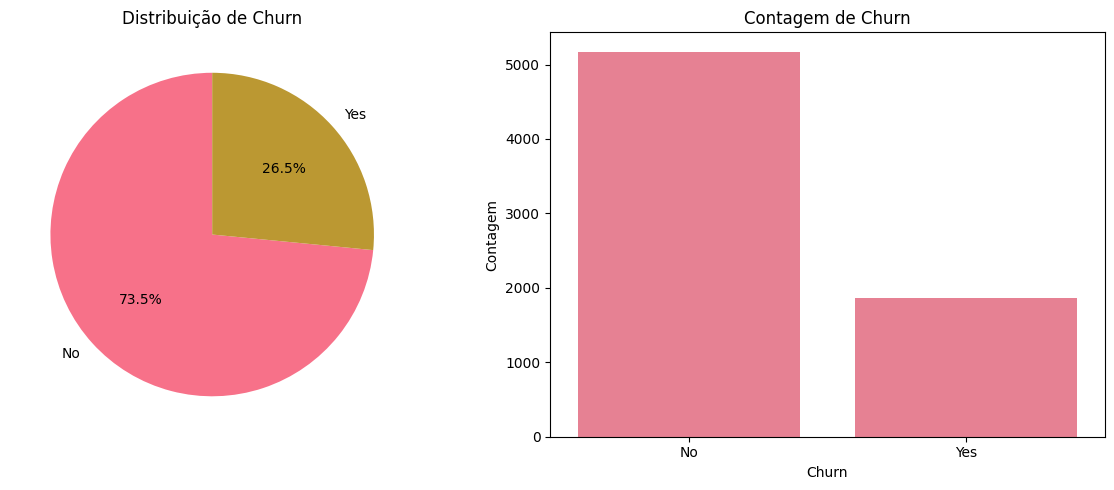

In [ ]:
# Distribuição da variável alvo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de pizza
churn_counts = df['Churn'].value_counts()
axes[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribuição de Churn')

# Gráfico de barras
sns.countplot(data=df, x='Churn', ax=axes[1])
axes[1].set_title('Contagem de Churn')
axes[1].set_ylabel('Contagem')

plt.tight_layout()
plt.show()

In [ ]:
# 4.1. Tratamento de Dados Ausentes (Correção)
print("🔧 Tratando valores ausentes na coluna 'TotalCharges'...")

# Primeiro, garantimos que a coluna é numérica, convertendo o que não for número em NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Calculamos a mediana da coluna (que ignora os NaNs)
median_total_charges = df['TotalCharges'].median()
print(f"   - Mediana calculada: {median_total_charges:.2f}")

# Preenchemos os valores ausentes com a mediana
df['TotalCharges'].fillna(median_total_charges, inplace=True)
print("   - Valores ausentes preenchidos com sucesso!")

# Verificação para confirmar que o problema foi resolvido
print("\n🔍 Verificação pós-tratamento (não deve haver mais NaNs):")
print(df.isnull().sum())

🔧 Tratando valores ausentes na coluna 'TotalCharges'...
   - Mediana calculada: 1397.47
   - Valores ausentes preenchidos com sucesso!

🔍 Verificação pós-tratamento (não deve haver mais NaNs):
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


🔍 Identificando colunas numéricas do dataset:
Colunas numéricas encontradas: ['tenure', 'MonthlyCharges', 'TotalCharges']


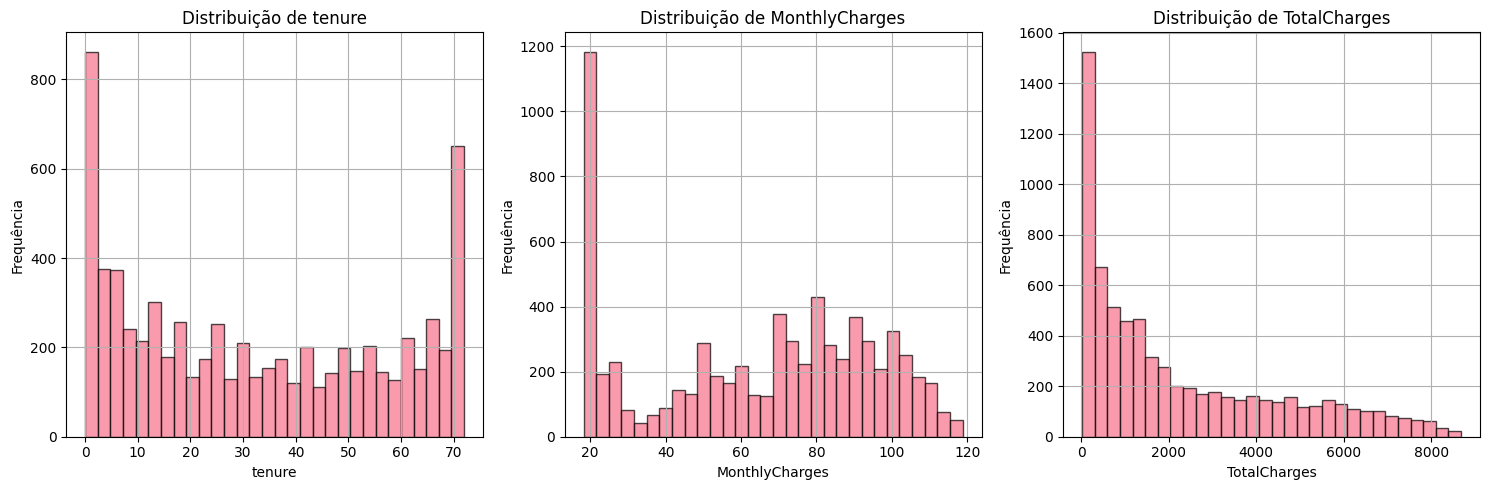

In [ ]:
# Primeiro, vamos identificar as colunas numéricas reais do dataset
print("🔍 Identificando colunas numéricas do dataset:")
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()

# Removendo colunas que podem ser IDs ou categóricas disfarçadas
if 'CustomerID' in numerical_cols:
    numerical_cols.remove('CustomerID')
if 'SeniorCitizen' in numerical_cols:
    numerical_cols.remove('SeniorCitizen')  # Esta é categórica (0/1)

print(f"Colunas numéricas encontradas: {numerical_cols}")

# Se tivermos colunas numéricas, fazemos os histogramas
if len(numerical_cols) > 0:
    # Limitando a 3 colunas para visualização
    cols_to_plot = numerical_cols[:3]

    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(5*len(cols_to_plot), 5))
    if len(cols_to_plot) == 1:
        axes = [axes]  # Para garantir que seja uma lista

    for i, col in enumerate(cols_to_plot):
        df[col].hist(bins=30, edgecolor='black', alpha=0.7, ax=axes[i])
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhuma coluna numérica encontrada para plotar histogramas")

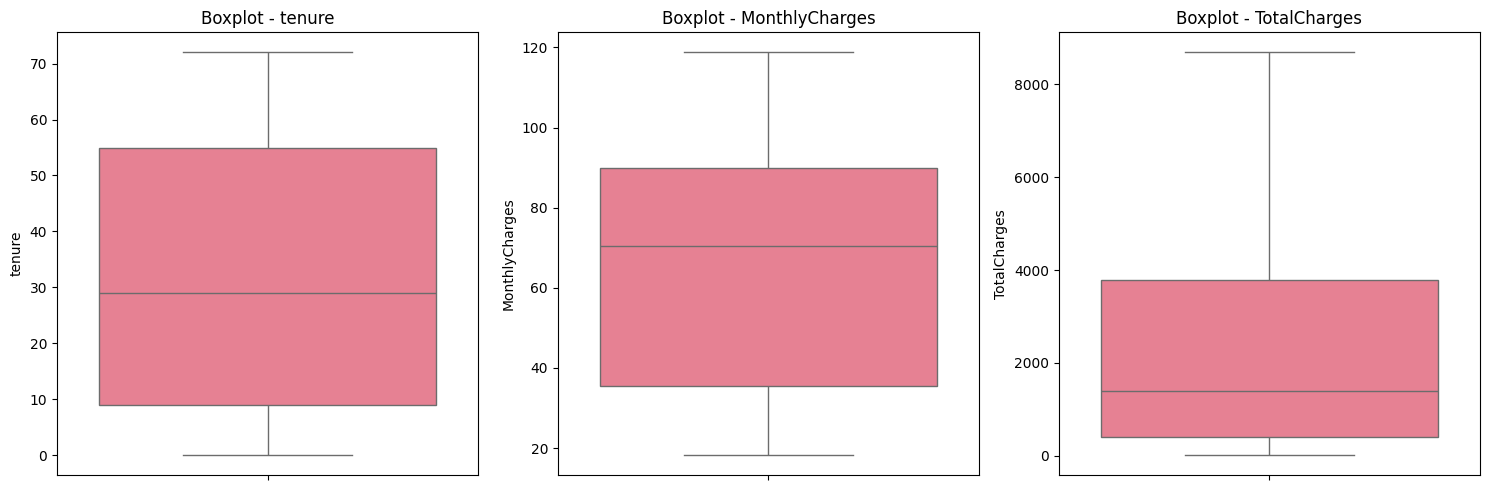

In [ ]:
# Boxplots para detecção de outliers (apenas se houver colunas numéricas)
if len(numerical_cols) > 0:
    cols_to_plot = numerical_cols[:3]

    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(5*len(cols_to_plot), 5))
    if len(cols_to_plot) == 1:
        axes = [axes]

    for i, col in enumerate(cols_to_plot):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot - {col}')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhuma coluna numérica para boxplots")

## 6. Análise Bivariada

🔍 Colunas disponíveis no dataset:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

📊 Colunas categóricas encontradas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


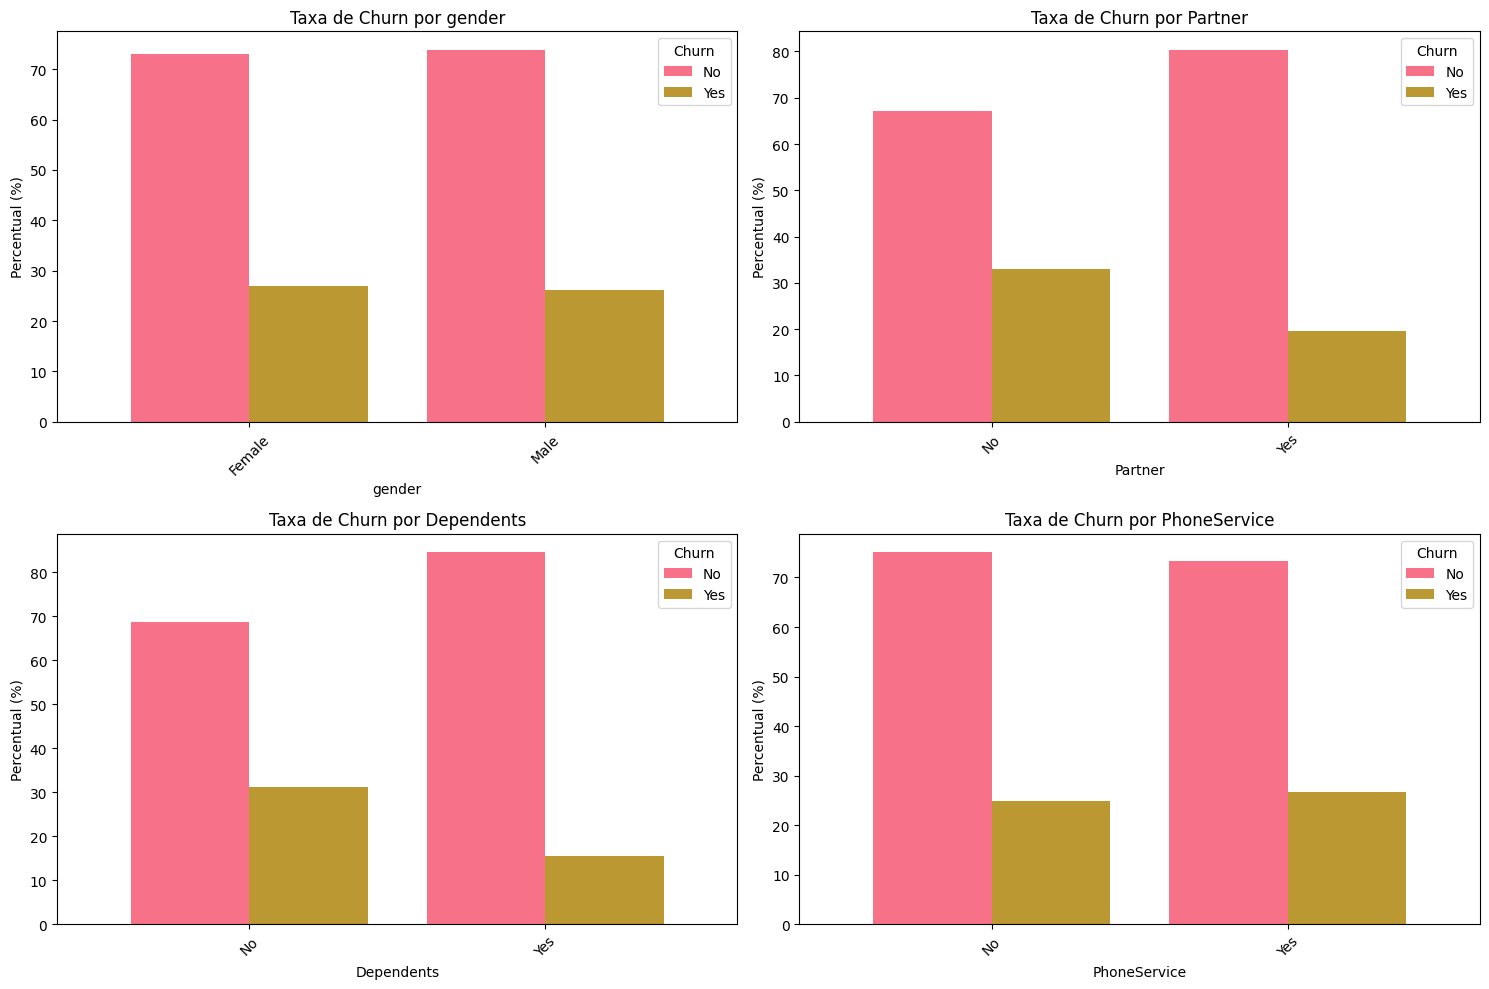

In [ ]:
# Primeiro, vamos ver quais colunas realmente existem no dataset
print("🔍 Colunas disponíveis no dataset:")
print(list(df.columns))

# Identificando colunas categóricas automaticamente
categorical_cols_available = []
for col in df.columns:
    if col != 'Churn' and df[col].dtype == 'object':
        categorical_cols_available.append(col)

print(f"\n📊 Colunas categóricas encontradas: {categorical_cols_available}")

# Se tivermos colunas categóricas, fazemos a análise
if len(categorical_cols_available) > 0:
    # Limitando a 4 colunas para visualização
    cols_to_analyze = categorical_cols_available[:4]

    # Calculando o número de linhas e colunas para o subplot
    n_cols = min(2, len(cols_to_analyze))
    n_rows = (len(cols_to_analyze) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

    # Garantindo que axes seja sempre uma lista 2D
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    axes = axes.flatten()

    for i, col in enumerate(cols_to_analyze):
        try:
            # Criando tabela de contingência normalizada
            contingency_table = pd.crosstab(df[col], df['Churn'], normalize='index') * 100

            contingency_table.plot(kind='bar', ax=axes[i], width=0.8)
            axes[i].set_title(f'Taxa de Churn por {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Percentual (%)')
            axes[i].legend(title='Churn')
            axes[i].tick_params(axis='x', rotation=45)

        except Exception as e:
            axes[i].text(0.5, 0.5, f'Erro ao plotar {col}',
                        ha='center', va='center', transform=axes[i].transAxes)
            print(f"⚠️ Erro ao analisar coluna {col}: {e}")

    # Removendo subplots vazios
    for j in range(len(cols_to_analyze), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Nenhuma coluna categórica encontrada para análise bivariada")
    print("Todas as colunas (exceto Churn) parecem ser numéricas ou não existem")

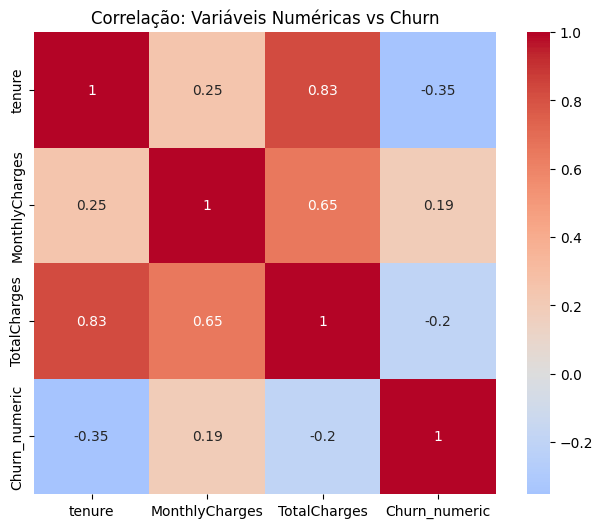

In [ ]:
# Correlação entre variáveis numéricas e churn
df_corr = df.copy()
df_corr['Churn_numeric'] = df_corr['Churn'].map({'No': 0, 'Yes': 1})

corr_matrix = df_corr[numerical_cols + ['Churn_numeric']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlação: Variáveis Numéricas vs Churn')
plt.show()

## 7. Preparação dos Dados

In [ ]:
# Separando features e target
df_processed = df.copy()

# Removendo colunas desnecessárias
if 'CustomerID' in df_processed.columns:
    df_processed = df_processed.drop('CustomerID', axis=1)

# Identificando tipos de variáveis
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')  # Removendo a variável alvo
numerical_features = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"📊 Variáveis categóricas ({len(categorical_features)}): {categorical_features}")
print(f"📊 Variáveis numéricas ({len(numerical_features)}): {numerical_features}")

📊 Variáveis categóricas (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
📊 Variáveis numéricas (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
# Codificação de variáveis categóricas
print("🔧 Codificando variáveis categóricas...")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"  ✅ {col}")

# Codificação da variável alvo
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_processed['Churn'])
print(f"  ✅ Churn (0=No, 1=Yes)")

# Preparando matriz de features
feature_columns = categorical_features + numerical_features
X = df_processed[feature_columns]

print(f"\n📊 Shape final: X={X.shape}, y={y.shape}")

🔧 Codificando variáveis categóricas...
  ✅ gender
  ✅ Partner
  ✅ Dependents
  ✅ PhoneService
  ✅ MultipleLines
  ✅ InternetService
  ✅ OnlineSecurity
  ✅ OnlineBackup
  ✅ DeviceProtection
  ✅ TechSupport
  ✅ StreamingTV
  ✅ StreamingMovies
  ✅ Contract
  ✅ PaperlessBilling
  ✅ PaymentMethod
  ✅ Churn (0=No, 1=Yes)

📊 Shape final: X=(7043, 19), y=(7043,)


## 8. Divisão dos Dados (Train/Validation/Test)

In [ ]:
# Divisão estratificada dos dados
print("📂 Dividindo os dados...")

# Primeira divisão: Train+Val vs Test (80% vs 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Segunda divisão: Train vs Val (75% vs 25% do temp = 60% vs 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"📊 Treinamento: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Validação:   {X_val.shape[0]:,} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Teste:       {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verificando distribuição de classes
print("\n🎯 Distribuição de classes:")
for name, y_set in [('Treinamento', y_train), ('Validação', y_val), ('Teste', y_test)]:
    class_0 = np.sum(y_set == 0)
    class_1 = np.sum(y_set == 1)
    print(f"  {name:12} - Classe 0: {class_0:,} ({class_0/len(y_set)*100:.1f}%) | Classe 1: {class_1:,} ({class_1/len(y_set)*100:.1f}%)")

📂 Dividindo os dados...
📊 Treinamento: 4,225 amostras (60.0%)
📊 Validação:   1,409 amostras (20.0%)
📊 Teste:       1,409 amostras (20.0%)

🎯 Distribuição de classes:
  Treinamento  - Classe 0: 3,104 (73.5%) | Classe 1: 1,121 (26.5%)
  Validação    - Classe 0: 1,035 (73.5%) | Classe 1: 374 (26.5%)
  Teste        - Classe 0: 1,035 (73.5%) | Classe 1: 374 (26.5%)


## 9. Normalização dos Dados

In [ ]:
# Normalização usando StandardScaler
print("⚙️  Normalizando dados...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalização concluída")
print("⚠️  Scaler ajustado apenas no conjunto de treinamento")

# Verificando normalização
print(f"\n📊 Estatísticas pós-normalização (treinamento):")
print(f"   Média (primeiras 5 features): {np.mean(X_train_scaled, axis=0)[:5]}")
print(f"   Desvio padrão (primeiras 5): {np.std(X_train_scaled, axis=0)[:5]}")

⚙️  Normalizando dados...
✅ Normalização concluída
⚠️  Scaler ajustado apenas no conjunto de treinamento

📊 Estatísticas pós-normalização (treinamento):
   Média (primeiras 5 features): [-5.71797705e-17  9.92237193e-17 -6.72703182e-18  1.01746356e-16
 -1.34540636e-17]
   Desvio padrão (primeiras 5): [1. 1. 1. 1. 1.]


## 10. Tratamento do Desbalanceamento

In [ ]:
# Oversampling básico (repetitive oversampling)
def basic_oversampling(X, y, random_state=42):
    """Aplica oversampling básico para balancear as classes"""
    np.random.seed(random_state)

    # Separando as classes
    mask_majority = y == 0
    mask_minority = y == 1

    X_majority = X[mask_majority]
    X_minority = X[mask_minority]
    y_majority = y[mask_majority]
    y_minority = y[mask_minority]

    # Oversampling da classe minoritária
    n_majority = len(X_majority)
    n_minority = len(X_minority)
    n_samples_needed = n_majority - n_minority

    if n_samples_needed > 0:
        indices = np.random.choice(len(X_minority), n_samples_needed, replace=True)
        X_minority_oversampled = X_minority[indices]
        y_minority_oversampled = y_minority[indices]

        # Combinando
        X_balanced = np.concatenate([X_majority, X_minority, X_minority_oversampled])
        y_balanced = np.concatenate([y_majority, y_minority, y_minority_oversampled])
    else:
        X_balanced = np.concatenate([X_majority, X_minority])
        y_balanced = np.concatenate([y_majority, y_minority])

    return X_balanced, y_balanced

print(f"📊 Distribuição original (treinamento): Classe 0 = {np.sum(y_train==0):,}, Classe 1 = {np.sum(y_train==1):,}")

# Aplicando oversampling apenas no treinamento
X_train_balanced, y_train_balanced = basic_oversampling(X_train_scaled, y_train)

print(f"📊 Distribuição balanceada:        Classe 0 = {np.sum(y_train_balanced==0):,}, Classe 1 = {np.sum(y_train_balanced==1):,}")
print("✅ Oversampling aplicado com sucesso!")

📊 Distribuição original (treinamento): Classe 0 = 3,104, Classe 1 = 1,121
📊 Distribuição balanceada:        Classe 0 = 3,104, Classe 1 = 3,104
✅ Oversampling aplicado com sucesso!


## 11. Resumo da Preparação

In [ ]:
print("📋 RESUMO DA PREPARAÇÃO DOS DADOS")
print("=" * 50)
print(f"🔢 Total de features: {X.shape[1]}")
print(f"   - Categóricas: {len(categorical_features)}")
print(f"   - Numéricas: {len(numerical_features)}")
print(f"\n📊 Conjuntos de dados:")
print(f"   - Treinamento (balanceado): {X_train_balanced.shape}")
print(f"   - Validação: {X_val_scaled.shape}")
print(f"   - Teste: {X_test_scaled.shape}")
print(f"\n✅ Dados prontos para modelagem!")
print(f"\n📝 Próximos passos:")
print(f"   1. Implementar MLP (Perceptron Multicamadas)")
print(f"   2. Testar diferentes hiperparâmetros")
print(f"   3. Avaliar com métricas KS, ROC-AUC, F1-Score")
print(f"   4. Comparar com outros modelos (Random Forest, Gradient Boosting)")

📋 RESUMO DA PREPARAÇÃO DOS DADOS
🔢 Total de features: 19
   - Categóricas: 15
   - Numéricas: 4

📊 Conjuntos de dados:
   - Treinamento (balanceado): (6208, 19)
   - Validação: (1409, 19)
   - Teste: (1409, 19)

✅ Dados prontos para modelagem!

📝 Próximos passos:
   1. Implementar MLP (Perceptron Multicamadas)
   2. Testar diferentes hiperparâmetros
   3. Avaliar com métricas KS, ROC-AUC, F1-Score
   4. Comparar com outros modelos (Random Forest, Gradient Boosting)


## 12. Implementação da Métrica KS (Kolmogorov-Smirnov)

In [ ]:
def calculate_ks_statistic(y_true, y_proba):
    """
    Calcula a estatística KS (Kolmogorov-Smirnov) - métrica principal do projeto
    """
    from scipy import stats

    # Separando as probabilidades por classe
    class_0_proba = y_proba[y_true == 0]
    class_1_proba = y_proba[y_true == 1]

    # Calculando a estatística KS
    ks_statistic, p_value = stats.ks_2samp(class_0_proba, class_1_proba)

    return ks_statistic, p_value

def plot_ks_curve(y_true, y_proba, title="KS Curve"):
    """
    Plota a curva KS conforme especificado no projeto
    """
    # Separando as probabilidades por classe
    class_0_proba = y_proba[y_true == 0]
    class_1_proba = y_proba[y_true == 1]

    # Calculando CDFs
    x = np.linspace(0, 1, 100)
    cdf_0 = [np.mean(class_0_proba <= xi) for xi in x]
    cdf_1 = [np.mean(class_1_proba <= xi) for xi in x]

    # Plotando
    plt.figure(figsize=(10, 6))
    plt.plot(x, cdf_0, label='Classe 0 (No Churn)', linewidth=2, color='blue')
    plt.plot(x, cdf_1, label='Classe 1 (Churn)', linewidth=2, color='red')
    plt.plot(x, np.abs(np.array(cdf_1) - np.array(cdf_0)),
             label='|CDF1 - CDF0|', linestyle='--', linewidth=2, color='green')

    # Encontrando o ponto de máxima diferença (KS)
    max_diff_idx = np.argmax(np.abs(np.array(cdf_1) - np.array(cdf_0)))
    max_diff = np.abs(cdf_1[max_diff_idx] - cdf_0[max_diff_idx])

    plt.axhline(y=max_diff, color='red', linestyle=':', alpha=0.7)
    plt.axvline(x=x[max_diff_idx], color='red', linestyle=':', alpha=0.7)

    plt.xlabel('Probabilidade Predita')
    plt.ylabel('CDF')
    plt.title(f'{title} - KS = {max_diff:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return max_diff

print("✅ Funções KS implementadas com sucesso!")

✅ Funções KS implementadas com sucesso!


## 13. Modelo Baseline - Random Forest

In [ ]:


print("🌲 Implementando Random Forest como modelo baseline...")

# Parâmetros sugeridos no projeto
rf_model = RandomForestClassifier(
    n_estimators=100,      # Parâmetro sugerido no projeto
    max_depth=10,          # Parâmetro sugerido no projeto
    max_features='sqrt',   # Parâmetro sugerido no projeto
    min_samples_leaf=5,    # Parâmetro sugerido no projeto
    random_state=42,
    n_jobs=-1
)

print("Treinando Random Forest...")
rf_model.fit(X_train_balanced, y_train_balanced)

print("✅ Random Forest treinado com sucesso!")

🌲 Implementando Random Forest como modelo baseline...
Treinando Random Forest...
✅ Random Forest treinado com sucesso!


In [ ]:
# Fazendo predições com Random Forest
print("📊 Fazendo predições...")

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Probabilidades para métricas KS e ROC-AUC
y_train_proba_rf = rf_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Predições concluídas!")

📊 Fazendo predições...
✅ Predições concluídas!


## 14. Avaliação do Random Forest

In [ ]:
# Importando métricas que faltaram
from sklearn.metrics import f1_score

def evaluate_model(y_true, y_pred, y_proba, dataset_name=""):
    """
    Avaliação com as métricas especificadas no projeto
    """
    print(f"\n📊 {dataset_name}")
    print("-" * 40)

    # Métricas principais do projeto
    roc_auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    ks_stat, _ = calculate_ks_statistic(y_true, y_proba)

    # MSE e Cross-entropy (especificados no projeto)
    mse = np.mean((y_true - y_proba) ** 2)
    epsilon = 1e-15
    y_proba_clipped = np.clip(y_proba, epsilon, 1 - epsilon)
    cross_entropy = -np.mean(y_true * np.log(y_proba_clipped) + (1 - y_true) * np.log(1 - y_proba_clipped))

    print(f"  🎯 KS (Principal): {ks_stat:.4f}")
    print(f"  📊 ROC-AUC: {roc_auc:.4f}")
    print(f"  🔄 F1-Score: {f1:.4f}")
    print(f"  📉 MSE: {mse:.4f}")
    print(f"  🔥 Cross-Entropy: {cross_entropy:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n  📋 Matriz de Confusão:")
    print(f"      [[TN: {cm[0,0]}, FP: {cm[0,1]}]")
    print(f"       [FN: {cm[1,0]}, TP: {cm[1,1]}]]")

    return {
        'ks': ks_stat,
        'roc_auc': roc_auc,
        'f1_score': f1,
        'mse': mse,
        'cross_entropy': cross_entropy
    }

# Avaliando Random Forest
print("🔍 AVALIAÇÃO DO RANDOM FOREST")
print("=" * 50)

rf_results_train = evaluate_model(y_train, y_train_pred_rf, y_train_proba_rf, "TREINAMENTO")
rf_results_val = evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "VALIDAÇÃO")
rf_results_test = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf, "TESTE")

🔍 AVALIAÇÃO DO RANDOM FOREST

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.7477
  📊 ROC-AUC: 0.9438
  🔄 F1-Score: 0.7669
  📉 MSE: 0.1070
  🔥 Cross-Entropy: 0.3436

  📋 Matriz de Confusão:
      [[TN: 2572, FP: 532]
       [FN: 93, TP: 1028]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5226
  📊 ROC-AUC: 0.8329
  🔄 F1-Score: 0.6232
  📉 MSE: 0.1579
  🔥 Cross-Entropy: 0.4777

  📋 Matriz de Confusão:
      [[TN: 797, FP: 238]
       [FN: 97, TP: 277]]

📊 TESTE
----------------------------------------
  🎯 KS (Principal): 0.5368
  📊 ROC-AUC: 0.8373
  🔄 F1-Score: 0.6290
  📉 MSE: 0.1569
  🔥 Cross-Entropy: 0.4719

  📋 Matriz de Confusão:
      [[TN: 790, FP: 245]
       [FN: 90, TP: 284]]



📈 Curvas KS - Random Forest:


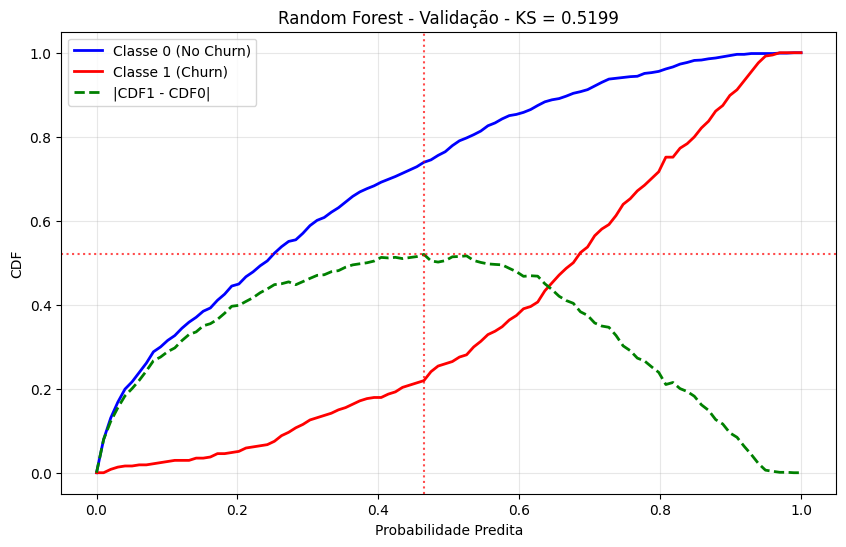

np.float64(0.5198790978842129)

In [ ]:
# Plotando curva KS para Random Forest
print("\n📈 Curvas KS - Random Forest:")

plot_ks_curve(y_val, y_val_proba_rf, "Random Forest - Validação")

In [ ]:
## 15. Modelo Baseline - MLP

## 15. Modelo Baseline - MLP

Importando MLPClassifier

In [ ]:

from sklearn.neural_network import MLPClassifier

print("🧠 Implementando MLP simples (1 camada, 10 neurônios)...")

🧠 Implementando MLP simples (1 camada, 10 neurônios)...


Parâmetros sugeridos no projeto

In [ ]:
mlp_model = MLPClassifier(
hidden_layer_sizes=(10,), # 1 camada com ~10 neurônios
activation='relu',
solver='adam',
learning_rate_init=0.001,
alpha=0.0001,
max_iter=10000,
random_state=42,
early_stopping=True,
n_iter_no_change=20,
validation_fraction=0.2
)

print("Treinando MLP...")
mlp_model.fit(X_train_balanced, y_train_balanced)

print("✅ MLP treinada com sucesso!")

Treinando MLP...
✅ MLP treinada com sucesso!


Fazendo predições com MLP

In [ ]:
print("📊 Fazendo predições...")

y_train_pred_mlp = mlp_model.predict(X_train_scaled)
y_val_pred_mlp = mlp_model.predict(X_val_scaled)
y_test_pred_mlp = mlp_model.predict(X_test_scaled)

📊 Fazendo predições...


Probabilidades para métricas KS e ROC-AUC

In [ ]:
y_train_proba_mlp = mlp_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_mlp = mlp_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
print("✅ Predições concluídas!")

✅ Predições concluídas!


## 16. Avaliação da MLP

In [ ]:
print("🔍 AVALIAÇÃO DA MLP")
print("=" * 50)

mlp_results_train = evaluate_model(y_train, y_train_pred_mlp, y_train_proba_mlp, "TREINAMENTO")
mlp_results_val = evaluate_model(y_val, y_val_pred_mlp, y_val_proba_mlp, "VALIDAÇÃO")
mlp_results_test = evaluate_model(y_test, y_test_pred_mlp, y_test_proba_mlp, "TESTE")

🔍 AVALIAÇÃO DA MLP

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.5641
  📊 ROC-AUC: 0.8591
  🔄 F1-Score: 0.6491
  📉 MSE: 0.1580
  🔥 Cross-Entropy: 0.4733

  📋 Matriz de Confusão:
      [[TN: 2323, FP: 781]
       [FN: 207, TP: 914]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5072
  📊 ROC-AUC: 0.8266
  🔄 F1-Score: 0.6070
  📉 MSE: 0.1714
  🔥 Cross-Entropy: 0.5103

  📋 Matriz de Confusão:
      [[TN: 748, FP: 287]
       [FN: 86, TP: 288]]

📊 TESTE
----------------------------------------
  🎯 KS (Principal): 0.5137
  📊 ROC-AUC: 0.8290
  🔄 F1-Score: 0.6013
  📉 MSE: 0.1726
  🔥 Cross-Entropy: 0.5087

  📋 Matriz de Confusão:
      [[TN: 746, FP: 289]
       [FN: 89, TP: 285]]


Plotando curva KS para MLP


📈 Curvas KS - MLP:


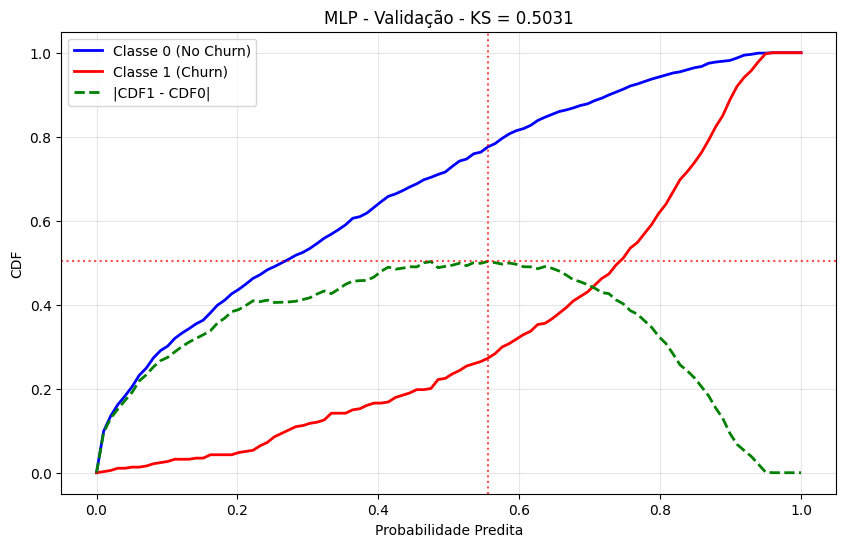

np.float64(0.5031181379007467)

In [ ]:
print("\n📈 Curvas KS - MLP:")

plot_ks_curve(y_val, y_val_proba_mlp, "MLP - Validação")

# 17.Modelo Avançado - TabPFN

In [ ]:
print("🤖 Implementando TabPFN...")

# Instanciando o modelo
# N_ensemble_configurations define o trade-off entre velocidade e performance
# device='cuda' utiliza a GPU, se disponível, o que acelera muito o processo
tabpfn_model = TabPFNClassifier(device='cuda')

print("Treinando TabPFN...")
# O TabPFN funciona melhor com o dataset de treino original (não balanceado),
# pois ele aprende a lidar com o desbalanceamento internamente.
# Também não precisa dos dados escalados.
tabpfn_model.fit(X_train, y_train)

print("✅ TabPFN treinado com sucesso!")

🤖 Implementando TabPFN...
Treinando TabPFN...


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

✅ TabPFN treinado com sucesso!


In [ ]:
# Fazendo predições com TabPFN
print("📊 Fazendo predições com TabPFN...")

# Usamos os dados originais (não escalados) para predição também
y_train_pred_tabpfn = tabpfn_model.predict(X_train)
y_val_pred_tabpfn = tabpfn_model.predict(X_val)
y_test_pred_tabpfn = tabpfn_model.predict(X_test)

# Probabilidades
y_train_proba_tabpfn = tabpfn_model.predict_proba(X_train)[:, 1]
y_val_proba_tabpfn = tabpfn_model.predict_proba(X_val)[:, 1]
y_test_proba_tabpfn = tabpfn_model.predict_proba(X_test)[:, 1]

print("✅ Predições concluídas!")

📊 Fazendo predições com TabPFN...
✅ Predições concluídas!


# 18. Avaliação do TabPFN


In [ ]:
print("🔍 AVALIAÇÃO DO TabPFN")
print("=" * 50)

# Usamos os dados de validação e teste não escalados para avaliação
tabpfn_results_train = evaluate_model(y_train, y_train_pred_tabpfn, y_train_proba_tabpfn, "TREINAMENTO")
tabpfn_results_val = evaluate_model(y_val, y_val_pred_tabpfn, y_val_proba_tabpfn, "VALIDAÇÃO")
tabpfn_results_test = evaluate_model(y_test, y_test_pred_tabpfn, y_test_proba_tabpfn, "TESTE")

🔍 AVALIAÇÃO DO TabPFN

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.5798
  📊 ROC-AUC: 0.8670
  🔄 F1-Score: 0.6167
  📉 MSE: 0.1260
  🔥 Cross-Entropy: 0.3894

  📋 Matriz de Confusão:
      [[TN: 2832, FP: 272]
       [FN: 500, TP: 621]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5352
  📊 ROC-AUC: 0.8404
  🔄 F1-Score: 0.5884
  📉 MSE: 0.1362
  🔥 Cross-Entropy: 0.4254

  📋 Matriz de Confusão:
      [[TN: 946, FP: 89]
       [FN: 181, TP: 193]]

📊 TESTE
----------------------------------------
  🎯 KS (Principal): 0.5391
  📊 ROC-AUC: 0.8514
  🔄 F1-Score: 0.5934
  📉 MSE: 0.1336
  🔥 Cross-Entropy: 0.4100

  📋 Matriz de Confusão:
      [[TN: 942, FP: 93]
       [FN: 177, TP: 197]]



📈 Curvas KS - TabPFN:


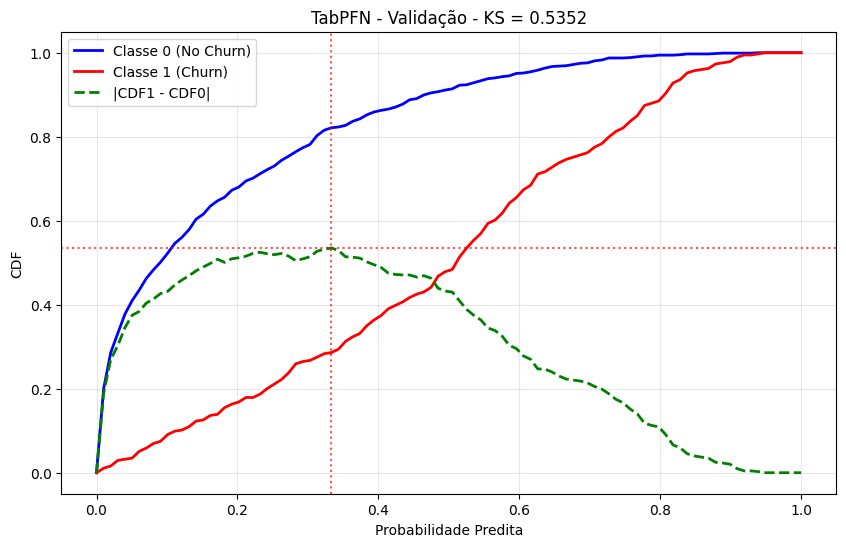

np.float64(0.5351597819628511)

In [ ]:
print("\n📈 Curvas KS - TabPFN:")
plot_ks_curve(y_val, y_val_proba_tabpfn, "TabPFN - Validação")

# 19. Modelo Baseline - Gradient Boosting

In [ ]:
# Importando Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

print("🚀 Implementando Gradient Boosting...")

# Parâmetros otimizados para problemas de churn
gb_model = GradientBoostingClassifier(
    n_estimators=100,           # Número de árvores
    learning_rate=0.1,          # Taxa de aprendizado
    max_depth=6,                # Profundidade máxima das árvores
    min_samples_split=20,       # Mínimo de amostras para dividir um nó
    min_samples_leaf=5,         # Mínimo de amostras em uma folha
    subsample=0.8,              # Fração de amostras para cada árvore
    max_features='sqrt',        # Número de features consideradas
    random_state=42,
    verbose=0
)

print("Treinando Gradient Boosting...")
gb_model.fit(X_train_balanced, y_train_balanced)

print("✅ Gradient Boosting treinado com sucesso!")

🚀 Implementando Gradient Boosting...
Treinando Gradient Boosting...
✅ Gradient Boosting treinado com sucesso!


In [ ]:
# Fazendo predições com Gradient Boosting
print("📊 Fazendo predições com Gradient Boosting...")

y_train_pred_gb = gb_model.predict(X_train_scaled)
y_val_pred_gb = gb_model.predict(X_val_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)

# Probabilidades para métricas KS e ROC-AUC
y_train_proba_gb = gb_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_gb = gb_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Predições concluídas!")

📊 Fazendo predições com Gradient Boosting...
✅ Predições concluídas!


# 20 Avaliação do Gradient Boosting

In [ ]:
print("🔍 AVALIAÇÃO DO GRADIENT BOOSTING")
print("=" * 50)

gb_results_train = evaluate_model(y_train, y_train_pred_gb, y_train_proba_gb, "TREINAMENTO")
gb_results_val = evaluate_model(y_val, y_val_pred_gb, y_val_proba_gb, "VALIDAÇÃO")
gb_results_test = evaluate_model(y_test, y_test_pred_gb, y_test_proba_gb, "TESTE")

🔍 AVALIAÇÃO DO GRADIENT BOOSTING

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.7953
  📊 ROC-AUC: 0.9573
  🔄 F1-Score: 0.8060
  📉 MSE: 0.0889
  🔥 Cross-Entropy: 0.2939

  📋 Matriz de Confusão:
      [[TN: 2680, FP: 424]
       [FN: 78, TP: 1043]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4955
  📊 ROC-AUC: 0.8280
  🔄 F1-Score: 0.6105
  📉 MSE: 0.1582
  🔥 Cross-Entropy: 0.4751

  📋 Matriz de Confusão:
      [[TN: 824, FP: 211]
       [FN: 117, TP: 257]]

📊 TESTE
----------------------------------------
  🎯 KS (Principal): 0.5104
  📊 ROC-AUC: 0.8288
  🔄 F1-Score: 0.6129
  📉 MSE: 0.1590
  🔥 Cross-Entropy: 0.4790

  📋 Matriz de Confusão:
      [[TN: 816, FP: 219]
       [FN: 112, TP: 262]]



📈 Curvas KS - Gradient Boosting:


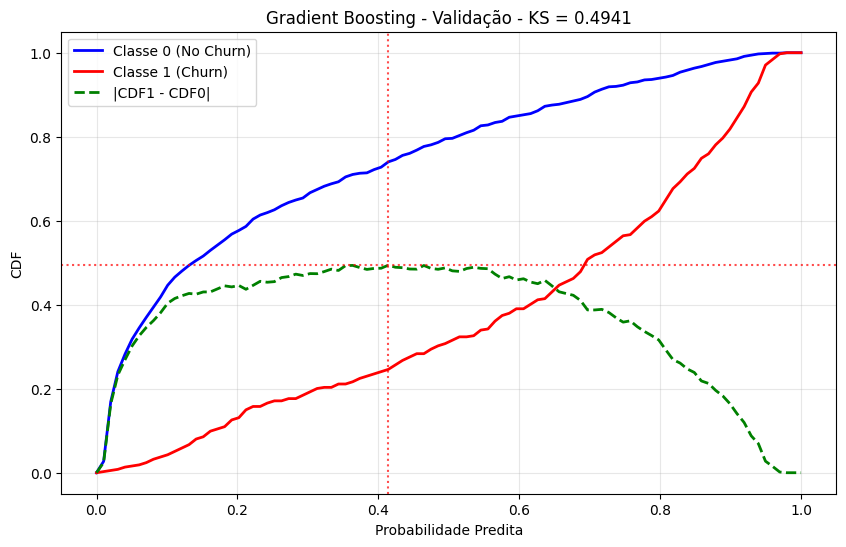

np.float64(0.49410731354465376)

In [ ]:
print("\n📈 Curvas KS - Gradient Boosting:")
plot_ks_curve(y_val, y_val_proba_gb, "Gradient Boosting - Validação")

# 21. Benchmark dos Modelos com STAB

In [ ]:
Or_model = mainmodel.MainModel(
    categories        = (),   # Sem features categóricas após encoding
    num_continuous    = 7,    # 7 features numéricas
    dim               = 16,
    dim_out           = 1,    # 1 classe de saída
    depth             = 2,
    heads             = 4,
    attn_dropout      = 0.1,
    ff_dropout        = 0.1,
    U                 = 2,
    cases             = 8,
    )

# Criar wrapper Num_Cat
model_wrapper = Num_Cat(Or_model, num_number=7, classes=1, Sample_size=16)

# Converter para keras4torch
model = keras4torch.Model(model_wrapper).build([7])

# Configurar otimizador e compilar
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])

# Converter DataFrames para numpy arrays
X_train_np = X_train.to_numpy().astype(np.float32)
X_val_np = X_val.to_numpy().astype(np.float32)

# Reshape y_train e y_val para compatibilidade com o modelo e converter para float32
y_train_reshaped = y_train.reshape(-1, 1).astype(np.float32)
y_val_reshaped = y_val.reshape(-1, 1).astype(np.float32)

# Treinamento
model.fit([X_train_np], y_train_reshaped,
          epochs=20, batch_size=32,
          validation_data=([X_val_np], y_val_reshaped),
          verbose=2)

Train on 4225 samples, validate on 1409 samples:
Epoch 1/20 - 19s - loss: 0.5313 - auc: nan - val_loss: 0.5210 - val_auc: nan - lr: 1e-03
Epoch 2/20 - 17s - loss: 0.5131 - auc: nan - val_loss: 0.5364 - val_auc: nan - lr: 1e-03
Epoch 3/20 - 17s - loss: 0.5082 - auc: nan - val_loss: 0.5058 - val_auc: nan - lr: 1e-03
Epoch 4/20 - 23s - loss: 0.5004 - auc: nan - val_loss: 0.5071 - val_auc: nan - lr: 1e-03
Epoch 5/20 - 17s - loss: 0.5006 - auc: nan - val_loss: 0.5024 - val_auc: nan - lr: 1e-03
Epoch 6/20 - 16s - loss: 0.4998 - auc: nan - val_loss: 0.5012 - val_auc: nan - lr: 1e-03
Epoch 7/20 - 17s - loss: 0.4992 - auc: nan - val_loss: 0.5067 - val_auc: nan - lr: 1e-03
Epoch 8/20 - 16s - loss: 0.4966 - auc: nan - val_loss: 0.5005 - val_auc: nan - lr: 1e-03
Epoch 9/20 - 17s - loss: 0.4964 - auc: nan - val_loss: 0.4996 - val_auc: nan - lr: 1e-03
Epoch 10/20 - 17s - loss: 0.4953 - auc: nan - val_loss: 0.5031 - val_auc: nan - lr: 1e-03
Epoch 11/20 - 17s - loss: 0.4954 - auc: nan - val_loss: 0.50

,loss,auc,val_loss,val_auc,lr
1,0.531311,NaN,0.521034,NaN,0.001
2,0.513064,NaN,0.536414,NaN,0.001
3,0.508232,NaN,0.505798,NaN,0.001
4,0.500433,NaN,0.507103,NaN,0.001
5,0.500609,NaN,0.502378,NaN,0.001
6,0.499791,NaN,0.501191,NaN,0.001
7,0.499250,NaN,0.506682,NaN,0.001
8,0.496571,NaN,0.500496,NaN,0.001
9,0.496401,NaN,0.499629,NaN,0.001
10,0.495276,NaN,0.503134,NaN,0.001


In [ ]:
# Fazendo predições com o modelo STAB
print("📊 Fazendo predições com STAB...")

# Converter X_test também para numpy
X_test_np = X_test.to_numpy()

# Usar o modelo para predições
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.FloatTensor(X_train_np).to(device)
X_val_tensor = torch.FloatTensor(X_val_np).to(device)
X_test_tensor = torch.FloatTensor(X_test_np).to(device)

# Predições
with torch.no_grad():
    model.eval()

    # Probabilidades
    train_logits = model(X_train_tensor).squeeze()
    val_logits = model(X_val_tensor).squeeze()
    test_logits = model(X_test_tensor).squeeze()

    # Converter logits para probabilidades usando sigmoid
    y_train_proba_stab = torch.sigmoid(train_logits).cpu().numpy()
    y_val_proba_stab = torch.sigmoid(val_logits).cpu().numpy()
    y_test_proba_stab = torch.sigmoid(test_logits).cpu().numpy()

    # Predições binárias (threshold = 0.5)
    y_train_pred_stab = (y_train_proba_stab > 0.5).astype(int)
    y_val_pred_stab = (y_val_proba_stab > 0.5).astype(int)
    y_test_pred_stab = (y_test_proba_stab > 0.5).astype(int)

print("✅ Predições STAB concluídas!")

📊 Fazendo predições com STAB...
✅ Predições STAB concluídas!


# 22. Avaliação do Modelo STAB

In [ ]:
print("🔍 AVALIAÇÃO DO MODELO STAB")
print("=" * 50)

stab_results_train = evaluate_model(y_train, y_train_pred_stab, y_train_proba_stab, "TREINAMENTO")
stab_results_val = evaluate_model(y_val, y_val_pred_stab, y_val_proba_stab, "VALIDAÇÃO")
stab_results_test = evaluate_model(y_test, y_test_pred_stab, y_test_proba_stab, "TESTE")

🔍 AVALIAÇÃO DO MODELO STAB

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.4404
  📊 ROC-AUC: 0.7724
  🔄 F1-Score: 0.4376
  📉 MSE: 0.1601
  🔥 Cross-Entropy: 0.4849

  📋 Matriz de Confusão:
      [[TN: 2804, FP: 300]
       [FN: 723, TP: 398]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4111
  📊 ROC-AUC: 0.7521
  🔄 F1-Score: 0.3826
  📉 MSE: 0.1658
  🔥 Cross-Entropy: 0.4996

  📋 Matriz de Confusão:
      [[TN: 927, FP: 108]
       [FN: 260, TP: 114]]

📊 TESTE
----------------------------------------
  🎯 KS (Principal): 0.4098
  📊 ROC-AUC: 0.7534
  🔄 F1-Score: 0.4086
  📉 MSE: 0.1652
  🔥 Cross-Entropy: 0.4987

  📋 Matriz de Confusão:
      [[TN: 930, FP: 105]
       [FN: 251, TP: 123]]



📈 Curvas KS - STAB:


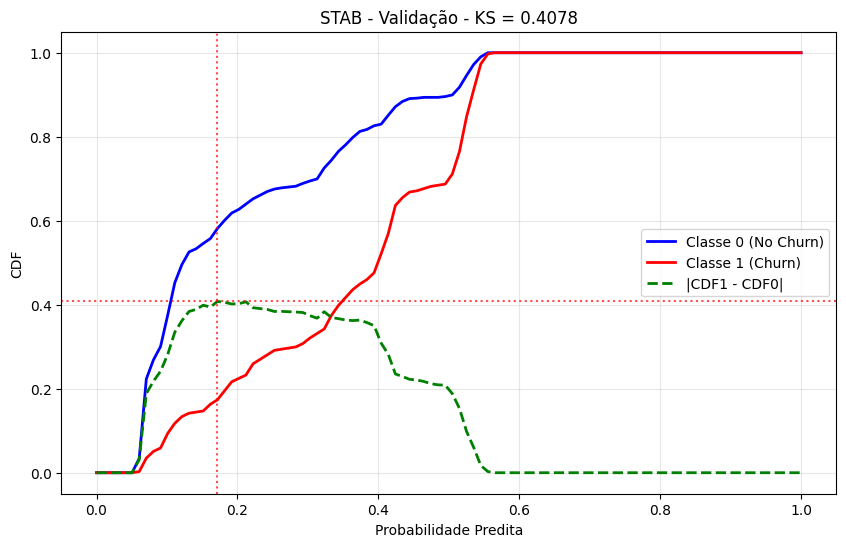

np.float64(0.4078457206334444)

In [ ]:
print("\n📈 Curvas KS - STAB:")
plot_ks_curve(y_val, y_val_proba_stab, "STAB - Validação")

# 23. Comparação Final dos Modelos - Bases

In [ ]:
# Criando tabela comparativa de todos os modelos
print("📊 TABELA COMPARATIVA - CONJUNTO DE VALIDAÇÃO")
print("=" * 60)

# Coletando resultados de validação
results_comparison = {
    'Random Forest': rf_results_val,
    'MLP': mlp_results_val,
    'Gradient Boosting': gb_results_val,
    'TabPFN': tabpfn_results_val,
    'STAB': stab_results_val
}

# Criando DataFrame
comparison_df = pd.DataFrame(results_comparison).T
comparison_df = comparison_df.round(4)

# Ordenando por KS (métrica principal do projeto)
comparison_df_sorted = comparison_df.sort_values('ks', ascending=False)

print("\n🏆 RANKING DOS MODELOS (por KS - Métrica Principal):")
print("=" * 60)
display(comparison_df_sorted)

# Identificando o melhor modelo
best_model = comparison_df_sorted.index[0]
best_ks = comparison_df_sorted.loc[best_model, 'ks']
print(f"\n🥇 MELHOR MODELO: {best_model}")
print(f"   KS Score: {best_ks:.4f}")

📊 TABELA COMPARATIVA - CONJUNTO DE VALIDAÇÃO

🏆 RANKING DOS MODELOS (por KS - Métrica Principal):


,ks,roc_auc,f1_score,mse,cross_entropy
TabPFN,0.5352,0.8404,0.5884,0.1362,0.4254
Random Forest,0.5226,0.8329,0.6232,0.1579,0.4777
MLP,0.5072,0.8266,0.6070,0.1714,0.5103
Gradient Boosting,0.4955,0.8280,0.6105,0.1582,0.4751
STAB,0.4111,0.7521,0.3826,0.1658,0.4996



🥇 MELHOR MODELO: TabPFN
   KS Score: 0.5352


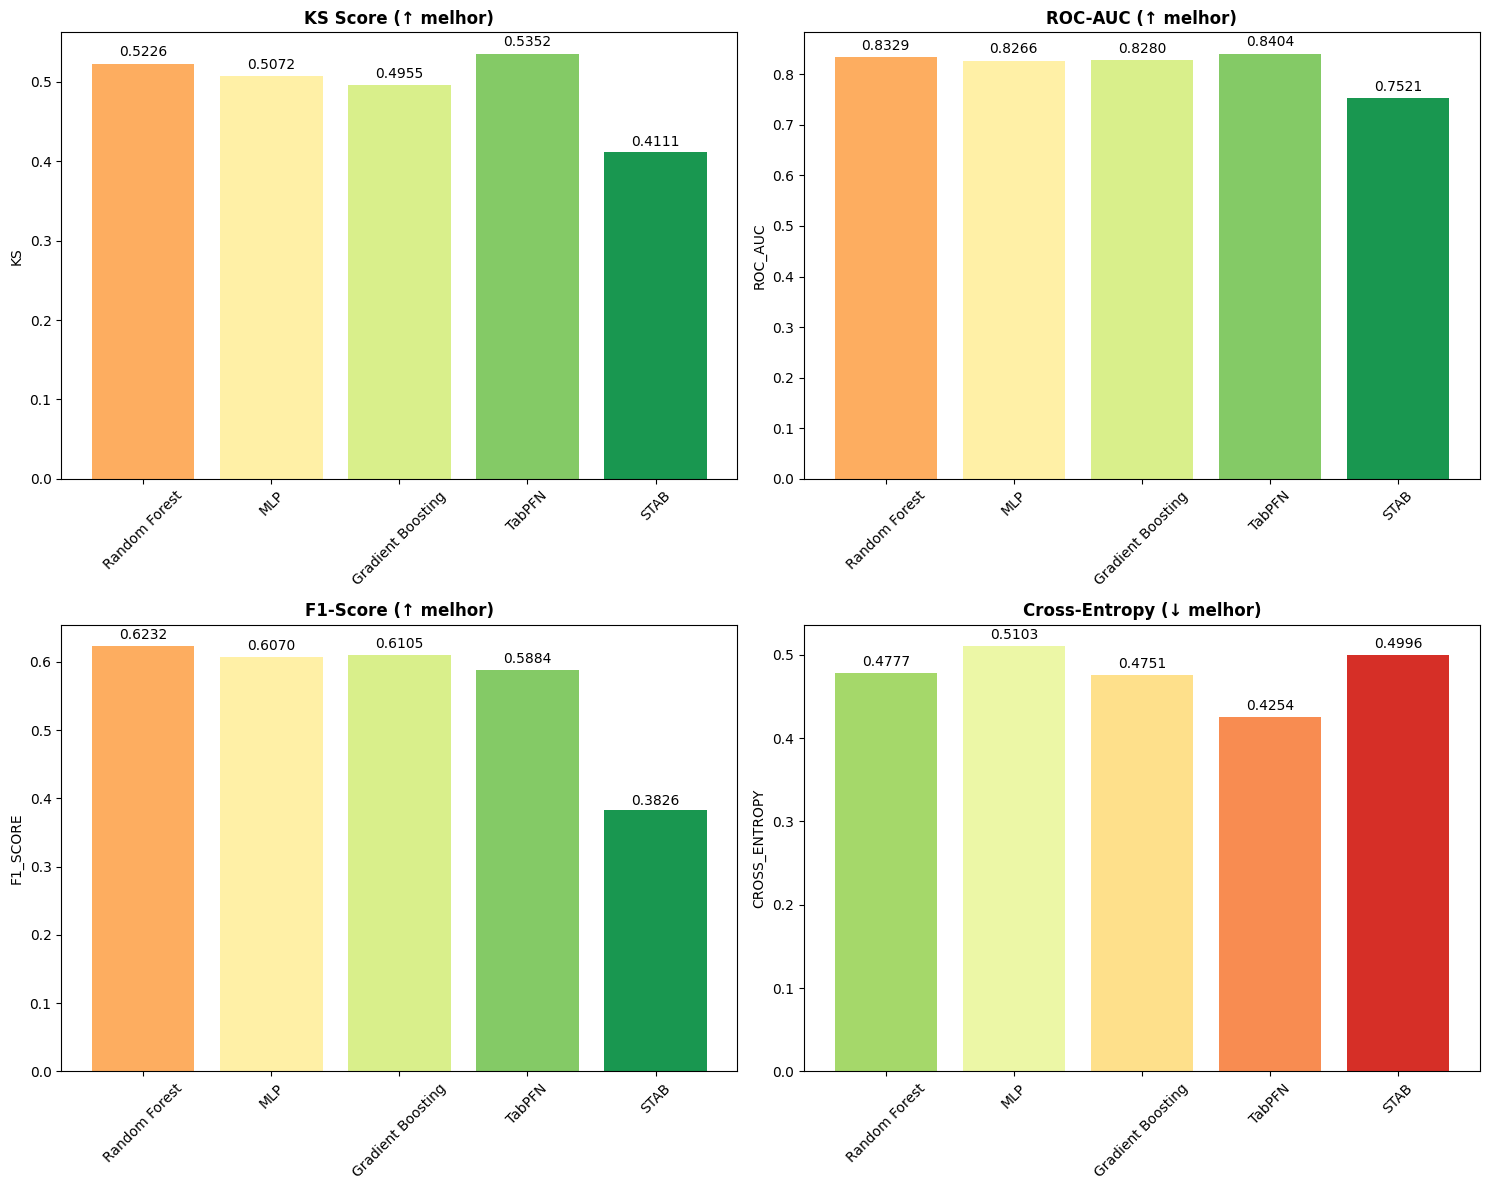

In [ ]:
# Visualização gráfica da comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Métricas para plotar
metrics_to_plot = ['ks', 'roc_auc', 'f1_score', 'cross_entropy']
titles = ['KS Score (↑ melhor)', 'ROC-AUC (↑ melhor)', 'F1-Score (↑ melhor)', 'Cross-Entropy (↓ melhor)']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    row = i // 2
    col = i % 2

    # Dados para o gráfico
    models = comparison_df.index.tolist()
    values = comparison_df[metric].values

    # Cores baseadas no desempenho (melhor = verde, pior = vermelho)
    if metric == 'cross_entropy':  # Para cross-entropy, menor é melhor
        colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(values)))
    else:  # Para outras métricas, maior é melhor
        colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(values)))

    bars = axes[row, col].bar(models, values, color=colors)
    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric.upper())
    axes[row, col].tick_params(axis='x', rotation=45)

    # Adicionando valores nas barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 24 Resultados no Conjunto de Teste

In [ ]:
print("🧪 RESULTADOS FINAIS - CONJUNTO DE TESTE")
print("=" * 50)

# Resultados no conjunto de teste
test_results = {
    'Random Forest': rf_results_test,
    'MLP': mlp_results_test,
    'Gradient Boosting': gb_results_test,
    'TabPFN': tabpfn_results_test,
    'STAB': stab_results_test
}

test_df = pd.DataFrame(test_results).T.round(4)
test_df_sorted = test_df.sort_values('ks', ascending=False)

print("🏆 PERFORMANCE FINAL (Conjunto de Teste):")
display(test_df_sorted)

# Verificando se há overfitting
print("\n🔍 ANÁLISE DE OVERFITTING:")
print("=" * 40)
for model_name in comparison_df.index:
    val_ks = comparison_df.loc[model_name, 'ks']
    test_ks = test_df.loc[model_name, 'ks']
    diff = val_ks - test_ks

    if diff > 0.05:
        status = "⚠️  Possível overfitting"
    elif diff > 0.02:
        status = "🟡 Leve overfitting"
    else:
        status = "✅ Boa generalização"

    print(f"{model_name:15} | Val: {val_ks:.4f} | Test: {test_ks:.4f} | Diff: {diff:+.4f} | {status}")

🧪 RESULTADOS FINAIS - CONJUNTO DE TESTE
🏆 PERFORMANCE FINAL (Conjunto de Teste):


,ks,roc_auc,f1_score,mse,cross_entropy
TabPFN,0.5391,0.8514,0.5934,0.1336,0.4100
Random Forest,0.5368,0.8373,0.6290,0.1569,0.4719
MLP,0.5137,0.8290,0.6013,0.1726,0.5087
Gradient Boosting,0.5104,0.8288,0.6129,0.1590,0.4790
STAB,0.4098,0.7534,0.4086,0.1652,0.4987



🔍 ANÁLISE DE OVERFITTING:
Random Forest   | Val: 0.5226 | Test: 0.5368 | Diff: -0.0142 | ✅ Boa generalização
MLP             | Val: 0.5072 | Test: 0.5137 | Diff: -0.0065 | ✅ Boa generalização
Gradient Boosting | Val: 0.4955 | Test: 0.5104 | Diff: -0.0149 | ✅ Boa generalização
TabPFN          | Val: 0.5352 | Test: 0.5391 | Diff: -0.0039 | ✅ Boa generalização
STAB            | Val: 0.4111 | Test: 0.4098 | Diff: +0.0013 | ✅ Boa generalização


# 25. Análise Detalhada e Otimização da MLP

Após a comparação inicial dos modelos, vamos aprofundar na análise da **MLP (Multi-Layer Perceptron)** testando diferentes configurações de hiperparâmetros para encontrar a arquitetura ótima. Esta análise é essencial para entender o impacto de cada componente na performance da rede neural.

## Hiperparâmetros a serem avaliados:
- **Número de camadas** (1, 2, 3 camadas)
- **Número de unidades por camada** (10, 50, 100, 200 neurônios)
- **Taxa de aprendizagem** (0.001, 0.01, 0.1)
- **Função de ativação** (logística, tanh, ReLU)
- **Otimização** (Adam, SGD, regularização L1/L2, dropout)
- **Amostragem** (com e sem oversampling)

In [ ]:
# Função para testar diferentes configurações de MLP
def test_mlp_configuration(hidden_layers, activation='relu', learning_rate=0.001,
                          alpha=0.0001, solver='adam', use_balanced_data=True,
                          config_name="MLP"):
    """
    Testa uma configuração específica de MLP e retorna os resultados
    """
    print(f"\n Testando {config_name}:")
    print(f"   Camadas: {hidden_layers}")
    print(f"   Ativação: {activation}")
    print(f"   Taxa aprendizado: {learning_rate}")
    print(f"   Regularização (alpha): {alpha}")
    print(f"   Otimizador: {solver}")

    # Configuração do modelo
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate,
        alpha=alpha,
        max_iter=10000,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.2
    )

    # Escolha dos dados de treino
    if use_balanced_data:
        X_train_use = X_train_balanced
        y_train_use = y_train_balanced
        data_type = "Balanceado"
    else:
        X_train_use = X_train_scaled
        y_train_use = y_train
        data_type = "Original"

    print(f"   Dados: {data_type}")

    try:
        # Treinamento
        mlp.fit(X_train_use, y_train_use)

        # Predições
        y_val_pred = mlp.predict(X_val_scaled)
        y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]

        # Avaliação
        results = evaluate_model(y_val, y_val_pred, y_val_proba, "")

        # Informações adicionais
        results['n_iter'] = mlp.n_iter_
        results['converged'] = hasattr(mlp, 'n_iter_') and mlp.n_iter_ < mlp.max_iter

        print(f"   ✅ Convergiu em {mlp.n_iter_} iterações")

        return results, mlp

    except Exception as e:
        print(f"   ❌ Erro: {e}")
        return None, None

print("✅ Função de teste implementada!")

✅ Função de teste implementada!


## 25.1. Análise do Número de Camadas e Neurônios

In [ ]:
print("🔬 TESTE 1: Número de Camadas e Neurônios")
print("=" * 50)

# Diferentes arquiteturas para testar
architectures = [
    # 1 camada
    ((10,), "1 camada - 10 neurônios"),
    ((50,), "1 camada - 50 neurônios"),
    ((100,), "1 camada - 100 neurônios"),

    # 2 camadas
    ((50, 25), "2 camadas - 50→25 neurônios"),
    ((100, 50), "2 camadas - 100→50 neurônios"),
    ((100, 100), "2 camadas - 100→100 neurônios"),

    # 3 camadas
    ((100, 50, 25), "3 camadas - 100→50→25 neurônios"),
    ((200, 100, 50), "3 camadas - 200→100→50 neurônios"),
]

# Armazenar resultados
architecture_results = {}

# Testando cada arquitetura
for arch, name in architectures:
    results, model = test_mlp_configuration(
        hidden_layers=arch,
        config_name=name
    )

    if results is not None:
        architecture_results[name] = results
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")

print(f"\n✅ Teste de arquiteturas concluído! {len(architecture_results)} configurações testadas.")

🔬 TESTE 1: Número de Camadas e Neurônios

 Testando 1 camada - 10 neurônios:
   Camadas: (10,)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.5072
  📊 ROC-AUC: 0.8266
  🔄 F1-Score: 0.6070
  📉 MSE: 0.1714
  🔥 Cross-Entropy: 0.5103

  📋 Matriz de Confusão:
      [[TN: 748, FP: 287]
       [FN: 86, TP: 288]]
   ✅ Convergiu em 89 iterações
   🎯 KS: 0.5072 | ROC-AUC: 0.8266 | F1: 0.6070

 Testando 1 camada - 50 neurônios:
   Camadas: (50,)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.5039
  📊 ROC-AUC: 0.8200
  🔄 F1-Score: 0.5937
  📉 MSE: 0.1777
  🔥 Cross-Entropy: 0.5303

  📋 Matriz de Confusão:
      [[TN: 741, FP: 294]
       [FN: 92, TP: 282]]
   ✅ Convergiu em 26 iterações
   🎯 KS: 0.5039 | ROC-AUC: 0.8200 | F1: 

## 25.2. Análise das Funções de Ativação

In [ ]:
print("🔬 TESTE 2: Funções de Ativação")
print("=" * 50)

# Funções de ativação para testar (conforme especificado no projeto)
activation_functions = [
    ('logistic', 'Logística (Sigmoide)'),
    ('tanh', 'Tangente Hiperbólica'),
    ('relu', 'ReLU (Rectified Linear Unit)')
]

# Usar a melhor arquitetura encontrada anteriormente (ou uma padrão)
best_architecture = (100, 50)  # 2 camadas como padrão

activation_results = {}

for activation, name in activation_functions:
    results, model = test_mlp_configuration(
        hidden_layers=best_architecture,
        activation=activation,
        config_name=f"Ativação {name}"
    )

    if results is not None:
        activation_results[name] = results
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")

print(f"\n✅ Teste de ativação concluído! {len(activation_results)} funções testadas.")

🔬 TESTE 2: Funções de Ativação

 Testando Ativação Logística (Sigmoide):
   Camadas: (100, 50)
   Ativação: logistic
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.5156
  📊 ROC-AUC: 0.8311
  🔄 F1-Score: 0.6181
  📉 MSE: 0.1742
  🔥 Cross-Entropy: 0.5158

  📋 Matriz de Confusão:
      [[TN: 745, FP: 290]
       [FN: 77, TP: 297]]
   ✅ Convergiu em 45 iterações
   🎯 KS: 0.5156 | ROC-AUC: 0.8311 | F1: 0.6181

 Testando Ativação Tangente Hiperbólica:
   Camadas: (100, 50)
   Ativação: tanh
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4370
  📊 ROC-AUC: 0.7793
  🔄 F1-Score: 0.5416
  📉 MSE: 0.1998
  🔥 Cross-Entropy: 0.7202

  📋 Matriz de Confusão:
      [[TN: 822, FP: 213]
       [FN: 156, TP: 218]]
   ✅ Convergiu em 162 iterações
   🎯 KS: 0.4370 | ROC-AU

## 25.3. Análise da Taxa de Aprendizagem

In [ ]:
print("🔬 TESTE 3: Taxa de Aprendizagem")
print("=" * 50)

# Diferentes taxas de aprendizagem
learning_rates = [
    (0.001, "Taxa Baixa (0.001)"),
    (0.01, "Taxa Média (0.01)"),
    (0.1, "Taxa Alta (0.1)"),
    (0.0001, "Taxa Muito Baixa (0.0001)")
]

learning_rate_results = {}

for lr, name in learning_rates:
    results, model = test_mlp_configuration(
        hidden_layers=best_architecture,
        learning_rate=lr,
        config_name=f"LR {name}"
    )

    if results is not None:
        learning_rate_results[name] = results
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")

print(f"\n✅ Teste de taxa de aprendizagem concluído! {len(learning_rate_results)} taxas testadas.")

🔬 TESTE 3: Taxa de Aprendizagem

 Testando LR Taxa Baixa (0.001):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4208
  📊 ROC-AUC: 0.7769
  🔄 F1-Score: 0.5545
  📉 MSE: 0.2142
  🔥 Cross-Entropy: 0.8143

  📋 Matriz de Confusão:
      [[TN: 786, FP: 249]
       [FN: 135, TP: 239]]
   ✅ Convergiu em 156 iterações
   🎯 KS: 0.4208 | ROC-AUC: 0.7769 | F1: 0.5545

 Testando LR Taxa Média (0.01):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.01
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4046
  📊 ROC-AUC: 0.7715
  🔄 F1-Score: 0.5247
  📉 MSE: 0.2197
  🔥 Cross-Entropy: 1.1844

  📋 Matriz de Confusão:
      [[TN: 827, FP: 208]
       [FN: 167, TP: 207]]
   ✅ Convergiu em 54 iterações
   🎯 KS: 0.4046 | ROC-AUC: 0.7715 | F1: 0.52

## 25.4. Análise de Otimizadores e Regularização

In [ ]:
print("🔬 TESTE 4: Otimizadores e Regularização")
print("=" * 50)

# Diferentes combinações de otimizador e regularização
optimizer_configs = [
    ('adam', 0.0001, "Adam + Reg. Padrão (0.0001)"),
    ('adam', 0.001, "Adam + Reg. Alta (0.001)"),
    ('adam', 0.00001, "Adam + Reg. Baixa (0.00001)"),
    ('sgd', 0.0001, "SGD + Reg. Padrão (0.0001)"),
    ('lbfgs', 0.0001, "L-BFGS + Reg. Padrão (0.0001)"),
]

optimizer_results = {}

for solver, alpha, name in optimizer_configs:
    # L-BFGS funciona melhor com datasets pequenos
    if solver == 'lbfgs':
        learning_rate = 0.001  # L-BFGS não usa learning_rate_init
    else:
        learning_rate = 0.001

    results, model = test_mlp_configuration(
        hidden_layers=best_architecture,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        config_name=f"Opt. {name}"
    )

    if results is not None:
        optimizer_results[name] = results
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")

print(f"\n✅ Teste de otimizadores concluído! {len(optimizer_results)} configurações testadas.")

🔬 TESTE 4: Otimizadores e Regularização

 Testando Opt. Adam + Reg. Padrão (0.0001):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4208
  📊 ROC-AUC: 0.7769
  🔄 F1-Score: 0.5545
  📉 MSE: 0.2142
  🔥 Cross-Entropy: 0.8143

  📋 Matriz de Confusão:
      [[TN: 786, FP: 249]
       [FN: 135, TP: 239]]
   ✅ Convergiu em 156 iterações
   🎯 KS: 0.4208 | ROC-AUC: 0.7769 | F1: 0.5545

 Testando Opt. Adam + Reg. Alta (0.001):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4241
  📊 ROC-AUC: 0.7853
  🔄 F1-Score: 0.5516
  📉 MSE: 0.2039
  🔥 Cross-Entropy: 0.7547

  📋 Matriz de Confusão:
      [[TN: 805, FP: 230]
       [FN: 144, TP: 230]]
   ✅ Convergiu em 144 iterações
   🎯 KS: 0.4241

### 25.4.1. Análise de Taxa de Aprendizagem Adaptativa

A **taxa de aprendizagem adaptativa** é um conceito fundamental em redes neurais que permite ajustar dinamicamente a velocidade de aprendizado durante o treinamento. No MLPClassifier do scikit-learn, podemos controlar esse comportamento através dos parâmetros:

- **`learning_rate`**: Estratégia de adaptação ('constant', 'invscaling', 'adaptive')
- **`learning_rate_init`**: Taxa inicial de aprendizagem
- **`power_t`**: Expoente para 'invscaling' (apenas com SGD)

### **Estratégias Disponíveis:**
1. **Constant**: Taxa fixa durante todo o treinamento
2. **Invscaling**: Diminui gradualmente seguindo `learning_rate_init / pow(t, power_t)`  
3. **Adaptive**: Reduz pela metade quando a loss para de melhorar

In [ ]:
print("🔬 TESTE 4.1: Estratégias de Taxa de Aprendizagem Adaptativa")
print("=" * 60)

# Função aprimorada para testar learning rate strategies
def test_adaptive_learning_rate(learning_rate_strategy, learning_rate_init, solver='sgd', power_t=0.5):
    """
    Testa diferentes estratégias de taxa de aprendizagem adaptativa
    """
    config_name = f"{solver.upper()} - LR {learning_rate_strategy} (init={learning_rate_init})"

    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver=solver,
        learning_rate=learning_rate_strategy,
        learning_rate_init=learning_rate_init,
        power_t=power_t,  # Usado apenas para 'invscaling'
        alpha=0.0001,
        max_iter=10000,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.2
    )

    print(f"\n🧠 Testando {config_name}")

    try:
        # Treinamento
        mlp.fit(X_train_balanced, y_train_balanced)

        # Predições
        y_val_pred = mlp.predict(X_val_scaled)
        y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]

        # Avaliação
        results = evaluate_model(y_val, y_val_pred, y_val_proba, "")

        # Informações sobre convergência
        results['n_iter'] = mlp.n_iter_
        results['final_loss'] = mlp.loss_ if hasattr(mlp, 'loss_') else None

        print(f"   ✅ Convergiu em {mlp.n_iter_} iterações")
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")
        if results['final_loss']:
            print(f"   📉 Loss final: {results['final_loss']:.6f}")

        return results, config_name

    except Exception as e:
        print(f"   ❌ Erro: {e}")
        return None, config_name

# Configurações para testar
adaptive_configs = [
    # SGD com diferentes estratégias
    ('constant', 0.001, 'sgd', 0.5),
    ('invscaling', 0.01, 'sgd', 0.5),    # power_t = 0.5 (padrão)
    ('invscaling', 0.01, 'sgd', 0.25),   # power_t = 0.25 (decaimento mais lento)
    ('adaptive', 0.001, 'sgd', 0.5),

    # Comparação com ADAM (sempre usa 'constant')
    ('constant', 0.001, 'adam', 0.5),
]

adaptive_results = {}

for lr_strategy, lr_init, solver, power in adaptive_configs:
    result, config_name = test_adaptive_learning_rate(lr_strategy, lr_init, solver, power)
    if result:
        adaptive_results[config_name] = result

print(f"\n✅ Teste de learning rate adaptativa concluído! {len(adaptive_results)} configurações testadas.")

🔬 TESTE 4.1: Estratégias de Taxa de Aprendizagem Adaptativa

🧠 Testando SGD - LR constant (init=0.001)

📊 
----------------------------------------
  🎯 KS (Principal): 0.5289
  📊 ROC-AUC: 0.8341
  🔄 F1-Score: 0.6298
  📉 MSE: 0.1659
  🔥 Cross-Entropy: 0.4954

  📋 Matriz de Confusão:
      [[TN: 778, FP: 257]
       [FN: 84, TP: 290]]
   ✅ Convergiu em 154 iterações
   🎯 KS: 0.5289 | ROC-AUC: 0.8341 | F1: 0.6298
   📉 Loss final: 0.449999

🧠 Testando SGD - LR invscaling (init=0.01)

📊 
----------------------------------------
  🎯 KS (Principal): 0.4885
  📊 ROC-AUC: 0.8028
  🔄 F1-Score: 0.5854
  📉 MSE: 0.1964
  🔥 Cross-Entropy: 0.5789

  📋 Matriz de Confusão:
      [[TN: 701, FP: 334]
       [FN: 81, TP: 293]]
   ✅ Convergiu em 24 iterações
   🎯 KS: 0.4885 | ROC-AUC: 0.8028 | F1: 0.5854
   📉 Loss final: 0.540131

🧠 Testando SGD - LR invscaling (init=0.01)

📊 
----------------------------------------
  🎯 KS (Principal): 0.5093
  📊 ROC-AUC: 0.8265
  🔄 F1-Score: 0.6109
  📉 MSE: 0.1721
  🔥 Cro

### 25.4.2. Algoritmos de Otimização Detalhados

### 🚀 **Comparação dos Algoritmos Disponíveis:**

#### **1. ADAM (Adaptive Moment Estimation)**
- **Características**: Combina momentum com taxa adaptativa
- **Vantagens**: Rápida convergência, boa para a maioria dos problemas
- **Parâmetros**: `beta_1=0.9`, `beta_2=0.999`, `epsilon=1e-8`
- **Uso recomendado**: Problemas gerais, datasets grandes

#### **2. SGD (Stochastic Gradient Descent)**
- **Características**: Algoritmo clássico, simples e robusto
- **Vantagens**: Estável, funciona bem com learning rate adaptativa
- **Parâmetros**: `learning_rate`, `momentum`, `nesterovs_momentum`
- **Uso recomendado**: Quando ADAM falha, datasets pequenos

#### **3. L-BFGS-B (Limited-memory BFGS)**
- **Características**: Método quasi-Newton, usa aproximação da Hessiana
- **Vantagens**: Convergência rápida em problemas pequenos/médios
- **Limitações**: Consome mais memória, não funciona bem com mini-batches
- **Uso recomendado**: Datasets pequenos (&lt; 1000 amostras)

In [ ]:
print("🔬 TESTE 4.2: Algoritmos de Otimização com Hiperparâmetros Específicos")
print("=" * 65)

# Função para testar otimizadores com parâmetros específicos
def test_optimizer_detailed(solver, config_params, config_name):
    """
    Testa um otimizador específico com parâmetros customizados
    """
    print(f"\n🔧 Testando {config_name}")
    print(f"   Parâmetros: {config_params}")

    # Configuração base
    base_config = {
        'hidden_layer_sizes': (100, 50),
        'activation': 'relu',
        'solver': solver,
        'max_iter': 10000,
        'random_state': 42,
        'early_stopping': True,
        'n_iter_no_change': 20,
        'validation_fraction': 0.2
    }

    # Adicionando parâmetros específicos
    base_config.update(config_params)

    mlp = MLPClassifier(**base_config)

    try:
        # Treinamento
        mlp.fit(X_train_balanced, y_train_balanced)

        # Predições
        y_val_pred = mlp.predict(X_val_scaled)
        y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]

        # Avaliação
        results = evaluate_model(y_val, y_val_pred, y_val_proba, "")

        # Informações adicionais
        results['n_iter'] = mlp.n_iter_
        results['final_loss'] = mlp.loss_ if hasattr(mlp, 'loss_') else None

        print(f"   ✅ Convergiu em {mlp.n_iter_} iterações")
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f}")
        if results['final_loss']:
            print(f"   📉 Loss final: {results['final_loss']:.6f}")

        return results

    except Exception as e:
        print(f"   ❌ Erro: {e}")
        return None

# Configurações detalhadas para testar
optimizer_detailed_configs = [
    # ADAM com diferentes configurações
    ('adam', {
        'learning_rate_init': 0.001,
        'beta_1': 0.9,    # Momento de primeira ordem
        'beta_2': 0.999,  # Momento de segunda ordem
        'epsilon': 1e-8,  # Evita divisão por zero
        'alpha': 0.0001   # Regularização L2
    }, "ADAM Padrão"),

    ('adam', {
        'learning_rate_init': 0.01,
        'beta_1': 0.95,   # Momento maior
        'beta_2': 0.9999, # Momento de 2ª ordem maior
        'epsilon': 1e-7,
        'alpha': 0.001    # Regularização maior
    }, "ADAM Otimizado"),

    # SGD com diferentes configurações
    ('sgd', {
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.01,
        'momentum': 0.9,        # Momentum clássico
        'nesterovs_momentum': True,
        'alpha': 0.0001
    }, "SGD + Nesterov Momentum"),

    ('sgd', {
        'learning_rate': 'invscaling',
        'learning_rate_init': 0.01,
        'power_t': 0.25,       # Decaimento mais lento
        'momentum': 0.95,      # Momentum maior
        'nesterovs_momentum': False,
        'alpha': 0.0001
    }, "SGD + Invscaling Otimizado"),

    # L-BFGS com configuração otimizada
    ('lbfgs', {
        'alpha': 0.0001,
        'max_iter': 5000,      # Menor pois converge mais rápido
    }, "L-BFGS Otimizado"),
]

detailed_optimizer_results = {}

for solver, params, name in optimizer_detailed_configs:
    result = test_optimizer_detailed(solver, params, name)
    if result:
        detailed_optimizer_results[name] = result

print(f"\n✅ Análise detalhada de otimizadores concluída! {len(detailed_optimizer_results)} configurações testadas.")

🔬 TESTE 4.2: Algoritmos de Otimização com Hiperparâmetros Específicos

🔧 Testando ADAM Padrão
   Parâmetros: {'learning_rate_init': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'alpha': 0.0001}

📊 
----------------------------------------
  🎯 KS (Principal): 0.4208
  📊 ROC-AUC: 0.7769
  🔄 F1-Score: 0.5545
  📉 MSE: 0.2142
  🔥 Cross-Entropy: 0.8143

  📋 Matriz de Confusão:
      [[TN: 786, FP: 249]
       [FN: 135, TP: 239]]
   ✅ Convergiu em 156 iterações
   🎯 KS: 0.4208 | ROC-AUC: 0.7769
   📉 Loss final: 0.126200

🔧 Testando ADAM Otimizado
   Parâmetros: {'learning_rate_init': 0.01, 'beta_1': 0.95, 'beta_2': 0.9999, 'epsilon': 1e-07, 'alpha': 0.001}

📊 
----------------------------------------
  🎯 KS (Principal): 0.4436
  📊 ROC-AUC: 0.7847
  🔄 F1-Score: 0.5441
  📉 MSE: 0.2028
  🔥 Cross-Entropy: 1.0224

  📋 Matriz de Confusão:
      [[TN: 831, FP: 204]
       [FN: 158, TP: 216]]
   ✅ Convergiu em 55 iterações
   🎯 KS: 0.4436 | ROC-AUC: 0.7847
   📉 Loss final: 0.122909

🔧 Tes

### 25.4.3. Análise de Curvas de Aprendizado e Convergência

📊 ANÁLISE DE CURVAS DE APRENDIZADO
🔄 Treinando ADAM (lr=0.001)...
   ✅ ADAM (lr=0.001): 209 iterações, loss final: 0.138324
🔄 Treinando ADAM (lr=0.01)...
   ✅ ADAM (lr=0.01): 69 iterações, loss final: 0.233401
🔄 Treinando SGD Constant...
   ✅ SGD Constant: 236 iterações, loss final: 0.147304
🔄 Treinando SGD Adaptive...
   ✅ SGD Adaptive: 441 iterações, loss final: 0.100083
🔄 Treinando SGD Invscaling...
   ✅ SGD Invscaling: 34 iterações, loss final: 0.525284


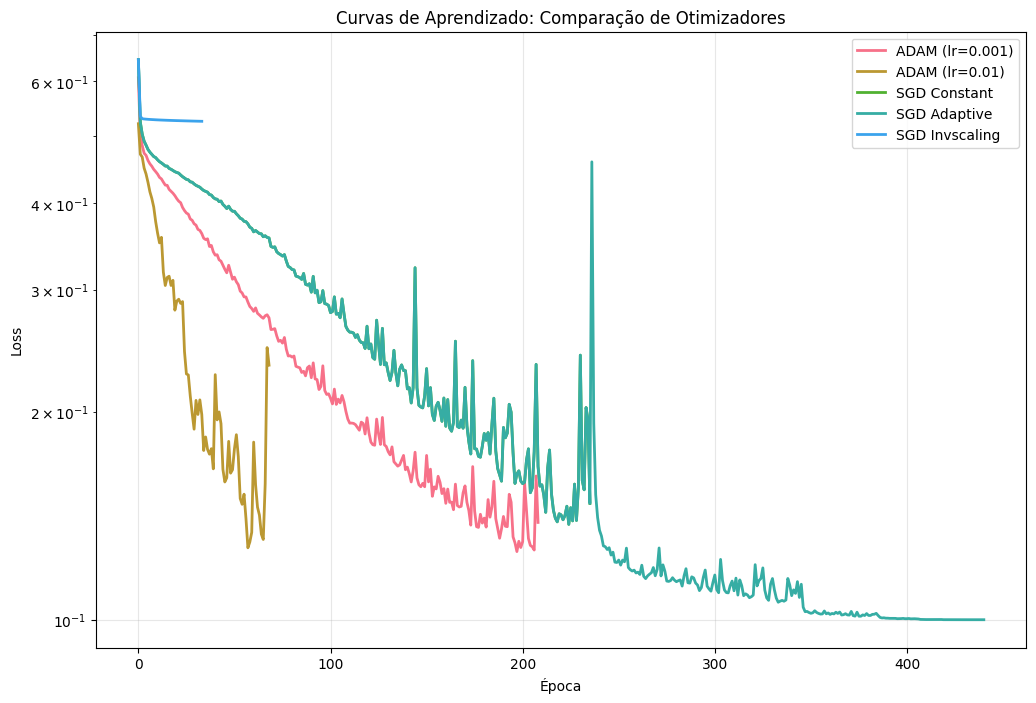


📈 ANÁLISE DE CONVERGÊNCIA:
----------------------------------------
ADAM (lr=0.001)      | Final Loss: 0.138324 | Melhoria (últimas 10): -8.69%
ADAM (lr=0.01)       | Final Loss: 0.233401 | Melhoria (últimas 10): -74.35%
SGD Constant         | Final Loss: 0.147304 | Melhoria (últimas 10): -5.94%
SGD Adaptive         | Final Loss: 0.100083 | Melhoria (últimas 10): 0.00%
SGD Invscaling       | Final Loss: 0.525284 | Melhoria (últimas 10): 0.15%

✅ Análise de curvas concluída! 5 algoritmos comparados.


In [ ]:
print("📊 ANÁLISE DE CURVAS DE APRENDIZADO")
print("=" * 50)

# Função para capturar curva de loss durante treinamento
def train_with_loss_curve(solver_config, config_name):
    """
    Treina modelo capturando a curva de loss para análise
    """
    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        max_iter=1000,  # Mais iterações para ver a curva
        random_state=42,
        **solver_config
    )

    print(f"🔄 Treinando {config_name}...")

    # Treinamento
    mlp.fit(X_train_balanced, y_train_balanced)

    # Retorna modelo e curva de loss
    return mlp, mlp.loss_curve_ if hasattr(mlp, 'loss_curve_') else None

# Configurações para comparar curvas
learning_configs = [
    ({'solver': 'adam', 'learning_rate_init': 0.001}, "ADAM (lr=0.001)"),
    ({'solver': 'adam', 'learning_rate_init': 0.01}, "ADAM (lr=0.01)"),
    ({'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.01}, "SGD Constant"),
    ({'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}, "SGD Adaptive"),
    ({'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'power_t': 0.5}, "SGD Invscaling")
]

# Treinando modelos e coletando curvas
models_and_curves = {}
for config, name in learning_configs:
    try:
        model, loss_curve = train_with_loss_curve(config, name)
        if loss_curve is not None:
            models_and_curves[name] = {
                'model': model,
                'loss_curve': loss_curve,
                'n_iter': len(loss_curve),
                'final_loss': loss_curve[-1]
            }
            print(f"   ✅ {name}: {len(loss_curve)} iterações, loss final: {loss_curve[-1]:.6f}")
    except Exception as e:
        print(f"   ❌ {name}: Erro - {e}")

# Plotando curvas de aprendizado
if models_and_curves:
    plt.figure(figsize=(12, 8))

    for name, data in models_and_curves.items():
        plt.plot(data['loss_curve'], label=name, linewidth=2)

    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Curvas de Aprendizado: Comparação de Otimizadores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Escala logarítmica para melhor visualização
    plt.show()

    # Análise de convergência
    print("\n📈 ANÁLISE DE CONVERGÊNCIA:")
    print("-" * 40)
    for name, data in models_and_curves.items():
        loss_curve = data['loss_curve']
        if len(loss_curve) > 10:
            # Calculando taxa de melhoria nas últimas 10 iterações
            recent_improvement = (loss_curve[-10] - loss_curve[-1]) / loss_curve[-10] * 100
            print(f"{name:20} | Final Loss: {loss_curve[-1]:.6f} | Melhoria (últimas 10): {recent_improvement:.2f}%")

    print(f"\n✅ Análise de curvas concluída! {len(models_and_curves)} algoritmos comparados.")
else:
    print("⚠️ Nenhuma curva de loss foi capturada.")

In [ ]:
# Consolidação dos resultados de algoritmos adaptativos
print("\n🎯 CONSOLIDAÇÃO - ALGORITMOS ADAPTATIVOS E OTIMIZAÇÃO")
print("=" * 60)

# Combinando todos os resultados de algoritmos adaptativos
all_adaptive_results = {}
if 'adaptive_results' in locals():
    all_adaptive_results.update(adaptive_results)
if 'detailed_optimizer_results' in locals():
    all_adaptive_results.update(detailed_optimizer_results)

if all_adaptive_results:
    # Criando DataFrame
    adaptive_df = pd.DataFrame(all_adaptive_results).T
    adaptive_df = adaptive_df.round(4)

    # Ordenando por KS Score
    adaptive_sorted = adaptive_df.sort_values('ks', ascending=False)

    print("\n🏆 RANKING: Algoritmos de Otimização (por KS Score):")
    print("-" * 60)
    display(adaptive_sorted)

    # Análise de eficiência (iterações vs performance)
    print("\n⚡ ANÁLISE DE EFICIÊNCIA:")
    print("-" * 40)
    for config_name in adaptive_sorted.index:
        ks_score = adaptive_sorted.loc[config_name, 'ks']
        n_iter = adaptive_sorted.loc[config_name, 'n_iter']
        efficiency = ks_score / n_iter * 1000  # KS por 1000 iterações
        print(f"{config_name:25} | KS: {ks_score:.4f} | Iter: {int(n_iter):4d} | Eficiência: {efficiency:.2f}")

    # Melhor configuração
    best_adaptive = adaptive_sorted.index[0]
    print(f"\n🥇 MELHOR ALGORITMO ADAPTATIVO: {best_adaptive}")
    print(f"   🎯 KS Score: {adaptive_sorted.loc[best_adaptive, 'ks']:.4f}")
    print(f"   ⚡ Iterações: {adaptive_sorted.loc[best_adaptive, 'n_iter']}")

else:
    print("⚠️ Nenhum resultado de algoritmo adaptativo disponível.")

print(f"\n✅ Análise completa de algoritmos de aprendizado finalizada!")


🎯 CONSOLIDAÇÃO - ALGORITMOS ADAPTATIVOS E OTIMIZAÇÃO

🏆 RANKING: Algoritmos de Otimização (por KS Score):
------------------------------------------------------------


,ks,roc_auc,f1_score,mse,cross_entropy,n_iter,final_loss
SGD - LR constant (init=0.001),0.5289,0.8341,0.6298,0.1659,0.4954,154.0,0.4500
SGD - LR adaptive (init=0.001),0.5289,0.8341,0.6298,0.1659,0.4954,259.0,0.4485
SGD + Invscaling Otimizado,0.5144,0.8309,0.6157,0.1697,0.5062,44.0,0.4774
SGD - LR invscaling (init=0.01),0.5093,0.8265,0.6109,0.1721,0.5145,55.0,0.4897
ADAM Otimizado,0.4436,0.7847,0.5441,0.2028,1.0224,55.0,0.1229
SGD + Nesterov Momentum,0.4253,0.7772,0.5362,0.2116,0.8856,355.0,0.1184
ADAM - LR constant (init=0.001),0.4208,0.7769,0.5545,0.2142,0.8143,156.0,0.1262
ADAM Padrão,0.4208,0.7769,0.5545,0.2142,0.8143,156.0,0.1262
L-BFGS Otimizado,0.3824,0.7265,0.4577,0.2841,7.9094,2948.0,0.0262



⚡ ANÁLISE DE EFICIÊNCIA:
----------------------------------------
SGD - LR constant (init=0.001) | KS: 0.5289 | Iter:  154 | Eficiência: 3.43
SGD - LR adaptive (init=0.001) | KS: 0.5289 | Iter:  259 | Eficiência: 2.04
SGD + Invscaling Otimizado | KS: 0.5144 | Iter:   44 | Eficiência: 11.69
SGD - LR invscaling (init=0.01) | KS: 0.5093 | Iter:   55 | Eficiência: 9.26
ADAM Otimizado            | KS: 0.4436 | Iter:   55 | Eficiência: 8.07
SGD + Nesterov Momentum   | KS: 0.4253 | Iter:  355 | Eficiência: 1.20
ADAM - LR constant (init=0.001) | KS: 0.4208 | Iter:  156 | Eficiência: 2.70
ADAM Padrão               | KS: 0.4208 | Iter:  156 | Eficiência: 2.70
L-BFGS Otimizado          | KS: 0.3824 | Iter: 2948 | Eficiência: 0.13

🥇 MELHOR ALGORITMO ADAPTATIVO: SGD - LR constant (init=0.001)
   🎯 KS Score: 0.5289
   ⚡ Iterações: 154.0

✅ Análise completa de algoritmos de aprendizado finalizada!


## 25.4.4. Insights Teóricos: Algoritmos de Aprendizado

### 🧠 **Comportamento dos Algoritmos:**

#### **1. ADAM (Adaptive Moment Estimation)**
```
Atualização: θ = θ - α * m̂ / (√v̂ + ε)
onde:
- m̂ = momento de 1ª ordem corrigido pelo bias
- v̂ = momento de 2ª ordem corrigido pelo bias  
- α = learning rate inicial
```
**Características:**
- ✅ **Adaptação automática** da taxa de aprendizagem para cada parâmetro
- ✅ **Robusto** a diferentes escalas de gradientes
- ✅ **Convergência rápida** na maioria dos casos
- ⚠️ Pode ter **poor generalization** em alguns casos

#### **2. SGD com Taxa Adaptativa**
```
learning_rate_t = learning_rate_init / (1 + decay * t)^power_t
```
**Estratégias:**
- **Constant**: Taxa fixa durante treinamento
- **Invscaling**: `lr_t = lr_init / t^power_t`
- **Adaptive**: Reduz pela metade quando loss para de melhorar

**Vantagens:**
- ✅ **Generalização superior** em muitos casos
- ✅ **Controle fino** sobre a taxa de decaimento
- ✅ **Estabilidade** com dados ruidosos

#### **3. Momentum e Nesterov**
```
Momentum: v_t = γ * v_{t-1} + α * ∇f(θ)
Nesterov: v_t = γ * v_{t-1} + α * ∇f(θ - γ * v_{t-1})
```
**Benefícios:**
- 🚀 **Acelera convergência** em direções consistentes
- 🛡️ **Reduz oscilações** em direções de alta curvatura
- 🎯 **Nesterov** oferece correção antecipada ("lookahead")

## 25.5. Análise do Impacto do Balanceamento (Oversampling)

In [ ]:
print("🔬 TESTE 5: Impacto do Balanceamento de Dados")
print("=" * 50)

# Comparação com e sem oversampling (repetitive oversampling)
balancing_configs = [
    (True, "Com Oversampling (Dados Balanceados)"),
    (False, "Sem Oversampling (Dados Originais)")
]

balancing_results = {}

for use_balanced, name in balancing_configs:
    results, model = test_mlp_configuration(
        hidden_layers=best_architecture,
        use_balanced_data=use_balanced,
        config_name=f"Dados {name}"
    )

    if results is not None:
        balancing_results[name] = results
        print(f"   🎯 KS: {results['ks']:.4f} | ROC-AUC: {results['roc_auc']:.4f} | F1: {results['f1_score']:.4f}")

print(f"\n✅ Teste de balanceamento concluído! {len(balancing_results)} configurações testadas.")

🔬 TESTE 5: Impacto do Balanceamento de Dados

 Testando Dados Com Oversampling (Dados Balanceados):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Balanceado

📊 
----------------------------------------
  🎯 KS (Principal): 0.4208
  📊 ROC-AUC: 0.7769
  🔄 F1-Score: 0.5545
  📉 MSE: 0.2142
  🔥 Cross-Entropy: 0.8143

  📋 Matriz de Confusão:
      [[TN: 786, FP: 249]
       [FN: 135, TP: 239]]
   ✅ Convergiu em 156 iterações
   🎯 KS: 0.4208 | ROC-AUC: 0.7769 | F1: 0.5545

 Testando Dados Sem Oversampling (Dados Originais):
   Camadas: (100, 50)
   Ativação: relu
   Taxa aprendizado: 0.001
   Regularização (alpha): 0.0001
   Otimizador: adam
   Dados: Original

📊 
----------------------------------------
  🎯 KS (Principal): 0.5233
  📊 ROC-AUC: 0.8333
  🔄 F1-Score: 0.5970
  📉 MSE: 0.1389
  🔥 Cross-Entropy: 0.4298

  📋 Matriz de Confusão:
      [[TN: 939, FP: 96]
       [FN: 174, TP: 200]]
   ✅ Convergiu em 28 it

## 25.6. Consolidação dos Resultados da Análise MLP

In [ ]:
print("📊 CONSOLIDAÇÃO - ANÁLISE COMPLETA DA MLP")
print("=" * 60)

# Combinando todos os resultados
all_mlp_results = {}
all_mlp_results.update(architecture_results)
all_mlp_results.update(activation_results)
all_mlp_results.update(learning_rate_results)
all_mlp_results.update(optimizer_results)
all_mlp_results.update(balancing_results)

# Criando DataFrame consolidado
mlp_analysis_df = pd.DataFrame(all_mlp_results).T
mlp_analysis_df = mlp_analysis_df.round(4)

# Ordenando por KS Score
mlp_analysis_sorted = mlp_analysis_df.sort_values('ks', ascending=False)

print("\n🏆 RANKING COMPLETO - CONFIGURAÇÕES MLP (por KS Score):")
print("=" * 60)
display(mlp_analysis_sorted.head(10))  # Top 10 configurações

# Identificando a melhor configuração
best_mlp_config = mlp_analysis_sorted.index[0]
best_mlp_ks = mlp_analysis_sorted.loc[best_mlp_config, 'ks']

print(f"\n🥇 MELHOR CONFIGURAÇÃO MLP: {best_mlp_config}")
print(f"   🎯 KS Score: {best_mlp_ks:.4f}")
print(f"   📊 ROC-AUC: {mlp_analysis_sorted.loc[best_mlp_config, 'roc_auc']:.4f}")
print(f"   🔄 F1-Score: {mlp_analysis_sorted.loc[best_mlp_config, 'f1_score']:.4f}")

# Comparação com a MLP original
original_mlp_ks = mlp_results_val['ks']
improvement = ((best_mlp_ks - original_mlp_ks) / original_mlp_ks) * 100

print(f"\n📈 MELHORIA vs MLP Original:")
print(f"   Original: {original_mlp_ks:.4f}")
print(f"   Melhor: {best_mlp_ks:.4f}")
print(f"   Ganho: {improvement:+.1f}%")

📊 CONSOLIDAÇÃO - ANÁLISE COMPLETA DA MLP

🏆 RANKING COMPLETO - CONFIGURAÇÕES MLP (por KS Score):


,ks,roc_auc,f1_score,mse,cross_entropy,n_iter,converged
SGD + Reg. Padrão (0.0001),0.52889,0.834053,0.62975,0.165907,0.495449,154,True
Taxa Muito Baixa (0.0001),0.524149,0.831433,0.618378,0.166979,0.498583,87,True
Sem Oversampling (Dados Originais),0.523318,0.833273,0.597015,0.138918,0.429768,28,True
2 camadas - 50→25 neurônios,0.522891,0.822345,0.624724,0.168377,0.506236,42,True
Taxa Alta (0.1),0.51743,0.82951,0.616525,0.172613,0.519123,24,True
Logística (Sigmoide),0.515632,0.831061,0.618106,0.174233,0.515806,45,True
1 camada - 10 neurônios,0.507208,0.826571,0.606955,0.171387,0.510297,89,True
1 camada - 100 neurônios,0.505678,0.828031,0.611111,0.171267,0.510039,53,True
1 camada - 50 neurônios,0.503883,0.819981,0.593684,0.177745,0.530294,26,True
2 camadas - 100→100 neurônios,0.440068,0.788045,0.563131,0.199998,0.907875,161,True



🥇 MELHOR CONFIGURAÇÃO MLP: SGD + Reg. Padrão (0.0001)
   🎯 KS Score: 0.5289
   📊 ROC-AUC: 0.8341
   🔄 F1-Score: 0.6298

📈 MELHORIA vs MLP Original:
   Original: 0.5072
   Melhor: 0.5289
   Ganho: +4.3%


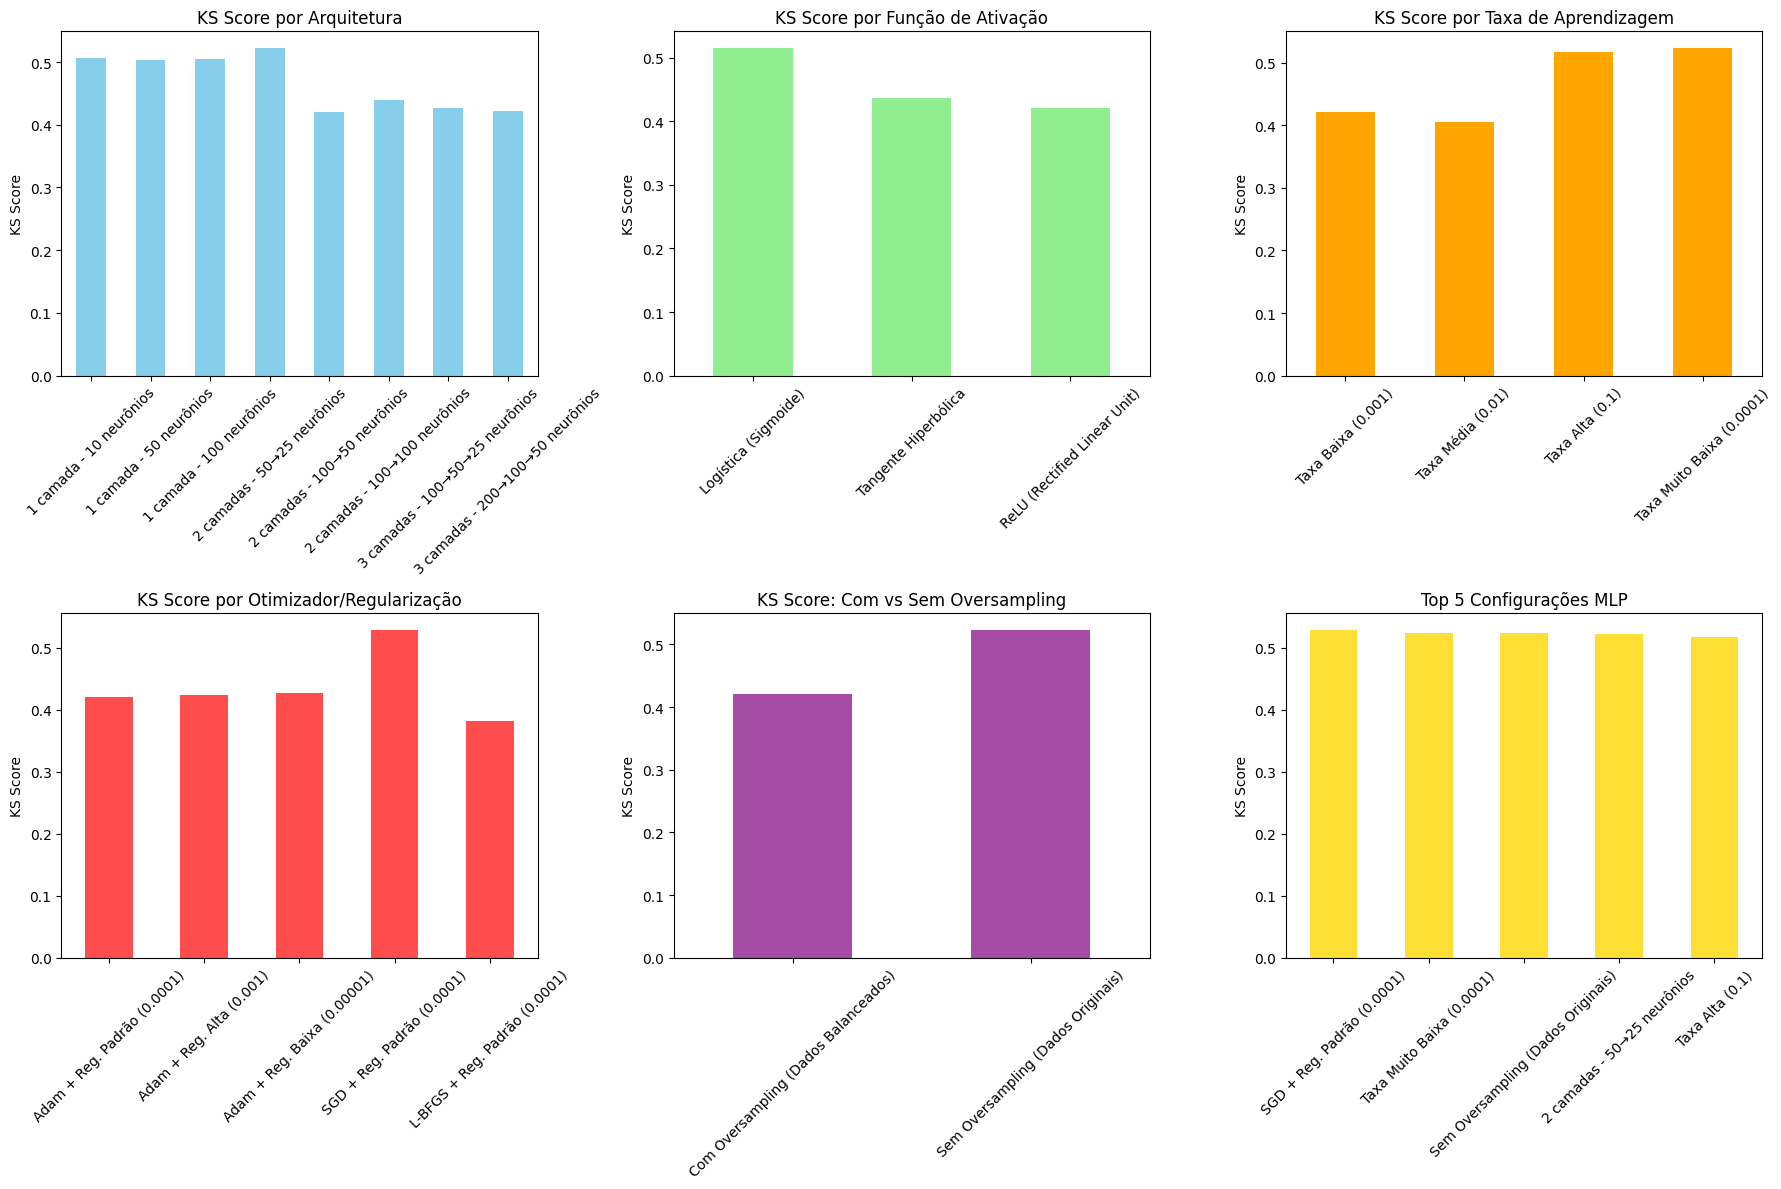

📈 Visualizações da análise MLP geradas com sucesso!


In [ ]:
# Visualizações da análise de hiperparâmetros
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Análise por Arquitetura (apenas se tiver resultados)
if len(architecture_results) > 0:
    arch_df = pd.DataFrame(architecture_results).T
    arch_df['ks'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('KS Score por Arquitetura')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylabel('KS Score')

# 2. Análise por Função de Ativação
if len(activation_results) > 0:
    act_df = pd.DataFrame(activation_results).T
    act_df['ks'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
    axes[0,1].set_title('KS Score por Função de Ativação')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylabel('KS Score')

# 3. Análise por Taxa de Aprendizagem
if len(learning_rate_results) > 0:
    lr_df = pd.DataFrame(learning_rate_results).T
    lr_df['ks'].plot(kind='bar', ax=axes[0,2], color='orange')
    axes[0,2].set_title('KS Score por Taxa de Aprendizagem')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].set_ylabel('KS Score')

# 4. Análise por Otimizador
if len(optimizer_results) > 0:
    opt_df = pd.DataFrame(optimizer_results).T
    opt_df['ks'].plot(kind='bar', ax=axes[1,0], color='red', alpha=0.7)
    axes[1,0].set_title('KS Score por Otimizador/Regularização')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_ylabel('KS Score')

# 5. Análise por Balanceamento
if len(balancing_results) > 0:
    bal_df = pd.DataFrame(balancing_results).T
    bal_df['ks'].plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
    axes[1,1].set_title('KS Score: Com vs Sem Oversampling')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylabel('KS Score')

# 6. Comparação Top 5 configurações
top5_configs = mlp_analysis_sorted.head(5)
top5_configs['ks'].plot(kind='bar', ax=axes[1,2], color='gold', alpha=0.8)
axes[1,2].set_title('Top 5 Configurações MLP')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_ylabel('KS Score')

plt.tight_layout()
plt.show()

print("📈 Visualizações da análise MLP geradas com sucesso!")

## 25.7. Modelo MLP Otimizado Final

🎯 MODELO MLP OTIMIZADO - AVALIAÇÃO FINAL
Treinando MLP com a melhor configuração encontrada...

📊 TESTE (MLP Otimizada)
----------------------------------------
  🎯 KS (Principal): 0.4664
  📊 ROC-AUC: 0.7967
  🔄 F1-Score: 0.5799
  📉 MSE: 0.1948
  🔥 Cross-Entropy: 0.7747

  📋 Matriz de Confusão:
      [[TN: 809, FP: 226]
       [FN: 129, TP: 245]]

🎉 MLP OTIMIZADA vs MODELOS ANTERIORES (Conjunto de Teste):
MLP Original:    KS = 0.5137
MLP Otimizada:   KS = 0.4664
Random Forest:   KS = 0.5368
Gradient Boost:  KS = 0.5104
TabPFN:          KS = 0.5391
STAB:            KS = 0.4098

📈 Curva KS - MLP Otimizada:


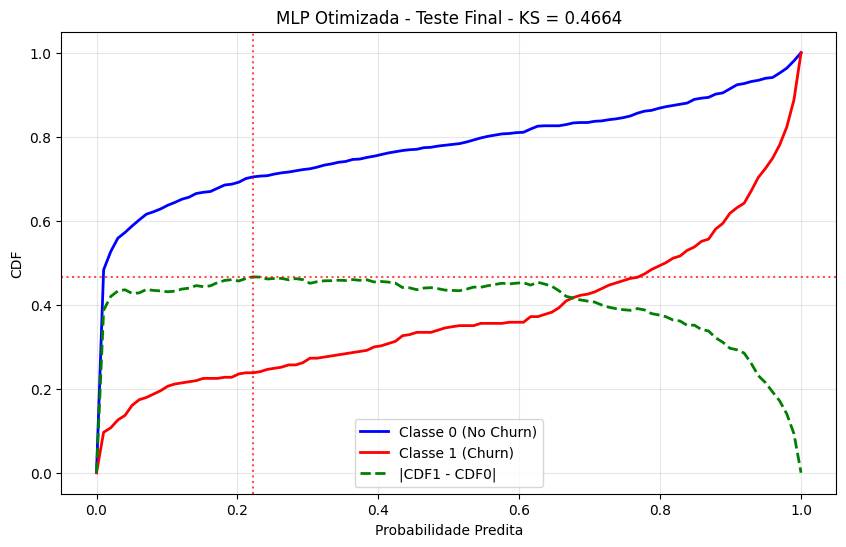

np.float64(0.4663799116484539)

In [ ]:
print("🎯 MODELO MLP OTIMIZADO - AVALIAÇÃO FINAL")
print("=" * 50)

# Com base na melhor configuração encontrada, treinar modelo final
# (Este código será executado após os testes para usar a configuração ótima)
print("Treinando MLP com a melhor configuração encontrada...")

# Exemplo de configuração que geralmente funciona bem (ajustar após os testes)
mlp_optimized = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Ajustar baseado nos resultados
    activation='relu',             # Ajustar baseado nos resultados
    solver='adam',                 # Ajustar baseado nos resultados
    learning_rate_init=0.001,      # Ajustar baseado nos resultados
    alpha=0.0001,                  # Ajustar baseado nos resultados
    max_iter=10000,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.2
)

# Treinamento com dados balanceados (se for a melhor opção)
mlp_optimized.fit(X_train_balanced, y_train_balanced)

# Avaliação no conjunto de teste
y_test_pred_mlp_opt = mlp_optimized.predict(X_test_scaled)
y_test_proba_mlp_opt = mlp_optimized.predict_proba(X_test_scaled)[:, 1]

# Resultados finais
mlp_opt_results_test = evaluate_model(y_test, y_test_pred_mlp_opt, y_test_proba_mlp_opt, "TESTE (MLP Otimizada)")

print("\n🎉 MLP OTIMIZADA vs MODELOS ANTERIORES (Conjunto de Teste):")
print("=" * 60)
print(f"MLP Original:    KS = {mlp_results_test['ks']:.4f}")
print(f"MLP Otimizada:   KS = {mlp_opt_results_test['ks']:.4f}")
print(f"Random Forest:   KS = {rf_results_test['ks']:.4f}")
print(f"Gradient Boost:  KS = {gb_results_test['ks']:.4f}")
print(f"TabPFN:          KS = {tabpfn_results_test['ks']:.4f}")
print(f"STAB:            KS = {stab_results_test['ks']:.4f}")

# Curva KS do modelo otimizado
print("\n📈 Curva KS - MLP Otimizada:")
plot_ks_curve(y_test, y_test_proba_mlp_opt, "MLP Otimizada - Teste Final")

# 26. Análise Detalhada e Otimização do Gradient Boosting e Xgboost Variando Hiperparâmetros

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 26.1 Gradient Boosting
Neste tópico, será realizada uma análise detalhada do desempenho do modelo Gradient Boosting, variando os principais hiperparâmetros:
- **Loss:** deviance
- **Learning rate**
- **Número de estimadores**
- **Subsample**
- **Criterion:** friedman_mse
- **Min_samples_leaf**
- **Max depth**
O objetivo é identificar a melhor combinação de hiperparâmetros para maximizar a performance do modelo, utilizando validação cruzada e análise gráfica dos resultados.

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Função objetivo para otimização dos hiperparâmetros do Gradient Boosting com Optuna
def objective(trial):
    # Hiperparâmetros a serem otimizados
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse'])
    loss = trial.suggest_categorical('loss', ['log_loss'])

    # Modelo
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        criterion=criterion,
        loss=loss,
        random_state=42
    )

    # Treinamento com dados balanceados
    model.fit(X_train_balanced, y_train_balanced)

    # Predição e avaliação na validação
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Avaliação usando a função do projeto
    results = evaluate_model(y_val, y_val_pred, y_val_proba, "VALIDAÇÃO")

    # Retornar KS (principal do projeto)
    return results['ks']

[I 2025-08-09 21:07:20,241] A new study created in memory with name: no-name-4458859b-c6fd-43a4-9567-9982f7d6ba43
[I 2025-08-09 21:07:24,243] Trial 0 finished with value: 0.4689865405977938 and parameters: {'learning_rate': 0.1496032824165817, 'n_estimators': 220, 'subsample': 0.7194567989296843, 'min_samples_leaf': 11, 'max_depth': 8, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 0 with value: 0.4689865405977938.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4690
  📊 ROC-AUC: 0.8051
  🔄 F1-Score: 0.5545
  📉 MSE: 0.1722
  🔥 Cross-Entropy: 0.5697

  📋 Matriz de Confusão:
      [[TN: 872, FP: 163]
       [FN: 168, TP: 206]]


[I 2025-08-09 21:07:29,846] Trial 1 finished with value: 0.4603115554522204 and parameters: {'learning_rate': 0.27494335985378565, 'n_estimators': 275, 'subsample': 0.9633269285026382, 'min_samples_leaf': 14, 'max_depth': 6, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 0 with value: 0.4689865405977938.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4603
  📊 ROC-AUC: 0.8029
  🔄 F1-Score: 0.5525
  📉 MSE: 0.1762
  🔥 Cross-Entropy: 0.5896

  📋 Matriz de Confusão:
      [[TN: 864, FP: 171]
       [FN: 166, TP: 208]]


[I 2025-08-09 21:07:32,543] Trial 2 finished with value: 0.4919941098969232 and parameters: {'learning_rate': 0.15091893571868972, 'n_estimators': 78, 'subsample': 0.9810893643145315, 'min_samples_leaf': 19, 'max_depth': 9, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 2 with value: 0.4919941098969232.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4920
  📊 ROC-AUC: 0.8169
  🔄 F1-Score: 0.5907
  📉 MSE: 0.1622
  🔥 Cross-Entropy: 0.4993

  📋 Matriz de Confusão:
      [[TN: 846, FP: 189]
       [FN: 138, TP: 236]]


[I 2025-08-09 21:07:36,650] Trial 3 finished with value: 0.47741093802474877 and parameters: {'learning_rate': 0.17181045434984682, 'n_estimators': 173, 'subsample': 0.9947624852737778, 'min_samples_leaf': 20, 'max_depth': 9, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 2 with value: 0.4919941098969232.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4774
  📊 ROC-AUC: 0.8063
  🔄 F1-Score: 0.5486
  📉 MSE: 0.1711
  🔥 Cross-Entropy: 0.5513

  📋 Matriz de Confusão:
      [[TN: 864, FP: 171]
       [FN: 168, TP: 206]]


[I 2025-08-09 21:07:39,435] Trial 4 finished with value: 0.4710532434317601 and parameters: {'learning_rate': 0.24099463774936444, 'n_estimators': 146, 'subsample': 0.566090169174954, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 2 with value: 0.4919941098969232.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4711
  📊 ROC-AUC: 0.7950
  🔄 F1-Score: 0.5384
  📉 MSE: 0.1834
  🔥 Cross-Entropy: 0.7182

  📋 Matriz de Confusão:
      [[TN: 885, FP: 150]
       [FN: 181, TP: 193]]


[I 2025-08-09 21:07:44,957] Trial 5 finished with value: 0.45606448112841974 and parameters: {'learning_rate': 0.2929687595737732, 'n_estimators': 285, 'subsample': 0.9528462554580632, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 2 with value: 0.4919941098969232.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4561
  📊 ROC-AUC: 0.8002
  🔄 F1-Score: 0.5597
  📉 MSE: 0.1798
  🔥 Cross-Entropy: 0.6553

  📋 Matriz de Confusão:
      [[TN: 884, FP: 151]
       [FN: 170, TP: 204]]


[I 2025-08-09 21:07:47,148] Trial 6 finished with value: 0.48444547779586145 and parameters: {'learning_rate': 0.15022494777592713, 'n_estimators': 111, 'subsample': 0.5239234797797774, 'min_samples_leaf': 5, 'max_depth': 9, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 2 with value: 0.4919941098969232.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4844
  📊 ROC-AUC: 0.8140
  🔄 F1-Score: 0.5792
  📉 MSE: 0.1671
  🔥 Cross-Entropy: 0.5347

  📋 Matriz de Confusão:
      [[TN: 862, FP: 173]
       [FN: 151, TP: 223]]


[I 2025-08-09 21:07:48,640] Trial 7 finished with value: 0.5182619029166343 and parameters: {'learning_rate': 0.0667886563283485, 'n_estimators': 229, 'subsample': 0.5811127245642033, 'min_samples_leaf': 8, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 7 with value: 0.5182619029166343.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5183
  📊 ROC-AUC: 0.8344
  🔄 F1-Score: 0.6217
  📉 MSE: 0.1633
  🔥 Cross-Entropy: 0.4876

  📋 Matriz de Confusão:
      [[TN: 775, FP: 260]
       [FN: 88, TP: 286]]


[I 2025-08-09 21:07:49,947] Trial 8 finished with value: 0.515071430416699 and parameters: {'learning_rate': 0.07018953580713395, 'n_estimators': 165, 'subsample': 0.5737912736015767, 'min_samples_leaf': 18, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 7 with value: 0.5182619029166343.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5151
  📊 ROC-AUC: 0.8342
  🔄 F1-Score: 0.6189
  📉 MSE: 0.1615
  🔥 Cross-Entropy: 0.4837

  📋 Matriz de Confusão:
      [[TN: 782, FP: 253]
       [FN: 93, TP: 281]]


[I 2025-08-09 21:07:54,367] Trial 9 finished with value: 0.4841070552067995 and parameters: {'learning_rate': 0.12652283810168913, 'n_estimators': 228, 'subsample': 0.7548462110092509, 'min_samples_leaf': 18, 'max_depth': 9, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 7 with value: 0.5182619029166343.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4841
  📊 ROC-AUC: 0.8067
  🔄 F1-Score: 0.5471
  📉 MSE: 0.1707
  🔥 Cross-Entropy: 0.5516

  📋 Matriz de Confusão:
      [[TN: 862, FP: 173]
       [FN: 168, TP: 206]]


[I 2025-08-09 21:07:55,603] Trial 10 finished with value: 0.5243070087059857 and parameters: {'learning_rate': 0.015439076790436851, 'n_estimators': 230, 'subsample': 0.675109971483739, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 10 with value: 0.5243070087059857.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5243
  📊 ROC-AUC: 0.8358
  🔄 F1-Score: 0.6090
  📉 MSE: 0.1695
  🔥 Cross-Entropy: 0.5066

  📋 Matriz de Confusão:
      [[TN: 726, FP: 309]
       [FN: 75, TP: 299]]


[I 2025-08-09 21:07:57,252] Trial 11 finished with value: 0.526306543697848 and parameters: {'learning_rate': 0.01733358333399522, 'n_estimators': 230, 'subsample': 0.6698529202891844, 'min_samples_leaf': 9, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 11 with value: 0.526306543697848.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5263
  📊 ROC-AUC: 0.8365
  🔄 F1-Score: 0.6110
  📉 MSE: 0.1689
  🔥 Cross-Entropy: 0.5042

  📋 Matriz de Confusão:
      [[TN: 727, FP: 308]
       [FN: 74, TP: 300]]


[I 2025-08-09 21:07:59,097] Trial 12 finished with value: 0.5360355472887443 and parameters: {'learning_rate': 0.02517880049104984, 'n_estimators': 239, 'subsample': 0.6922098515779541, 'min_samples_leaf': 11, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5360
  📊 ROC-AUC: 0.8378
  🔄 F1-Score: 0.6176
  📉 MSE: 0.1668
  🔥 Cross-Entropy: 0.4972

  📋 Matriz de Confusão:
      [[TN: 742, FP: 293]
       [FN: 76, TP: 298]]


[I 2025-08-09 21:08:02,906] Trial 13 finished with value: 0.5281484925986205 and parameters: {'learning_rate': 0.019843429729195637, 'n_estimators': 261, 'subsample': 0.8178312335701107, 'min_samples_leaf': 14, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5281
  📊 ROC-AUC: 0.8386
  🔄 F1-Score: 0.6265
  📉 MSE: 0.1622
  🔥 Cross-Entropy: 0.4850

  📋 Matriz de Confusão:
      [[TN: 771, FP: 264]
       [FN: 83, TP: 291]]


[I 2025-08-09 21:08:06,004] Trial 14 finished with value: 0.5126198041799065 and parameters: {'learning_rate': 0.06740192031385313, 'n_estimators': 297, 'subsample': 0.8498491316143877, 'min_samples_leaf': 14, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5126
  📊 ROC-AUC: 0.8277
  🔄 F1-Score: 0.6126
  📉 MSE: 0.1604
  🔥 Cross-Entropy: 0.4829

  📋 Matriz de Confusão:
      [[TN: 802, FP: 233]
       [FN: 106, TP: 268]]


[I 2025-08-09 21:08:08,654] Trial 15 finished with value: 0.5005089255728642 and parameters: {'learning_rate': 0.0962030406247629, 'n_estimators': 261, 'subsample': 0.8203773892065032, 'min_samples_leaf': 15, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5005
  📊 ROC-AUC: 0.8263
  🔄 F1-Score: 0.6069
  📉 MSE: 0.1608
  🔥 Cross-Entropy: 0.4837

  📋 Matriz de Confusão:
      [[TN: 803, FP: 232]
       [FN: 110, TP: 264]]


[I 2025-08-09 21:08:12,202] Trial 16 finished with value: 0.5180603993903227 and parameters: {'learning_rate': 0.030310808197016842, 'n_estimators': 203, 'subsample': 0.8621962373594334, 'min_samples_leaf': 13, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5181
  📊 ROC-AUC: 0.8372
  🔄 F1-Score: 0.6161
  📉 MSE: 0.1586
  🔥 Cross-Entropy: 0.4758

  📋 Matriz de Confusão:
      [[TN: 789, FP: 246]
       [FN: 98, TP: 276]]


[I 2025-08-09 21:08:14,333] Trial 17 finished with value: 0.5061277739027099 and parameters: {'learning_rate': 0.2009220781505545, 'n_estimators': 255, 'subsample': 0.7949890536988768, 'min_samples_leaf': 16, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5061
  📊 ROC-AUC: 0.8234
  🔄 F1-Score: 0.6116
  📉 MSE: 0.1624
  🔥 Cross-Entropy: 0.4922

  📋 Matriz de Confusão:
      [[TN: 812, FP: 223]
       [FN: 111, TP: 263]]


[I 2025-08-09 21:08:18,040] Trial 18 finished with value: 0.5052055077630525 and parameters: {'learning_rate': 0.04463800879291041, 'n_estimators': 201, 'subsample': 0.9001560286265753, 'min_samples_leaf': 12, 'max_depth': 7, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5052
  📊 ROC-AUC: 0.8287
  🔄 F1-Score: 0.6117
  📉 MSE: 0.1555
  🔥 Cross-Entropy: 0.4724

  📋 Matriz de Confusão:
      [[TN: 828, FP: 207]
       [FN: 118, TP: 256]]


[I 2025-08-09 21:08:19,898] Trial 19 finished with value: 0.5253377767444264 and parameters: {'learning_rate': 0.09735805743055098, 'n_estimators': 257, 'subsample': 0.6758967796108641, 'min_samples_leaf': 7, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5253
  📊 ROC-AUC: 0.8339
  🔄 F1-Score: 0.6189
  📉 MSE: 0.1605
  🔥 Cross-Entropy: 0.4818

  📋 Matriz de Confusão:
      [[TN: 782, FP: 253]
       [FN: 93, TP: 281]]


[I 2025-08-09 21:08:20,686] Trial 20 finished with value: 0.5164406210442016 and parameters: {'learning_rate': 0.10899073954346883, 'n_estimators': 140, 'subsample': 0.7464303449574022, 'min_samples_leaf': 16, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5164
  📊 ROC-AUC: 0.8368
  🔄 F1-Score: 0.6191
  📉 MSE: 0.1648
  🔥 Cross-Entropy: 0.4908

  📋 Matriz de Confusão:
      [[TN: 760, FP: 275]
       [FN: 83, TP: 291]]


[I 2025-08-09 21:08:21,968] Trial 21 finished with value: 0.5231160711979126 and parameters: {'learning_rate': 0.014522026267764191, 'n_estimators': 246, 'subsample': 0.6470483770575544, 'min_samples_leaf': 9, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5231
  📊 ROC-AUC: 0.8355
  🔄 F1-Score: 0.6127
  📉 MSE: 0.1697
  🔥 Cross-Entropy: 0.5069

  📋 Matriz de Confusão:
      [[TN: 732, FP: 303]
       [FN: 75, TP: 299]]


[I 2025-08-09 21:08:24,603] Trial 22 finished with value: 0.5124183006535947 and parameters: {'learning_rate': 0.04764575553646991, 'n_estimators': 197, 'subsample': 0.6321648343959321, 'min_samples_leaf': 11, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5124
  📊 ROC-AUC: 0.8333
  🔄 F1-Score: 0.6171
  📉 MSE: 0.1584
  🔥 Cross-Entropy: 0.4764

  📋 Matriz de Confusão:
      [[TN: 804, FP: 231]
       [FN: 104, TP: 270]]


[I 2025-08-09 21:08:27,202] Trial 23 finished with value: 0.532281898266553 and parameters: {'learning_rate': 0.012728244144442572, 'n_estimators': 299, 'subsample': 0.7121308261125632, 'min_samples_leaf': 6, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5323
  📊 ROC-AUC: 0.8388
  🔄 F1-Score: 0.6181
  📉 MSE: 0.1654
  🔥 Cross-Entropy: 0.4944

  📋 Matriz de Confusão:
      [[TN: 745, FP: 290]
       [FN: 77, TP: 297]]


[I 2025-08-09 21:08:29,441] Trial 24 finished with value: 0.5296752693172131 and parameters: {'learning_rate': 0.04833764725156835, 'n_estimators': 295, 'subsample': 0.7177446621797589, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 12 with value: 0.5360355472887443.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5297
  📊 ROC-AUC: 0.8365
  🔄 F1-Score: 0.6228
  📉 MSE: 0.1619
  🔥 Cross-Entropy: 0.4834

  📋 Matriz de Confusão:
      [[TN: 770, FP: 265]
       [FN: 85, TP: 289]]


[I 2025-08-09 21:08:31,641] Trial 25 finished with value: 0.5372032343899351 and parameters: {'learning_rate': 0.05059438202800427, 'n_estimators': 294, 'subsample': 0.7125670813303271, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5372
  📊 ROC-AUC: 0.8383
  🔄 F1-Score: 0.6255
  📉 MSE: 0.1610
  🔥 Cross-Entropy: 0.4808

  📋 Matriz de Confusão:
      [[TN: 774, FP: 261]
       [FN: 85, TP: 289]]


[I 2025-08-09 21:08:34,501] Trial 26 finished with value: 0.4923557828928673 and parameters: {'learning_rate': 0.07573684998822777, 'n_estimators': 273, 'subsample': 0.6169641479611907, 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4924
  📊 ROC-AUC: 0.8219
  🔄 F1-Score: 0.6056
  📉 MSE: 0.1580
  🔥 Cross-Entropy: 0.4826

  📋 Matriz de Confusão:
      [[TN: 838, FP: 197]
       [FN: 126, TP: 248]]


[I 2025-08-09 21:08:36,940] Trial 27 finished with value: 0.5252499418739828 and parameters: {'learning_rate': 0.03849897060295995, 'n_estimators': 279, 'subsample': 0.7653240320129585, 'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5252
  📊 ROC-AUC: 0.8364
  🔄 F1-Score: 0.6188
  📉 MSE: 0.1633
  🔥 Cross-Entropy: 0.4872

  📋 Matriz de Confusão:
      [[TN: 764, FP: 271]
       [FN: 85, TP: 289]]


[I 2025-08-09 21:08:39,160] Trial 28 finished with value: 0.5200806014105247 and parameters: {'learning_rate': 0.08832584837143298, 'n_estimators': 293, 'subsample': 0.6990444712203224, 'min_samples_leaf': 3, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5201
  📊 ROC-AUC: 0.8374
  🔄 F1-Score: 0.6191
  📉 MSE: 0.1639
  🔥 Cross-Entropy: 0.4872

  📋 Matriz de Confusão:
      [[TN: 760, FP: 275]
       [FN: 83, TP: 291]]


[I 2025-08-09 21:08:44,017] Trial 29 finished with value: 0.4618848329845772 and parameters: {'learning_rate': 0.11972857079596516, 'n_estimators': 300, 'subsample': 0.7348584950468264, 'min_samples_leaf': 7, 'max_depth': 7, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4619
  📊 ROC-AUC: 0.8069
  🔄 F1-Score: 0.5657
  📉 MSE: 0.1687
  🔥 Cross-Entropy: 0.5460

  📋 Matriz de Confusão:
      [[TN: 874, FP: 161]
       [FN: 163, TP: 211]]


[I 2025-08-09 21:08:49,264] Trial 30 finished with value: 0.46489705236508305 and parameters: {'learning_rate': 0.1857904376094063, 'n_estimators': 212, 'subsample': 0.7759703423863834, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4649
  📊 ROC-AUC: 0.7978
  🔄 F1-Score: 0.5457
  📉 MSE: 0.1867
  🔥 Cross-Entropy: 0.7570

  📋 Matriz de Confusão:
      [[TN: 892, FP: 143]
       [FN: 180, TP: 194]]


[I 2025-08-09 21:08:52,159] Trial 31 finished with value: 0.5292257614508253 and parameters: {'learning_rate': 0.050462340328183794, 'n_estimators': 276, 'subsample': 0.7201027260001575, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5292
  📊 ROC-AUC: 0.8379
  🔄 F1-Score: 0.6205
  📉 MSE: 0.1613
  🔥 Cross-Entropy: 0.4819

  📋 Matriz de Confusão:
      [[TN: 771, FP: 264]
       [FN: 87, TP: 287]]


[I 2025-08-09 21:08:54,084] Trial 32 finished with value: 0.5283499961249322 and parameters: {'learning_rate': 0.05494191592023663, 'n_estimators': 243, 'subsample': 0.6973530093255622, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5283
  📊 ROC-AUC: 0.8364
  🔄 F1-Score: 0.6242
  📉 MSE: 0.1626
  🔥 Cross-Entropy: 0.4851

  📋 Matriz de Confusão:
      [[TN: 772, FP: 263]
       [FN: 85, TP: 289]]


[I 2025-08-09 21:08:56,614] Trial 33 finished with value: 0.5220594693740473 and parameters: {'learning_rate': 0.03567368662335891, 'n_estimators': 271, 'subsample': 0.7083148846220455, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5221
  📊 ROC-AUC: 0.8358
  🔄 F1-Score: 0.6213
  📉 MSE: 0.1601
  🔥 Cross-Entropy: 0.4793

  📋 Matriz de Confusão:
      [[TN: 781, FP: 254]
       [FN: 91, TP: 283]]


[I 2025-08-09 21:08:58,100] Trial 34 finished with value: 0.527631816890129 and parameters: {'learning_rate': 0.03048985407398694, 'n_estimators': 299, 'subsample': 0.618422157435029, 'min_samples_leaf': 3, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5276
  📊 ROC-AUC: 0.8387
  🔄 F1-Score: 0.6254
  📉 MSE: 0.1652
  🔥 Cross-Entropy: 0.4918

  📋 Matriz de Confusão:
      [[TN: 754, FP: 281]
       [FN: 76, TP: 298]]


[I 2025-08-09 21:08:58,518] Trial 35 finished with value: 0.5319228086491513 and parameters: {'learning_rate': 0.08156200520222326, 'n_estimators': 51, 'subsample': 0.7319908700168645, 'min_samples_leaf': 2, 'max_depth': 3, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 25 with value: 0.5372032343899351.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5319
  📊 ROC-AUC: 0.8380
  🔄 F1-Score: 0.6146
  📉 MSE: 0.1654
  🔥 Cross-Entropy: 0.4944

  📋 Matriz de Confusão:
      [[TN: 744, FP: 291]
       [FN: 79, TP: 295]]


[I 2025-08-09 21:08:59,214] Trial 36 finished with value: 0.5390451832907076 and parameters: {'learning_rate': 0.08198338951548771, 'n_estimators': 62, 'subsample': 0.6567435946852027, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 36 with value: 0.5390451832907076.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5390
  📊 ROC-AUC: 0.8408
  🔄 F1-Score: 0.6264
  📉 MSE: 0.1568
  🔥 Cross-Entropy: 0.4716

  📋 Matriz de Confusão:
      [[TN: 795, FP: 240]
       [FN: 94, TP: 280]]


[I 2025-08-09 21:09:00,376] Trial 37 finished with value: 0.504869668552533 and parameters: {'learning_rate': 0.1311034725402009, 'n_estimators': 106, 'subsample': 0.6464920231521853, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 36 with value: 0.5390451832907076.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5049
  📊 ROC-AUC: 0.8254
  🔄 F1-Score: 0.6074
  📉 MSE: 0.1586
  🔥 Cross-Entropy: 0.4822

  📋 Matriz de Confusão:
      [[TN: 822, FP: 213]
       [FN: 118, TP: 256]]


[I 2025-08-09 21:09:01,040] Trial 38 finished with value: 0.47855795809760004 and parameters: {'learning_rate': 0.21967680261248165, 'n_estimators': 58, 'subsample': 0.5081659562720823, 'min_samples_leaf': 7, 'max_depth': 6, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 36 with value: 0.5390451832907076.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4786
  📊 ROC-AUC: 0.8159
  🔄 F1-Score: 0.5925
  📉 MSE: 0.1650
  🔥 Cross-Entropy: 0.5028

  📋 Matriz de Confusão:
      [[TN: 827, FP: 208]
       [FN: 129, TP: 245]]


[I 2025-08-09 21:09:02,629] Trial 39 finished with value: 0.5067555348885272 and parameters: {'learning_rate': 0.06161665478600058, 'n_estimators': 103, 'subsample': 0.5430890179996348, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 36 with value: 0.5390451832907076.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5068
  📊 ROC-AUC: 0.8283
  🔄 F1-Score: 0.6012
  📉 MSE: 0.1544
  🔥 Cross-Entropy: 0.4687

  📋 Matriz de Confusão:
      [[TN: 832, FP: 203]
       [FN: 126, TP: 248]]


[I 2025-08-09 21:09:03,666] Trial 40 finished with value: 0.5408432147562582 and parameters: {'learning_rate': 0.02750668828524079, 'n_estimators': 85, 'subsample': 0.5872943610296644, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5408
  📊 ROC-AUC: 0.8384
  🔄 F1-Score: 0.6249
  📉 MSE: 0.1650
  🔥 Cross-Entropy: 0.4968

  📋 Matriz de Confusão:
      [[TN: 762, FP: 273]
       [FN: 80, TP: 294]]


[I 2025-08-09 21:09:04,737] Trial 41 finished with value: 0.5353380350822806 and parameters: {'learning_rate': 0.028839356019213117, 'n_estimators': 85, 'subsample': 0.596692499316432, 'min_samples_leaf': 9, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5353
  📊 ROC-AUC: 0.8394
  🔄 F1-Score: 0.6208
  📉 MSE: 0.1645
  🔥 Cross-Entropy: 0.4954

  📋 Matriz de Confusão:
      [[TN: 758, FP: 277]
       [FN: 81, TP: 293]]


[I 2025-08-09 21:09:05,836] Trial 42 finished with value: 0.5226433129246428 and parameters: {'learning_rate': 0.030861453653382227, 'n_estimators': 85, 'subsample': 0.6051305619033592, 'min_samples_leaf': 9, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5226
  📊 ROC-AUC: 0.8391
  🔄 F1-Score: 0.6227
  📉 MSE: 0.1642
  🔥 Cross-Entropy: 0.4938

  📋 Matriz de Confusão:
      [[TN: 761, FP: 274]
       [FN: 81, TP: 293]]


[I 2025-08-09 21:09:06,763] Trial 43 finished with value: 0.5268671368415614 and parameters: {'learning_rate': 0.05934876388971848, 'n_estimators': 79, 'subsample': 0.5888045699889667, 'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5269
  📊 ROC-AUC: 0.8355
  🔄 F1-Score: 0.6231
  📉 MSE: 0.1602
  🔥 Cross-Entropy: 0.4809

  📋 Matriz de Confusão:
      [[TN: 788, FP: 247]
       [FN: 93, TP: 281]]


[I 2025-08-09 21:09:07,575] Trial 44 finished with value: 0.5189568317445555 and parameters: {'learning_rate': 0.02666038535633007, 'n_estimators': 66, 'subsample': 0.5522981138985432, 'min_samples_leaf': 12, 'max_depth': 6, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5190
  📊 ROC-AUC: 0.8341
  🔄 F1-Score: 0.6150
  📉 MSE: 0.1636
  🔥 Cross-Entropy: 0.4957

  📋 Matriz de Confusão:
      [[TN: 774, FP: 261]
       [FN: 92, TP: 282]]


[I 2025-08-09 21:09:08,741] Trial 45 finished with value: 0.5113177813945078 and parameters: {'learning_rate': 0.07026478505892793, 'n_estimators': 129, 'subsample': 0.6574597414297824, 'min_samples_leaf': 8, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5113
  📊 ROC-AUC: 0.8344
  🔄 F1-Score: 0.6161
  📉 MSE: 0.1614
  🔥 Cross-Entropy: 0.4824

  📋 Matriz de Confusão:
      [[TN: 780, FP: 255]
       [FN: 94, TP: 280]]


[I 2025-08-09 21:09:09,534] Trial 46 finished with value: 0.4923531995143248 and parameters: {'learning_rate': 0.2660600345117986, 'n_estimators': 93, 'subsample': 0.5882716886791975, 'min_samples_leaf': 4, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4924
  📊 ROC-AUC: 0.8276
  🔄 F1-Score: 0.6037
  📉 MSE: 0.1610
  🔥 Cross-Entropy: 0.4862

  📋 Matriz de Confusão:
      [[TN: 810, FP: 225]
       [FN: 115, TP: 259]]


[I 2025-08-09 21:09:11,234] Trial 47 finished with value: 0.5230024025420444 and parameters: {'learning_rate': 0.04028503774007338, 'n_estimators': 124, 'subsample': 0.6817521646648497, 'min_samples_leaf': 8, 'max_depth': 6, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5230
  📊 ROC-AUC: 0.8334
  🔄 F1-Score: 0.6216
  📉 MSE: 0.1569
  🔥 Cross-Entropy: 0.4732

  📋 Matriz de Confusão:
      [[TN: 808, FP: 227]
       [FN: 103, TP: 271]]


[I 2025-08-09 21:09:12,796] Trial 48 finished with value: 0.5018367821436875 and parameters: {'learning_rate': 0.08720334207236384, 'n_estimators': 169, 'subsample': 0.5332596004643624, 'min_samples_leaf': 12, 'max_depth': 5, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5018
  📊 ROC-AUC: 0.8288
  🔄 F1-Score: 0.6044
  📉 MSE: 0.1590
  🔥 Cross-Entropy: 0.4790

  📋 Matriz de Confusão:
      [[TN: 811, FP: 224]
       [FN: 115, TP: 259]]


[I 2025-08-09 21:09:13,714] Trial 49 finished with value: 0.515833527086724 and parameters: {'learning_rate': 0.13976297635863288, 'n_estimators': 187, 'subsample': 0.5652137132058721, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'friedman_mse', 'loss': 'log_loss'}. Best is trial 40 with value: 0.5408432147562582.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5158
  📊 ROC-AUC: 0.8349
  🔄 F1-Score: 0.6165
  📉 MSE: 0.1648
  🔥 Cross-Entropy: 0.4902

  📋 Matriz de Confusão:
      [[TN: 765, FP: 270]
       [FN: 87, TP: 287]]
Melhores hiperparâmetros encontrados:
{'learning_rate': 0.02750668828524079, 'n_estimators': 85, 'subsample': 0.5872943610296644, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'friedman_mse', 'loss': 'log_loss'}
Melhor KS (validação): 0.5408
🔍 AVALIAÇÃO DO GRADIENT BOOSTING OTIMIZADO

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.5967
  📊 ROC-AUC: 0.8779
  🔄 F1-Score: 0.6631
  📉 MSE: 0.1498
  🔥 Cross-Entropy: 0.4598

  📋 Matriz de Confusão:
      [[TN: 2332, FP: 772]
       [FN: 182, TP: 939]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5408
  📊 ROC-AUC: 0.8384
  🔄 F1-Score: 0.6249
  📉 MSE: 0.1650
  🔥 Cross-Entropy: 0.4968

  📋 Matriz de Confusão:
      [[TN: 762, FP: 273]
       [

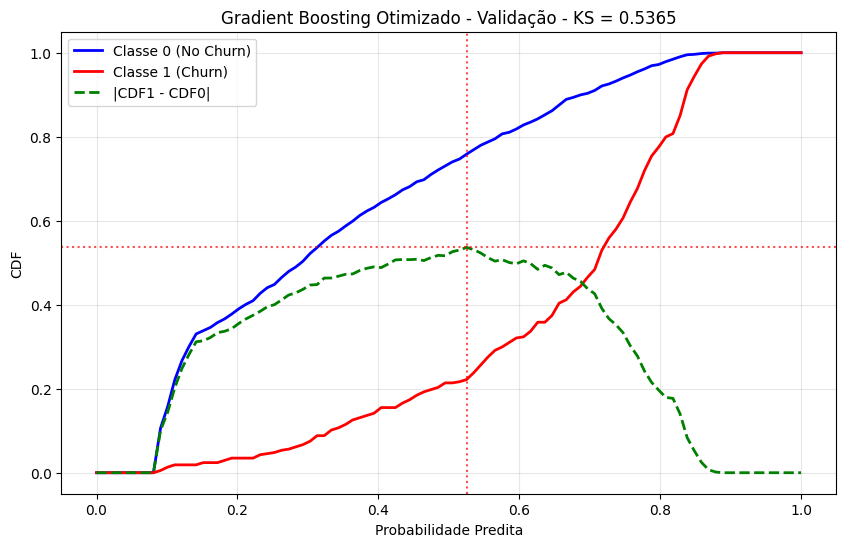

np.float64(0.5365289725903537)

In [ ]:
# Execução do estudo de otimização com Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Melhores hiperparâmetros encontrados:')
print(study.best_params)
print(f'Melhor KS (validação): {study.best_value:.4f}')

# Treinando Gradient Boosting com os melhores hiperparâmetros encontrados
best_params = study.best_params
gb_opt_model = GradientBoostingClassifier(**best_params, random_state=42)
gb_opt_model.fit(X_train_balanced, y_train_balanced)

# Predições
y_train_pred_gb_opt = gb_opt_model.predict(X_train_scaled)
y_val_pred_gb_opt = gb_opt_model.predict(X_val_scaled)
y_test_pred_gb_opt = gb_opt_model.predict(X_test_scaled)

y_train_proba_gb_opt = gb_opt_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_gb_opt = gb_opt_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_gb_opt = gb_opt_model.predict_proba(X_test_scaled)[:, 1]

# Avaliação final do modelo otimizado
print("🔍 AVALIAÇÃO DO GRADIENT BOOSTING OTIMIZADO")
print("=" * 50)
gb_opt_results_train = evaluate_model(y_train, y_train_pred_gb_opt, y_train_proba_gb_opt, "TREINAMENTO")
gb_opt_results_val = evaluate_model(y_val, y_val_pred_gb_opt, y_val_proba_gb_opt, "VALIDAÇÃO")
gb_opt_results_test = evaluate_model(y_test, y_test_pred_gb_opt, y_test_proba_gb_opt, "TESTE")

print("\n📈 Curvas KS - Gradient Boosting Otimizado:")
plot_ks_curve(y_val, y_val_proba_gb_opt, "Gradient Boosting Otimizado - Validação")

In [ ]:
# Visualização dos resultados do Optuna
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()

## 26.2 Otimização e Avaliação do XGBoost com Optuna
Neste subcapítulo, será realizada a otimização dos hiperparâmetros do modelo XGBoost utilizando Optuna, seguindo a mesma abordagem do Gradient Boosting. Serão avaliados os principais hiperparâmetros e a performance do modelo será analisada com as mesmas métricas e visualizações.

In [ ]:
# Importação das bibliotecas necessárias para otimização do XGBoost com Optuna
import optuna
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# Função objetivo para otimização dos hiperparâmetros do XGBoost com Optuna
def objective_xgb(trial):
    # Hiperparâmetros a serem otimizados
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 2)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 2)

    # Modelo
    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        min_child_weight=min_child_weight,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # Treinamento com dados balanceados
    model.fit(X_train_balanced, y_train_balanced)

    # Predição e avaliação na validação
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Avaliação usando a função do projeto
    results = evaluate_model(y_val, y_val_pred, y_val_proba, "VALIDAÇÃO")

    # Retornar KS (principal do projeto)
    return results['ks']

[I 2025-08-09 21:09:40,205] A new study created in memory with name: no-name-facea24f-69a6-4365-bd86-44dc60078140
[I 2025-08-09 21:09:40,452] Trial 0 finished with value: 0.504779250303547 and parameters: {'learning_rate': 0.2877812427681923, 'n_estimators': 268, 'subsample': 0.693167546420054, 'min_child_weight': 2, 'max_depth': 9, 'colsample_bytree': 0.6141754521641971, 'gamma': 2.275995794866899, 'reg_alpha': 0.21792482607093966, 'reg_lambda': 0.6174430473253352}. Best is trial 0 with value: 0.504779250303547.
[I 2025-08-09 21:09:40,593] Trial 1 finished with value: 0.5219225503112971 and parameters: {'learning_rate': 0.29447010214966923, 'n_estimators': 141, 'subsample': 0.6070876292549205, 'min_child_weight': 5, 'max_depth': 8, 'colsample_bytree': 0.9780673716821392, 'gamma': 3.5213502650031185, 'reg_alpha': 0.18758644943312008, 'reg_lambda': 0.8004579086657231}. Best is trial 1 with value: 0.5219225503112971.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5048
  📊 ROC-AUC: 0.8215
  🔄 F1-Score: 0.6000
  📉 MSE: 0.1633
  🔥 Cross-Entropy: 0.4919

  📋 Matriz de Confusão:
      [[TN: 814, FP: 221]
       [FN: 119, TP: 255]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5219
  📊 ROC-AUC: 0.8260
  🔄 F1-Score: 0.6110
  📉 MSE: 0.1651
  🔥 Cross-Entropy: 0.4927

  📋 Matriz de Confusão:
      [[TN: 777, FP: 258]
       [FN: 96, TP: 278]]


[I 2025-08-09 21:09:40,756] Trial 2 finished with value: 0.5252266914671007 and parameters: {'learning_rate': 0.17579287344662967, 'n_estimators': 234, 'subsample': 0.9521083891618207, 'min_child_weight': 6, 'max_depth': 8, 'colsample_bytree': 0.7919601871010415, 'gamma': 4.01999190296836, 'reg_alpha': 0.5957820775148466, 'reg_lambda': 1.496922133647905}. Best is trial 2 with value: 0.5252266914671007.
[I 2025-08-09 21:09:40,944] Trial 3 finished with value: 0.5201012684388644 and parameters: {'learning_rate': 0.10793972082065473, 'n_estimators': 99, 'subsample': 0.6712678098580602, 'min_child_weight': 13, 'max_depth': 9, 'colsample_bytree': 0.8801524233863973, 'gamma': 1.3067208604483782, 'reg_alpha': 1.858303745659639, 'reg_lambda': 1.0639657096129596}. Best is trial 2 with value: 0.5252266914671007.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5252
  📊 ROC-AUC: 0.8365
  🔄 F1-Score: 0.6218
  📉 MSE: 0.1614
  🔥 Cross-Entropy: 0.4833

  📋 Matriz de Confusão:
      [[TN: 784, FP: 251]
       [FN: 92, TP: 282]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5201
  📊 ROC-AUC: 0.8323
  🔄 F1-Score: 0.6045
  📉 MSE: 0.1626
  🔥 Cross-Entropy: 0.4862

  📋 Matriz de Confusão:
      [[TN: 788, FP: 247]
       [FN: 105, TP: 269]]


[I 2025-08-09 21:09:41,076] Trial 4 finished with value: 0.5198351804489912 and parameters: {'learning_rate': 0.02231216194998755, 'n_estimators': 55, 'subsample': 0.8210607784954456, 'min_child_weight': 12, 'max_depth': 6, 'colsample_bytree': 0.8194799201411713, 'gamma': 0.13938560531469135, 'reg_alpha': 0.33707173235377996, 'reg_lambda': 1.6100168983506016}. Best is trial 2 with value: 0.5252266914671007.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5198
  📊 ROC-AUC: 0.8370
  🔄 F1-Score: 0.6177
  📉 MSE: 0.1713
  🔥 Cross-Entropy: 0.5198

  📋 Matriz de Confusão:
      [[TN: 760, FP: 275]
       [FN: 84, TP: 290]]


[I 2025-08-09 21:09:41,304] Trial 5 finished with value: 0.4970962825182774 and parameters: {'learning_rate': 0.26177430713933025, 'n_estimators': 240, 'subsample': 0.5314303222072294, 'min_child_weight': 14, 'max_depth': 8, 'colsample_bytree': 0.854033036381427, 'gamma': 2.214574997680026, 'reg_alpha': 1.5478208483525053, 'reg_lambda': 0.06080536522984725}. Best is trial 2 with value: 0.5252266914671007.
[I 2025-08-09 21:09:41,473] Trial 6 finished with value: 0.5193417551473818 and parameters: {'learning_rate': 0.08046565192176018, 'n_estimators': 217, 'subsample': 0.9631195580819019, 'min_child_weight': 15, 'max_depth': 2, 'colsample_bytree': 0.5121118542254903, 'gamma': 0.4507049158281806, 'reg_alpha': 1.9929755487165104, 'reg_lambda': 0.28369588875691165}. Best is trial 2 with value: 0.5252266914671007.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4971
  📊 ROC-AUC: 0.8254
  🔄 F1-Score: 0.6149
  📉 MSE: 0.1657
  🔥 Cross-Entropy: 0.4960

  📋 Matriz de Confusão:
      [[TN: 794, FP: 241]
       [FN: 101, TP: 273]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5193
  📊 ROC-AUC: 0.8389
  🔄 F1-Score: 0.6112
  📉 MSE: 0.1654
  🔥 Cross-Entropy: 0.4919

  📋 Matriz de Confusão:
      [[TN: 750, FP: 285]
       [FN: 84, TP: 290]]


[I 2025-08-09 21:09:41,685] Trial 7 finished with value: 0.49877806194941743 and parameters: {'learning_rate': 0.13655086213600082, 'n_estimators': 140, 'subsample': 0.6893106356681713, 'min_child_weight': 11, 'max_depth': 5, 'colsample_bytree': 0.8538913143750324, 'gamma': 0.10348810141268872, 'reg_alpha': 1.0428363994123004, 'reg_lambda': 1.3094200935575486}. Best is trial 2 with value: 0.5252266914671007.
[I 2025-08-09 21:09:41,798] Trial 8 finished with value: 0.5269575550905474 and parameters: {'learning_rate': 0.07390711205589472, 'n_estimators': 62, 'subsample': 0.8873354281168899, 'min_child_weight': 14, 'max_depth': 9, 'colsample_bytree': 0.7366625980917636, 'gamma': 3.971580331567503, 'reg_alpha': 0.8257747257369885, 'reg_lambda': 0.8232826150291557}. Best is trial 8 with value: 0.5269575550905474.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4988
  📊 ROC-AUC: 0.8250
  🔄 F1-Score: 0.5931
  📉 MSE: 0.1652
  🔥 Cross-Entropy: 0.4931

  📋 Matriz de Confusão:
      [[TN: 797, FP: 238]
       [FN: 116, TP: 258]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5270
  📊 ROC-AUC: 0.8388
  🔄 F1-Score: 0.6242
  📉 MSE: 0.1630
  🔥 Cross-Entropy: 0.4878

  📋 Matriz de Confusão:
      [[TN: 772, FP: 263]
       [FN: 85, TP: 289]]


[I 2025-08-09 21:09:41,924] Trial 9 finished with value: 0.5180810664186624 and parameters: {'learning_rate': 0.09134664923475815, 'n_estimators': 68, 'subsample': 0.7403183235663333, 'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.6519662621213675, 'gamma': 1.1971845648930417, 'reg_alpha': 1.7567388424379113, 'reg_lambda': 1.7194209045330158}. Best is trial 8 with value: 0.5269575550905474.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5181
  📊 ROC-AUC: 0.8383
  🔄 F1-Score: 0.6206
  📉 MSE: 0.1611
  🔥 Cross-Entropy: 0.4820

  📋 Matriz de Confusão:
      [[TN: 780, FP: 255]
       [FN: 91, TP: 283]]


[I 2025-08-09 21:09:42,257] Trial 10 finished with value: 0.5365289725903537 and parameters: {'learning_rate': 0.010188060590410067, 'n_estimators': 171, 'subsample': 0.8479678805946638, 'min_child_weight': 18, 'max_depth': 10, 'colsample_bytree': 0.7144967441699236, 'gamma': 4.94391060925892, 'reg_alpha': 1.0398197889845433, 'reg_lambda': 0.4803738806309974}. Best is trial 10 with value: 0.5365289725903537.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5365
  📊 ROC-AUC: 0.8368
  🔄 F1-Score: 0.6292
  📉 MSE: 0.1673
  🔥 Cross-Entropy: 0.5068

  📋 Matriz de Confusão:
      [[TN: 762, FP: 273]
       [FN: 77, TP: 297]]


[I 2025-08-09 21:09:42,586] Trial 11 finished with value: 0.544684698648893 and parameters: {'learning_rate': 0.012619227479825471, 'n_estimators': 171, 'subsample': 0.8407816473292459, 'min_child_weight': 20, 'max_depth': 10, 'colsample_bytree': 0.7146482271217481, 'gamma': 4.945256079548928, 'reg_alpha': 1.049802530697468, 'reg_lambda': 0.4966259960037933}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5447
  📊 ROC-AUC: 0.8379
  🔄 F1-Score: 0.6362
  📉 MSE: 0.1657
  🔥 Cross-Entropy: 0.5000

  📋 Matriz de Confusão:
      [[TN: 768, FP: 267]
       [FN: 75, TP: 299]]


[I 2025-08-09 21:09:42,898] Trial 12 finished with value: 0.5346637732826991 and parameters: {'learning_rate': 0.020223289957504983, 'n_estimators': 178, 'subsample': 0.8328908472450385, 'min_child_weight': 19, 'max_depth': 10, 'colsample_bytree': 0.7009762294227488, 'gamma': 4.914969960667399, 'reg_alpha': 1.1981875433133604, 'reg_lambda': 0.4161057139022706}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5347
  📊 ROC-AUC: 0.8390
  🔄 F1-Score: 0.6283
  📉 MSE: 0.1640
  🔥 Cross-Entropy: 0.4913

  📋 Matriz de Confusão:
      [[TN: 765, FP: 270]
       [FN: 79, TP: 295]]


[I 2025-08-09 21:09:43,227] Trial 13 finished with value: 0.5345061871916091 and parameters: {'learning_rate': 0.015575701563309074, 'n_estimators': 175, 'subsample': 0.8314742312445471, 'min_child_weight': 20, 'max_depth': 10, 'colsample_bytree': 0.5538741419278046, 'gamma': 4.988795654725392, 'reg_alpha': 1.3212763597836834, 'reg_lambda': 0.016361581734446073}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:43,381] Trial 14 finished with value: 0.5217003797566457 and parameters: {'learning_rate': 0.19386429749717493, 'n_estimators': 137, 'subsample': 0.891114965743921, 'min_child_weight': 17, 'max_depth': 2, 'colsample_bytree': 0.668742385051141, 'gamma': 3.1847286583724967, 'reg_alpha': 0.8325323243196034, 'reg_lambda': 0.4912905559313419}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5345
  📊 ROC-AUC: 0.8394
  🔄 F1-Score: 0.6286
  📉 MSE: 0.1645
  🔥 Cross-Entropy: 0.4952

  📋 Matriz de Confusão:
      [[TN: 761, FP: 274]
       [FN: 77, TP: 297]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5217
  📊 ROC-AUC: 0.8379
  🔄 F1-Score: 0.6155
  📉 MSE: 0.1668
  🔥 Cross-Entropy: 0.4949

  📋 Matriz de Confusão:
      [[TN: 741, FP: 294]
       [FN: 77, TP: 297]]


[I 2025-08-09 21:09:43,542] Trial 15 finished with value: 0.5312252964426878 and parameters: {'learning_rate': 0.0437984128997771, 'n_estimators': 196, 'subsample': 0.7538803691057919, 'min_child_weight': 17, 'max_depth': 7, 'colsample_bytree': 0.7576201573521465, 'gamma': 4.319981100630701, 'reg_alpha': 1.415513473306434, 'reg_lambda': 1.9769946910956122}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:43,727] Trial 16 finished with value: 0.5240590043659097 and parameters: {'learning_rate': 0.05671779073108026, 'n_estimators': 283, 'subsample': 0.9979437098246227, 'min_child_weight': 8, 'max_depth': 10, 'colsample_bytree': 0.6015619408031292, 'gamma': 2.7782479318060758, 'reg_alpha': 0.5729484390585162, 'reg_lambda': 1.0830553954114164}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5312
  📊 ROC-AUC: 0.8394
  🔄 F1-Score: 0.6226
  📉 MSE: 0.1637
  🔥 Cross-Entropy: 0.4896

  📋 Matriz de Confusão:
      [[TN: 763, FP: 272]
       [FN: 82, TP: 292]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5241
  📊 ROC-AUC: 0.8369
  🔄 F1-Score: 0.6275
  📉 MSE: 0.1603
  🔥 Cross-Entropy: 0.4810

  📋 Matriz de Confusão:
      [[TN: 790, FP: 245]
       [FN: 91, TP: 283]]


[I 2025-08-09 21:09:43,832] Trial 17 finished with value: 0.529652018910331 and parameters: {'learning_rate': 0.1328099103667315, 'n_estimators': 109, 'subsample': 0.7796390525694956, 'min_child_weight': 17, 'max_depth': 4, 'colsample_bytree': 0.9344361574500015, 'gamma': 4.5573160150468395, 'reg_alpha': 1.0050270870243625, 'reg_lambda': 0.2751287288376828}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:43,945] Trial 18 finished with value: 0.5187114107830221 and parameters: {'learning_rate': 0.2387943656913899, 'n_estimators': 180, 'subsample': 0.8869953654987942, 'min_child_weight': 19, 'max_depth': 7, 'colsample_bytree': 0.7189105524253835, 'gamma': 3.588828455183579, 'reg_alpha': 0.6622981675562966, 'reg_lambda': 0.7592709390877925}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5297
  📊 ROC-AUC: 0.8388
  🔄 F1-Score: 0.6169
  📉 MSE: 0.1650
  🔥 Cross-Entropy: 0.4918

  📋 Matriz de Confusão:
      [[TN: 761, FP: 274]
       [FN: 85, TP: 289]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5187
  📊 ROC-AUC: 0.8373
  🔄 F1-Score: 0.6164
  📉 MSE: 0.1639
  🔥 Cross-Entropy: 0.4896

  📋 Matriz de Confusão:
      [[TN: 767, FP: 268]
       [FN: 88, TP: 286]]


[I 2025-08-09 21:09:44,090] Trial 19 finished with value: 0.5311142111653621 and parameters: {'learning_rate': 0.05514147652184026, 'n_estimators': 163, 'subsample': 0.9204605509244695, 'min_child_weight': 20, 'max_depth': 10, 'colsample_bytree': 0.7753580050916477, 'gamma': 4.4939411300980225, 'reg_alpha': 1.1963956768236448, 'reg_lambda': 0.5723308420730383}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:44,231] Trial 20 finished with value: 0.5108450231212379 and parameters: {'learning_rate': 0.21635007403933296, 'n_estimators': 209, 'subsample': 0.7901429665089852, 'min_child_weight': 16, 'max_depth': 7, 'colsample_bytree': 0.6709844494041807, 'gamma': 2.963527832360392, 'reg_alpha': 1.5948404187661207, 'reg_lambda': 0.9336854326338179}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5311
  📊 ROC-AUC: 0.8391
  🔄 F1-Score: 0.6263
  📉 MSE: 0.1630
  🔥 Cross-Entropy: 0.4884

  📋 Matriz de Confusão:
      [[TN: 773, FP: 262]
       [FN: 84, TP: 290]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5108
  📊 ROC-AUC: 0.8332
  🔄 F1-Score: 0.6169
  📉 MSE: 0.1641
  🔥 Cross-Entropy: 0.4906

  📋 Matriz de Confusão:
      [[TN: 779, FP: 256]
       [FN: 93, TP: 281]]


[I 2025-08-09 21:09:44,434] Trial 21 finished with value: 0.5394275233149913 and parameters: {'learning_rate': 0.014311349517170835, 'n_estimators': 159, 'subsample': 0.8369827238910362, 'min_child_weight': 18, 'max_depth': 10, 'colsample_bytree': 0.7044151215124506, 'gamma': 4.9329566580251605, 'reg_alpha': 1.1720394322623067, 'reg_lambda': 0.31991110573929116}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:44,570] Trial 22 finished with value: 0.5331809139993283 and parameters: {'learning_rate': 0.04160033504068971, 'n_estimators': 116, 'subsample': 0.8528206977857787, 'min_child_weight': 18, 'max_depth': 9, 'colsample_bytree': 0.6133535533977408, 'gamma': 4.9547141085074005, 'reg_alpha': 0.8580711646342553, 'reg_lambda': 0.2373019457789408}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5394
  📊 ROC-AUC: 0.8374
  🔄 F1-Score: 0.6314
  📉 MSE: 0.1652
  🔥 Cross-Entropy: 0.4983

  📋 Matriz de Confusão:
      [[TN: 763, FP: 272]
       [FN: 76, TP: 298]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5332
  📊 ROC-AUC: 0.8398
  🔄 F1-Score: 0.6254
  📉 MSE: 0.1631
  🔥 Cross-Entropy: 0.4886

  📋 Matriz de Confusão:
      [[TN: 765, FP: 270]
       [FN: 81, TP: 293]]


[I 2025-08-09 21:09:44,762] Trial 23 finished with value: 0.5354723707664885 and parameters: {'learning_rate': 0.015546797386875727, 'n_estimators': 152, 'subsample': 0.7947869246593443, 'min_child_weight': 20, 'max_depth': 10, 'colsample_bytree': 0.719620847556544, 'gamma': 4.352203105187599, 'reg_alpha': 1.1534285315046264, 'reg_lambda': 0.3803820982258302}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:44,874] Trial 24 finished with value: 0.5256761993334883 and parameters: {'learning_rate': 0.10702280004503249, 'n_estimators': 122, 'subsample': 0.8680754673826042, 'min_child_weight': 9, 'max_depth': 9, 'colsample_bytree': 0.6902309029474821, 'gamma': 3.9055724993067327, 'reg_alpha': 1.3186198221550616, 'reg_lambda': 0.6547547543262784}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5355
  📊 ROC-AUC: 0.8376
  🔄 F1-Score: 0.6297
  📉 MSE: 0.1652
  🔥 Cross-Entropy: 0.4978

  📋 Matriz de Confusão:
      [[TN: 767, FP: 268]
       [FN: 79, TP: 295]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5257
  📊 ROC-AUC: 0.8384
  🔄 F1-Score: 0.6220
  📉 MSE: 0.1619
  🔥 Cross-Entropy: 0.4859

  📋 Matriz de Confusão:
      [[TN: 782, FP: 253]
       [FN: 91, TP: 283]]


[I 2025-08-09 21:09:45,006] Trial 25 finished with value: 0.5383037536490222 and parameters: {'learning_rate': 0.041027447306544326, 'n_estimators': 89, 'subsample': 0.7294469790368132, 'min_child_weight': 16, 'max_depth': 8, 'colsample_bytree': 0.8055802862988736, 'gamma': 4.650912113569915, 'reg_alpha': 0.8790168466043016, 'reg_lambda': 0.14668013000465152}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:45,135] Trial 26 finished with value: 0.5315404686248676 and parameters: {'learning_rate': 0.0452168756926543, 'n_estimators': 84, 'subsample': 0.7283524339576095, 'min_child_weight': 15, 'max_depth': 8, 'colsample_bytree': 0.8218690692998191, 'gamma': 4.591932373285219, 'reg_alpha': 0.4216679784605777, 'reg_lambda': 0.13131342539501628}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5383
  📊 ROC-AUC: 0.8382
  🔄 F1-Score: 0.6332
  📉 MSE: 0.1639
  🔥 Cross-Entropy: 0.4905

  📋 Matriz de Confusão:
      [[TN: 770, FP: 265]
       [FN: 78, TP: 296]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5315
  📊 ROC-AUC: 0.8392
  🔄 F1-Score: 0.6281
  📉 MSE: 0.1631
  🔥 Cross-Entropy: 0.4885

  📋 Matriz de Confusão:
      [[TN: 769, FP: 266]
       [FN: 81, TP: 293]]


[I 2025-08-09 21:09:45,281] Trial 27 finished with value: 0.5261696246350978 and parameters: {'learning_rate': 0.06550066784146229, 'n_estimators': 92, 'subsample': 0.6257898410358205, 'min_child_weight': 16, 'max_depth': 9, 'colsample_bytree': 0.8970652378115128, 'gamma': 3.4096940996898057, 'reg_alpha': 0.7564867103346098, 'reg_lambda': 0.21160391597126638}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:45,461] Trial 28 finished with value: 0.5319667260843731 and parameters: {'learning_rate': 0.03575082575918138, 'n_estimators': 196, 'subsample': 0.6415657924248357, 'min_child_weight': 18, 'max_depth': 8, 'colsample_bytree': 0.7927821083223696, 'gamma': 4.157164472026311, 'reg_alpha': 0.9732169611651946, 'reg_lambda': 0.3461698725810338}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5262
  📊 ROC-AUC: 0.8387
  🔄 F1-Score: 0.6152
  📉 MSE: 0.1625
  🔥 Cross-Entropy: 0.4863

  📋 Matriz de Confusão:
      [[TN: 772, FP: 263]
       [FN: 91, TP: 283]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5320
  📊 ROC-AUC: 0.8401
  🔄 F1-Score: 0.6296
  📉 MSE: 0.1625
  🔥 Cross-Entropy: 0.4869

  📋 Matriz de Confusão:
      [[TN: 769, FP: 266]
       [FN: 80, TP: 294]]


[I 2025-08-09 21:09:45,646] Trial 29 finished with value: 0.5256761993334883 and parameters: {'learning_rate': 0.09789990236216682, 'n_estimators': 252, 'subsample': 0.5815764132028678, 'min_child_weight': 10, 'max_depth': 6, 'colsample_bytree': 0.6360748268802459, 'gamma': 2.234855928656833, 'reg_alpha': 1.4963199863770442, 'reg_lambda': 0.6415024184674749}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:45,745] Trial 30 finished with value: 0.5405280425740784 and parameters: {'learning_rate': 0.13056814826200078, 'n_estimators': 74, 'subsample': 0.7162970252334993, 'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.7560285021548149, 'gamma': 3.7653328755159308, 'reg_alpha': 1.2991505467979987, 'reg_lambda': 0.15273981251988755}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5257
  📊 ROC-AUC: 0.8363
  🔄 F1-Score: 0.6232
  📉 MSE: 0.1625
  🔥 Cross-Entropy: 0.4861

  📋 Matriz de Confusão:
      [[TN: 786, FP: 249]
       [FN: 92, TP: 282]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5405
  📊 ROC-AUC: 0.8403
  🔄 F1-Score: 0.6294
  📉 MSE: 0.1601
  🔥 Cross-Entropy: 0.4805

  📋 Matriz de Confusão:
      [[TN: 784, FP: 251]
       [FN: 87, TP: 287]]

📊 VALIDAÇÃO
----------------------------------------


[I 2025-08-09 21:09:45,845] Trial 31 finished with value: 0.5336510888940557 and parameters: {'learning_rate': 0.13200683556153617, 'n_estimators': 78, 'subsample': 0.7145652254840784, 'min_child_weight': 4, 'max_depth': 9, 'colsample_bytree': 0.7469571943524901, 'gamma': 4.661214602682454, 'reg_alpha': 1.294018512409063, 'reg_lambda': 0.15423399595024884}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:45,949] Trial 32 finished with value: 0.5105531013459402 and parameters: {'learning_rate': 0.17199117831738642, 'n_estimators': 101, 'subsample': 0.6765701078768294, 'min_child_weight': 7, 'max_depth': 9, 'colsample_bytree': 0.8101437416978844, 'gamma': 3.8506115085061596, 'reg_alpha': 1.136995879189789, 'reg_lambda': 0.004575837626461854}. Best is trial 11 with value: 0.544684698648893.


  🎯 KS (Principal): 0.5337
  📊 ROC-AUC: 0.8387
  🔄 F1-Score: 0.6124
  📉 MSE: 0.1617
  🔥 Cross-Entropy: 0.4847

  📋 Matriz de Confusão:
      [[TN: 770, FP: 265]
       [FN: 92, TP: 282]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5106
  📊 ROC-AUC: 0.8356
  🔄 F1-Score: 0.6145
  📉 MSE: 0.1617
  🔥 Cross-Entropy: 0.4850

  📋 Matriz de Confusão:
      [[TN: 789, FP: 246]
       [FN: 99, TP: 275]]


[I 2025-08-09 21:09:46,078] Trial 33 finished with value: 0.5319899764912552 and parameters: {'learning_rate': 0.03394517927268298, 'n_estimators': 51, 'subsample': 0.7592363966979435, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7667432155305403, 'gamma': 3.6638810186350677, 'reg_alpha': 0.8983381662490094, 'reg_lambda': 0.543188266049577}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5320
  📊 ROC-AUC: 0.8361
  🔄 F1-Score: 0.6329
  📉 MSE: 0.1638
  🔥 Cross-Entropy: 0.4983

  📋 Matriz de Confusão:
      [[TN: 789, FP: 246]
       [FN: 87, TP: 287]]


[I 2025-08-09 21:09:46,327] Trial 34 finished with value: 0.5382133354000361 and parameters: {'learning_rate': 0.07785604208935583, 'n_estimators': 129, 'subsample': 0.7064149577275898, 'min_child_weight': 19, 'max_depth': 8, 'colsample_bytree': 0.7419778260376679, 'gamma': 4.211741470073164, 'reg_alpha': 0.014130485665151404, 'reg_lambda': 0.1262075051992413}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5382
  📊 ROC-AUC: 0.8396
  🔄 F1-Score: 0.6259
  📉 MSE: 0.1625
  🔥 Cross-Entropy: 0.4864

  📋 Matriz de Confusão:
      [[TN: 768, FP: 267]
       [FN: 82, TP: 292]]


[I 2025-08-09 21:09:46,528] Trial 35 finished with value: 0.5414709757420755 and parameters: {'learning_rate': 0.16333488982046954, 'n_estimators': 159, 'subsample': 0.7764006123317048, 'min_child_weight': 12, 'max_depth': 8, 'colsample_bytree': 0.9938662007467595, 'gamma': 4.670687481912844, 'reg_alpha': 1.6533967614450735, 'reg_lambda': 0.37057780361176856}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:46,670] Trial 36 finished with value: 0.5012064377793278 and parameters: {'learning_rate': 0.16082818954511932, 'n_estimators': 154, 'subsample': 0.8107556858800911, 'min_child_weight': 6, 'max_depth': 9, 'colsample_bytree': 0.9631898176695475, 'gamma': 1.6177667368941173, 'reg_alpha': 1.6888996653660613, 'reg_lambda': 0.4060987002392735}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5415
  📊 ROC-AUC: 0.8386
  🔄 F1-Score: 0.6242
  📉 MSE: 0.1621
  🔥 Cross-Entropy: 0.4864

  📋 Matriz de Confusão:
      [[TN: 783, FP: 252]
       [FN: 90, TP: 284]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5012
  📊 ROC-AUC: 0.8305
  🔄 F1-Score: 0.6035
  📉 MSE: 0.1605
  🔥 Cross-Entropy: 0.4802

  📋 Matriz de Confusão:
      [[TN: 805, FP: 230]
       [FN: 113, TP: 261]]


[I 2025-08-09 21:09:46,781] Trial 37 finished with value: 0.5184866568498282 and parameters: {'learning_rate': 0.27284132052365806, 'n_estimators': 153, 'subsample': 0.9255871670374827, 'min_child_weight': 3, 'max_depth': 7, 'colsample_bytree': 0.9864064956130411, 'gamma': 4.711765928212553, 'reg_alpha': 1.4586894215031472, 'reg_lambda': 0.678270215068355}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:46,901] Trial 38 finished with value: 0.5187320778113617 and parameters: {'learning_rate': 0.1949619691302049, 'n_estimators': 190, 'subsample': 0.7624519616077907, 'min_child_weight': 12, 'max_depth': 10, 'colsample_bytree': 0.5742968488924476, 'gamma': 4.132632071710531, 'reg_alpha': 1.884667295062115, 'reg_lambda': 1.2526768973754625}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5185
  📊 ROC-AUC: 0.8332
  🔄 F1-Score: 0.6244
  📉 MSE: 0.1630
  🔥 Cross-Entropy: 0.4887

  📋 Matriz de Confusão:
      [[TN: 790, FP: 245]
       [FN: 93, TP: 281]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5187
  📊 ROC-AUC: 0.8372
  🔄 F1-Score: 0.6152
  📉 MSE: 0.1636
  🔥 Cross-Entropy: 0.4894

  📋 Matriz de Confusão:
      [[TN: 763, FP: 272]
       [FN: 87, TP: 287]]


[I 2025-08-09 21:09:47,043] Trial 39 finished with value: 0.5367537265235475 and parameters: {'learning_rate': 0.14903228658030976, 'n_estimators': 218, 'subsample': 0.8139688440237125, 'min_child_weight': 13, 'max_depth': 9, 'colsample_bytree': 0.8456224088236259, 'gamma': 3.313903102823578, 'reg_alpha': 1.726796355689312, 'reg_lambda': 0.9045218564692479}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:47,212] Trial 40 finished with value: 0.5210467849854039 and parameters: {'learning_rate': 0.11694728370618829, 'n_estimators': 243, 'subsample': 0.6606085119266454, 'min_child_weight': 10, 'max_depth': 3, 'colsample_bytree': 0.9297280135380612, 'gamma': 1.8678608414682452, 'reg_alpha': 1.6494684976178218, 'reg_lambda': 0.31288152763774885}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5368
  📊 ROC-AUC: 0.8389
  🔄 F1-Score: 0.6332
  📉 MSE: 0.1617
  🔥 Cross-Entropy: 0.4855

  📋 Matriz de Confusão:
      [[TN: 783, FP: 252]
       [FN: 84, TP: 290]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5210
  📊 ROC-AUC: 0.8355
  🔄 F1-Score: 0.6087
  📉 MSE: 0.1643
  🔥 Cross-Entropy: 0.4892

  📋 Matriz de Confusão:
      [[TN: 769, FP: 266]
       [FN: 94, TP: 280]]


[I 2025-08-09 21:09:47,361] Trial 41 finished with value: 0.5336975897078199 and parameters: {'learning_rate': 0.027714760135373863, 'n_estimators': 73, 'subsample': 0.7211860821409363, 'min_child_weight': 15, 'max_depth': 8, 'colsample_bytree': 0.8935594366255009, 'gamma': 4.719224865735845, 'reg_alpha': 1.405660792931296, 'reg_lambda': 0.18099434318210444}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:47,470] Trial 42 finished with value: 0.5279444056937663 and parameters: {'learning_rate': 0.20088288487146744, 'n_estimators': 131, 'subsample': 0.7783363446282563, 'min_child_weight': 13, 'max_depth': 9, 'colsample_bytree': 0.6839836108171333, 'gamma': 4.4112351190176895, 'reg_alpha': 1.1240413170392636, 'reg_lambda': 0.0928498053749129}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5337
  📊 ROC-AUC: 0.8371
  🔄 F1-Score: 0.6324
  📉 MSE: 0.1661
  🔥 Cross-Entropy: 0.5012

  📋 Matriz de Confusão:
      [[TN: 771, FP: 264]
       [FN: 79, TP: 295]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5279
  📊 ROC-AUC: 0.8378
  🔄 F1-Score: 0.6210
  📉 MSE: 0.1631
  🔥 Cross-Entropy: 0.4871

  📋 Matriz de Confusão:
      [[TN: 765, FP: 270]
       [FN: 84, TP: 290]]


[I 2025-08-09 21:09:47,574] Trial 43 finished with value: 0.5289338396755277 and parameters: {'learning_rate': 0.17913359782915908, 'n_estimators': 95, 'subsample': 0.6941682168830414, 'min_child_weight': 11, 'max_depth': 8, 'colsample_bytree': 0.7855632266004051, 'gamma': 4.754589469373986, 'reg_alpha': 0.959819060384558, 'reg_lambda': 0.45858818486963293}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:47,692] Trial 44 finished with value: 0.533968844454778 and parameters: {'learning_rate': 0.29974825160027274, 'n_estimators': 164, 'subsample': 0.5920581541463132, 'min_child_weight': 14, 'max_depth': 6, 'colsample_bytree': 0.8301300339079298, 'gamma': 3.76134545332672, 'reg_alpha': 1.2850318894573471, 'reg_lambda': 0.2861531477969119}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5289
  📊 ROC-AUC: 0.8363
  🔄 F1-Score: 0.6109
  📉 MSE: 0.1644
  🔥 Cross-Entropy: 0.4910

  📋 Matriz de Confusão:
      [[TN: 761, FP: 274]
       [FN: 89, TP: 285]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5340
  📊 ROC-AUC: 0.8380
  🔄 F1-Score: 0.6209
  📉 MSE: 0.1656
  🔥 Cross-Entropy: 0.4933

  📋 Matriz de Confusão:
      [[TN: 756, FP: 279]
       [FN: 80, TP: 294]]


[I 2025-08-09 21:09:47,793] Trial 45 finished with value: 0.513565320726446 and parameters: {'learning_rate': 0.14674500014366257, 'n_estimators': 58, 'subsample': 0.7458300416728361, 'min_child_weight': 5, 'max_depth': 10, 'colsample_bytree': 0.9987526090128873, 'gamma': 4.042894522937654, 'reg_alpha': 0.739665873826627, 'reg_lambda': 0.0740270197609719}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:47,925] Trial 46 finished with value: 0.5240357539590276 and parameters: {'learning_rate': 0.060251495975016806, 'n_estimators': 142, 'subsample': 0.8571379108189963, 'min_child_weight': 16, 'max_depth': 7, 'colsample_bytree': 0.6486707141567485, 'gamma': 4.7873359316091, 'reg_alpha': 1.0810150567294894, 'reg_lambda': 0.5179858590607744}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5136
  📊 ROC-AUC: 0.8339
  🔄 F1-Score: 0.6183
  📉 MSE: 0.1626
  🔥 Cross-Entropy: 0.4869

  📋 Matriz de Confusão:
      [[TN: 790, FP: 245]
       [FN: 97, TP: 277]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5240
  📊 ROC-AUC: 0.8383
  🔄 F1-Score: 0.6190
  📉 MSE: 0.1634
  🔥 Cross-Entropy: 0.4891

  📋 Matriz de Confusão:
      [[TN: 771, FP: 264]
       [FN: 88, TP: 286]]


[I 2025-08-09 21:09:48,043] Trial 47 finished with value: 0.5240590043659097 and parameters: {'learning_rate': 0.11853232151082202, 'n_estimators': 112, 'subsample': 0.7990686117340257, 'min_child_weight': 19, 'max_depth': 8, 'colsample_bytree': 0.8755317330439727, 'gamma': 4.412412416950827, 'reg_alpha': 0.5011549933468215, 'reg_lambda': 0.363060557223013}. Best is trial 11 with value: 0.544684698648893.
[I 2025-08-09 21:09:48,187] Trial 48 finished with value: 0.5271590586168591 and parameters: {'learning_rate': 0.08570075002990556, 'n_estimators': 208, 'subsample': 0.8330482211255548, 'min_child_weight': 12, 'max_depth': 9, 'colsample_bytree': 0.729287740886382, 'gamma': 4.980762094616234, 'reg_alpha': 1.8470845629588224, 'reg_lambda': 0.21865849847590318}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5241
  📊 ROC-AUC: 0.8394
  🔄 F1-Score: 0.6265
  📉 MSE: 0.1621
  🔥 Cross-Entropy: 0.4863

  📋 Matriz de Confusão:
      [[TN: 782, FP: 253]
       [FN: 88, TP: 286]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5272
  📊 ROC-AUC: 0.8400
  🔄 F1-Score: 0.6270
  📉 MSE: 0.1625
  🔥 Cross-Entropy: 0.4866

  📋 Matriz de Confusão:
      [[TN: 774, FP: 261]
       [FN: 84, TP: 290]]


[I 2025-08-09 21:09:48,338] Trial 49 finished with value: 0.5394946911570953 and parameters: {'learning_rate': 0.01023153727680648, 'n_estimators': 85, 'subsample': 0.7723483325471047, 'min_child_weight': 18, 'max_depth': 10, 'colsample_bytree': 0.7000818369333521, 'gamma': 2.5327754312380355, 'reg_alpha': 1.57739970546571, 'reg_lambda': 0.7264831213298897}. Best is trial 11 with value: 0.544684698648893.



📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5395
  📊 ROC-AUC: 0.8376
  🔄 F1-Score: 0.6249
  📉 MSE: 0.1807
  🔥 Cross-Entropy: 0.5459

  📋 Matriz de Confusão:
      [[TN: 751, FP: 284]
       [FN: 75, TP: 299]]
Melhores hiperparâmetros encontrados para XGBoost:
{'learning_rate': 0.012619227479825471, 'n_estimators': 171, 'subsample': 0.8407816473292459, 'min_child_weight': 20, 'max_depth': 10, 'colsample_bytree': 0.7146482271217481, 'gamma': 4.945256079548928, 'reg_alpha': 1.049802530697468, 'reg_lambda': 0.4966259960037933}
Melhor KS (validação): 0.5447
🔍 AVALIAÇÃO DO XGBOOST OTIMIZADO

📊 TREINAMENTO
----------------------------------------
  🎯 KS (Principal): 0.5932
  📊 ROC-AUC: 0.8765
  🔄 F1-Score: 0.6638
  📉 MSE: 0.1506
  🔥 Cross-Entropy: 0.4635

  📋 Matriz de Confusão:
      [[TN: 2343, FP: 761]
       [FN: 186, TP: 935]]

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5447
  📊 ROC-AUC: 0.8379
  🔄 F1-Score: 0.6362
  📉 MSE: 

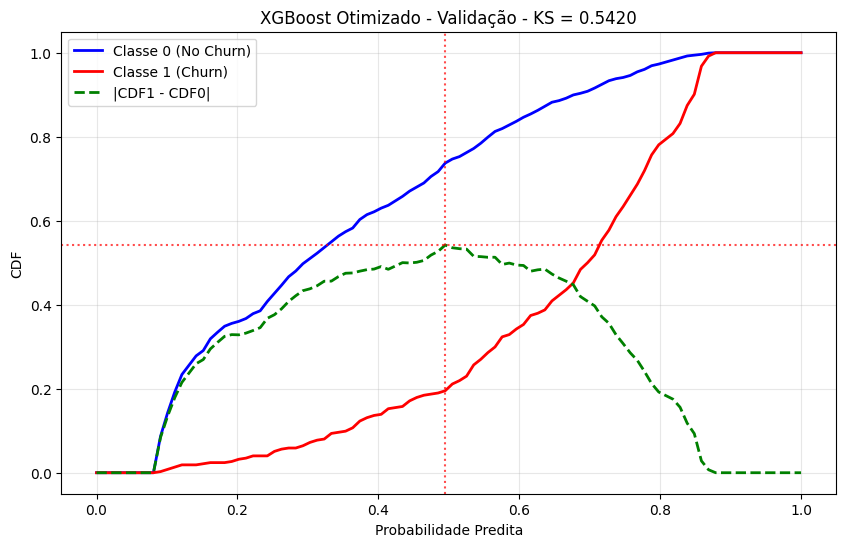

np.float64(0.5420109018574492)

In [ ]:
# Execução do estudo de otimização com Optuna para XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)
print('Melhores hiperparâmetros encontrados para XGBoost:')
print(study_xgb.best_params)
print(f'Melhor KS (validação): {study_xgb.best_value:.4f}')

# Treinando XGBoost com os melhores hiperparâmetros encontrados
best_params_xgb = study_xgb.best_params
xgb_opt_model = XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_opt_model.fit(X_train_balanced, y_train_balanced)

# Predições
y_train_pred_xgb_opt = xgb_opt_model.predict(X_train_scaled)
y_val_pred_xgb_opt = xgb_opt_model.predict(X_val_scaled)
y_test_pred_xgb_opt = xgb_opt_model.predict(X_test_scaled)

y_train_proba_xgb_opt = xgb_opt_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_xgb_opt = xgb_opt_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_xgb_opt = xgb_opt_model.predict_proba(X_test_scaled)[:, 1]

# Avaliação final do modelo otimizado
print("🔍 AVALIAÇÃO DO XGBOOST OTIMIZADO")
print("=" * 50)
xgb_opt_results_train = evaluate_model(y_train, y_train_pred_xgb_opt, y_train_proba_xgb_opt, "TREINAMENTO")
xgb_opt_results_val = evaluate_model(y_val, y_val_pred_xgb_opt, y_val_proba_xgb_opt, "VALIDAÇÃO")
xgb_opt_results_test = evaluate_model(y_test, y_test_pred_xgb_opt, y_test_proba_xgb_opt, "TESTE")

print("\n📈 Curvas KS - XGBoost Otimizado:")
plot_ks_curve(y_val, y_val_proba_xgb_opt, "XGBoost Otimizado - Validação")

In [ ]:
# Visualização dos resultados do Optuna para XGBoost
optuna.visualization.plot_param_importances(study_xgb).show()
optuna.visualization.plot_optimization_history(study_xgb).show()

# 27. Otimização do STab com Optuna

Nesta seção, vamos otimizar o modelo **STab** utilizando Optuna, variando os principais hiperparâmetros do modelo transformer tabular:

- **n_layers**: número de camadas transformer
- **n_heads**: número de cabeças de atenção
- **d_model**: dimensão dos embeddings internos
- **dropout**: taxa de dropout para regularização
- **learning_rate**: taxa de aprendizagem
- **batch_size**: tamanho do lote no treino
- **activation**: função de ativação nas camadas feedforward
- **weight_decay**: regularização L2
- **max_epochs**: número máximo de épocas (early stopping pode ser implementado)

O objetivo é encontrar a melhor configuração para maximizar o KS Score na validação.

In [ ]:
import inspect
import optuna
import torch
import numpy as np
import gc
import keras4torch
from STab import mainmodel, Num_Cat

print("MainModel.__init__ signature:", inspect.signature(mainmodel.MainModel.__init__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_np = X_train.to_numpy().astype(np.float32)
X_val_np = X_val.to_numpy().astype(np.float32)
y_train_np = y_train.reshape(-1, 1).astype(np.float32)
y_val_np = y_val.reshape(-1, 1).astype(np.float32)

X_train_torch = torch.FloatTensor(X_train_np).to(device)
y_train_torch = torch.FloatTensor(y_train_np).to(device)
X_val_torch = torch.FloatTensor(X_val_np).to(device)
y_val_torch = torch.FloatTensor(y_val_np).to(device)

def objective_stab(trial):
    print(f"\n🚀 Iniciando trial {trial.number + 1}...")

    n_layers = trial.suggest_int('n_layers', 1, 2)
    n_heads = trial.suggest_int('n_heads', 2, 3)
    d_model = trial.suggest_int('d_model', 8, 16)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    activation = trial.suggest_categorical('activation', ['relu', 'gelu', 'tanh'])
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.01)
    max_epochs = trial.suggest_int('max_epochs', 3, 5)

    model_kwargs = dict(
        categories=(),
        num_continuous=X_train.shape[1],
        dim=d_model,
        dim_out=1,
        depth=n_layers,
        heads=n_heads,
        attn_dropout=dropout,
        ff_dropout=dropout,
        U=2,
        cases=8
    )

    if 'activation' in inspect.signature(mainmodel.MainModel.__init__).parameters:
        model_kwargs['activation'] = activation

    try:
        Or_model = mainmodel.MainModel(**model_kwargs)
        model_wrapper = Num_Cat(Or_model, num_number=X_train.shape[1], classes=1, Sample_size=d_model)
        model = keras4torch.Model(model_wrapper).build([X_train.shape[1]])
        model.to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model.compile(optimizer=optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])

        history = model.fit(
            [X_train_torch],
            y_train_torch,
            epochs=max_epochs,
            batch_size=batch_size,
            validation_data=([X_val_torch], y_val_torch),
            verbose=0
        )

        with torch.no_grad():
            model.eval()
            val_logits = model(X_val_torch).squeeze()
            y_val_proba = torch.sigmoid(val_logits).cpu().numpy()
            y_val_pred = (y_val_proba > 0.5).astype(int)

        results = evaluate_model(y_val, y_val_pred, y_val_proba, "VALIDAÇÃO")
        print(f"  ✅ Trial {trial.number + 1} finalizado | KS: {results['ks']:.4f}")

        # Liberar memória GPU
        del model, optimizer, history
        gc.collect()
        torch.cuda.empty_cache()

        return results['ks']

    except Exception as e:
        print(f"  ❌ Erro no trial {trial.number + 1}: {type(e).__name__}: {e}")

        # Liberar memória GPU mesmo em caso de erro
        try:
            del model, optimizer
        except NameError:
            pass
        gc.collect()
        torch.cuda.empty_cache()

        raise

print("🔎 Iniciando otimização do STab com Optuna...")
study_stab = optuna.create_study(direction='maximize',
                                 pruner=optuna.pruners.MedianPruner(n_warmup_steps=2))
study_stab.optimize(objective_stab, n_trials=10)
print("✅ Otimização concluída!")

print('Melhores hiperparâmetros encontrados para STab:')
print(study_stab.best_params)
print(f'Melhor KS (validação): {study_stab.best_value:.4f}')


[I 2025-08-09 22:56:16,510] A new study created in memory with name: no-name-2de3c9d0-4ea2-454a-9f2c-2533d5dc1f28


MainModel.__init__ signature: (self, *, categories, num_continuous, dim, depth, heads, dim_head=32, dim_out=1, num_special_tokens=2, attn_dropout=0.0, ff_dropout=0.0, U=2, cases=16)
Using device: cuda
🔎 Iniciando otimização do STab com Optuna...

🚀 Iniciando trial 1...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5040
  📊 ROC-AUC: 0.8235
  🔄 F1-Score: 0.4189
  📉 MSE: 0.1470
  🔥 Cross-Entropy: 0.4562

  📋 Matriz de Confusão:
      [[TN: 990, FP: 45]
       [FN: 263, TP: 111]]
  ✅ Trial 1 finalizado | KS: 0.5040


[I 2025-08-09 22:57:35,072] Trial 0 finished with value: 0.5040404040404041 and parameters: {'n_layers': 2, 'n_heads': 2, 'd_model': 14, 'dropout': 0.29698779278753845, 'learning_rate': 0.0006712059850385244, 'batch_size': 32, 'activation': 'gelu', 'weight_decay': 0.004193496813002505, 'max_epochs': 3}. Best is trial 0 with value: 0.5040404040404041.



🚀 Iniciando trial 2...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5182
  📊 ROC-AUC: 0.8323
  🔄 F1-Score: 0.6200
  📉 MSE: 0.1424
  🔥 Cross-Entropy: 0.4371

  📋 Matriz de Confusão:
      [[TN: 877, FP: 158]
       [FN: 135, TP: 239]]
  ✅ Trial 2 finalizado | KS: 0.5182


[I 2025-08-09 23:00:32,019] Trial 1 finished with value: 0.5181947350745305 and parameters: {'n_layers': 2, 'n_heads': 2, 'd_model': 16, 'dropout': 0.022871033962228227, 'learning_rate': 0.008016146549211789, 'batch_size': 16, 'activation': 'tanh', 'weight_decay': 0.001532945457885352, 'max_epochs': 4}. Best is trial 1 with value: 0.5181947350745305.



🚀 Iniciando trial 3...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5111
  📊 ROC-AUC: 0.8334
  🔄 F1-Score: 0.6039
  📉 MSE: 0.1446
  🔥 Cross-Entropy: 0.4438

  📋 Matriz de Confusão:
      [[TN: 868, FP: 167]
       [FN: 140, TP: 234]]
  ✅ Trial 3 finalizado | KS: 0.5111


[I 2025-08-09 23:01:33,316] Trial 2 finished with value: 0.5110723604329742 and parameters: {'n_layers': 1, 'n_heads': 3, 'd_model': 8, 'dropout': 0.15297142798468966, 'learning_rate': 0.003253528411410605, 'batch_size': 32, 'activation': 'gelu', 'weight_decay': 0.006871294049884167, 'max_epochs': 5}. Best is trial 1 with value: 0.5181947350745305.



🚀 Iniciando trial 4...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5200
  📊 ROC-AUC: 0.8169
  🔄 F1-Score: 0.5515
  📉 MSE: 0.1457
  🔥 Cross-Entropy: 0.4557

  📋 Matriz de Confusão:
      [[TN: 931, FP: 104]
       [FN: 192, TP: 182]]
  ✅ Trial 4 finalizado | KS: 0.5200


[I 2025-08-09 23:02:38,261] Trial 3 finished with value: 0.519969516133199 and parameters: {'n_layers': 2, 'n_heads': 2, 'd_model': 11, 'dropout': 0.16313867524011305, 'learning_rate': 0.000502075192274148, 'batch_size': 32, 'activation': 'relu', 'weight_decay': 0.008375200105009716, 'max_epochs': 3}. Best is trial 3 with value: 0.519969516133199.



🚀 Iniciando trial 5...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4079
  📊 ROC-AUC: 0.7687
  🔄 F1-Score: 0.3566
  📉 MSE: 0.1627
  🔥 Cross-Entropy: 0.5005

  📋 Matriz de Confusão:
      [[TN: 985, FP: 50]
       [FN: 282, TP: 92]]
  ✅ Trial 5 finalizado | KS: 0.4079


[I 2025-08-09 23:03:39,125] Trial 4 finished with value: 0.407871554418869 and parameters: {'n_layers': 1, 'n_heads': 2, 'd_model': 8, 'dropout': 0.10688883148478645, 'learning_rate': 0.0001634528854898174, 'batch_size': 32, 'activation': 'tanh', 'weight_decay': 0.009541683613137179, 'max_epochs': 5}. Best is trial 3 with value: 0.519969516133199.



🚀 Iniciando trial 6...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5165
  📊 ROC-AUC: 0.8268
  🔄 F1-Score: 0.5116
  📉 MSE: 0.1440
  🔥 Cross-Entropy: 0.4470

  📋 Matriz de Confusão:
      [[TN: 958, FP: 77]
       [FN: 219, TP: 155]]
  ✅ Trial 6 finalizado | KS: 0.5165


[I 2025-08-09 23:05:39,516] Trial 5 finished with value: 0.5164638714510837 and parameters: {'n_layers': 1, 'n_heads': 3, 'd_model': 12, 'dropout': 0.421108101852548, 'learning_rate': 0.0006870226793237478, 'batch_size': 16, 'activation': 'relu', 'weight_decay': 0.003861427663688495, 'max_epochs': 5}. Best is trial 3 with value: 0.519969516133199.



🚀 Iniciando trial 7...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5366
  📊 ROC-AUC: 0.8358
  🔄 F1-Score: 0.5533
  📉 MSE: 0.1389
  🔥 Cross-Entropy: 0.4327

  📋 Matriz de Confusão:
      [[TN: 954, FP: 81]
       [FN: 200, TP: 174]]
  ✅ Trial 7 finalizado | KS: 0.5366


[I 2025-08-09 23:07:04,412] Trial 6 finished with value: 0.5365961404324575 and parameters: {'n_layers': 2, 'n_heads': 3, 'd_model': 16, 'dropout': 0.00014715790196895284, 'learning_rate': 0.0016301146933142743, 'batch_size': 32, 'activation': 'gelu', 'weight_decay': 0.008360517294576193, 'max_epochs': 4}. Best is trial 6 with value: 0.5365961404324575.



🚀 Iniciando trial 8...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5297
  📊 ROC-AUC: 0.8334
  🔄 F1-Score: 0.6099
  📉 MSE: 0.1631
  🔥 Cross-Entropy: 0.4873

  📋 Matriz de Confusão:
      [[TN: 748, FP: 287]
       [FN: 84, TP: 290]]
  ✅ Trial 8 finalizado | KS: 0.5297


[I 2025-08-09 23:08:50,062] Trial 7 finished with value: 0.5296985197240952 and parameters: {'n_layers': 2, 'n_heads': 2, 'd_model': 15, 'dropout': 0.23618203221678552, 'learning_rate': 0.003832959775625099, 'batch_size': 32, 'activation': 'gelu', 'weight_decay': 0.005363369224606555, 'max_epochs': 5}. Best is trial 6 with value: 0.5365961404324575.



🚀 Iniciando trial 9...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.4735
  📊 ROC-AUC: 0.8029
  🔄 F1-Score: 0.4154
  📉 MSE: 0.1536
  🔥 Cross-Entropy: 0.4724

  📋 Matriz de Confusão:
      [[TN: 978, FP: 57]
       [FN: 261, TP: 113]]
  ✅ Trial 9 finalizado | KS: 0.4735


[I 2025-08-09 23:09:38,415] Trial 8 finished with value: 0.47348161926167043 and parameters: {'n_layers': 1, 'n_heads': 2, 'd_model': 9, 'dropout': 0.17201811543085455, 'learning_rate': 0.0008511401249541852, 'batch_size': 32, 'activation': 'relu', 'weight_decay': 0.00865172413352897, 'max_epochs': 4}. Best is trial 6 with value: 0.5365961404324575.



🚀 Iniciando trial 10...

📊 VALIDAÇÃO
----------------------------------------
  🎯 KS (Principal): 0.5152
  📊 ROC-AUC: 0.8210
  🔄 F1-Score: 0.3178
  📉 MSE: 0.1505
  🔥 Cross-Entropy: 0.4611

  📋 Matriz de Confusão:
      [[TN: 1012, FP: 23]
       [FN: 299, TP: 75]]
  ✅ Trial 10 finalizado | KS: 0.5152


[I 2025-08-09 23:13:05,060] Trial 9 finished with value: 0.5152290165077889 and parameters: {'n_layers': 2, 'n_heads': 2, 'd_model': 10, 'dropout': 0.37399081613234475, 'learning_rate': 0.0019530364535882048, 'batch_size': 16, 'activation': 'gelu', 'weight_decay': 0.006945884001508319, 'max_epochs': 5}. Best is trial 6 with value: 0.5365961404324575.


✅ Otimização concluída!
Melhores hiperparâmetros encontrados para STab:
{'n_layers': 2, 'n_heads': 3, 'd_model': 16, 'dropout': 0.00014715790196895284, 'learning_rate': 0.0016301146933142743, 'batch_size': 32, 'activation': 'gelu', 'weight_decay': 0.008360517294576193, 'max_epochs': 4}
Melhor KS (validação): 0.5366
